# Here We test <DB, Schema Independent Evaluators> 
- Test only with query, pred_sql, gold_sql
- Step1: Evaluate with only Negative data with existing dataset -> Calculate FP, TN
- Step2: Evaluate with full positive and negative data by adding hand-made poistive set -> Calculate TP ,FN  

### Make Negative Evaluation-pipeline test set from nl2sql_bug set
- Import nl2sql testest and create only-negative evaluation-pipeline test set 

In [1]:
import pandas as pd
from azureml.fsspec import AzureMachineLearningFileSystem
from dotenv import load_dotenv
import os
import json

In [2]:
load_dotenv()
data_storage_uri = os.getenv("AZURE_DATASTORAGE_URI")
fs = AzureMachineLearningFileSystem(data_storage_uri)
fs.ls()

/anaconda/envs/nl2sql_ssfn/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


['UI/']

In [3]:
with fs.open('./UI/2025-07-25_003545_UTC/NL2SQL-Bugs-with-evidence.json') as f:
    data = json.load(f)

nl2sql_bug_df = pd.DataFrame(data)
nl2sql_bug_df["label"] = nl2sql_bug_df["label"].astype(bool)
len(nl2sql_bug_df.loc[nl2sql_bug_df["label"]== True])

1019

In [4]:
# 같은 Question은 공유하고 SQL은 다르게 적힌 True 있나 확인
dupes = (
    nl2sql_bug_df[nl2sql_bug_df["label"] == True]
    .groupby("question")
    #그룹 객체 대상으로 람다실행하고, 조건을 마족하는 원래 DataFrame의 row반환
    .filter(lambda x: len(x) > 1)
)
print(dupes) # 중복된 질문을 가진 True 라벨 row의 수
print(dupes["question"].unique())  # 어떤 question인지 보기



        id                                           question  \
1126  1126  Show me the season page of year when the race ...   
1145  1145  Show me the season page of year when the race ...   

                                               evidence      db_id  \
1126                      race number refers to raceId;  formula_1   
1145  the season page refers to url; race number ref...  formula_1   

                                                    sql  label error_types  
1126  SELECT T2.url FROM races AS T1 INNER JOIN seas...   True          []  
1145  SELECT T2.url FROM races AS T1 INNER JOIN seas...   True          []  
['Show me the season page of year when the race No. 901 took place.']


In [5]:
# 0) Make sure your label column is really boolean
#    (if it's the strings "True"/"False" or ints 1/0, convert it)
nl2sql_bug_df["label"] = nl2sql_bug_df["label"].astype(bool)

# 1) Build a map from question → gold_sql (there must be at most one per question)
gold_map = (
    nl2sql_bug_df
    # 조건을 이용해 행선택하는 함수 
    .loc[nl2sql_bug_df["label"]]
    # 특정열을 인덱스로만 바꾸고, sql 만 선택  
    .set_index("question")["sql"]
    .to_dict()
)

len(gold_map)

1018

In [6]:
# 2) Walk through all FALSE‐label rows and emit one entry per pred_sql
eval_pipeline_test_list = []
for _, row in nl2sql_bug_df.loc[~nl2sql_bug_df["label"]].iterrows():
    q    = row["question"]
    pred = row["sql"]
    eval_pipeline_test_list.append({
        "question":    q,
        "db_id" : row["db_id"],
        "gold_sql":    gold_map.get(q),       # ← will be None only if no True‐row ever existed
        "pred_sql":    pred,
        "label":       False,
        "evidence":    row["evidence"],
        "error_types": row["error_types"],
    })



In [7]:
eval_pipeline_test_df = pd.DataFrame(eval_pipeline_test_list)
eval_pipeline_test_df["gold_sql"].isnull().sum()
eval_pipeline_test_df = eval_pipeline_test_df.loc[eval_pipeline_test_df["gold_sql"].notnull()].copy()

In [8]:
eval_pipeline_test_df

,question,db_id,gold_sql,pred_sql,label,evidence,error_types
0,What is the highest eligible free rate for K-1...,california_schools,SELECT MAX(CAST(`Free Meal Count (K-12)` AS RE...,SELECT max(`free meal count (k-12)`) / max(`en...,False,Eligible free rate for K-12 = `Free Meal Count...,"[{'error_type': 'Function-Related Errors', 'su..."
1,Please list the lowest three eligible free rat...,california_schools,SELECT T2.`Free Meal Count (Ages 5-17)` / T2.`...,SELECT min(`free meal count (ages 5-17)`) FROM...,False,Eligible free rates for students aged 5-17 = `...,"[{'error_type': 'Attribute-Related Errors', 's..."
2,Please list the zip code of all the charter sc...,california_schools,SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...,SELECT schools.zip FROM schools INNER JOIN frp...,False,Charter schools refers to `Charter School (Y/N...,"[{'error_type': 'Value-Related Errors', 'sub_e..."
3,What is the unabbreviated mailing street addre...,california_schools,SELECT T2.MailStreet FROM frpm AS T1 INNER JOI...,SELECT schools.streetabr FROM frpm INNER JOIN ...,False,,"[{'error_type': 'Attribute-Related Errors', 's..."
8,Among the schools with the SAT test takers of ...,california_schools,SELECT T2.School FROM satscores AS T1 INNER JO...,SELECT schools.school FROM schools INNER JOIN ...,False,Magnet schools or offer a magnet program means...,"[{'error_type': 'Attribute-Related Errors', 's..."
...,...,...,...,...,...,...,...
986,For all the transactions happened during 8:00-...,debit_card_specializing,SELECT count(transactions_1k.transactionid) FR...,select count(transactions_1k.transactionid) fr...,False,Czech Republic can be represented as the Count...,"[{'error_type': 'Attribute-Related Errors', 's..."
987,There's one customer spent 214582.17 in the Ju...,debit_card_specializing,SELECT customers.currency FROM customers INNER...,select distinct customers.currency from custom...,False,June of 2013 means Date contains '201306' in t...,"[{'error_type': 'Value-Related Errors', 'sub_e..."
993,Which gas station has the highest amount of re...,debit_card_specializing,SELECT gasstationid FROM transactions_1k GROUP...,select gasstations.gasstationid from gasstatio...,False,,"[{'error_type': 'Table-Related Errors', 'sub_e..."
997,For all the people who paid more than 29.00 pe...,debit_card_specializing,SELECT T1.Consumption FROM yearmonth AS T1 INN...,select distinct yearmonth.consumption from yea...,False,August of 2012 refers to the Date value = '201...,"[{'error_type': 'Value-Related Errors', 'sub_e..."


### Evaluate llm-as-judge-raw-sql-evaluators 
- Testing with only False dataset

In [17]:
import sys
import os
from evaluators.llm_as_judge_raw_sql_evaluator import LLMasJudgeRawSQL
from azure.ai.evaluation import AzureOpenAIModelConfiguration
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv()

model_config_4o = AzureOpenAIModelConfiguration(
    azure_endpoint= os.environ["AZURE_ENDPOINT"],
    azure_key = os.environ["AZURE_API_KEY"],
    azure_deployment = os.environ["AZURE_4O_DEPLOYMENT"],
    api_version = os.environ["AZURE_4O_API_VERSION"]
)

model_config_o4_mini = AzureOpenAIModelConfiguration(
    azure_endpoint= os.environ["AZURE_ENDPOINT"],
    azure_key = os.environ["AZURE_API_KEY"],
    azure_deployment = os.environ["AZURE_O4_MINI_DEPLOYMENT"],
    api_version = os.environ["AZURE_O4_MINI_API_VERSION"]
)


[INFO] Could not import AIAgentConverter. Please install the dependency with `pip install azure-ai-projects`.
[INFO] Could not import SKAgentConverter. Please install the dependency with `pip install semantic-kernel`.


In [19]:
import json
from tqdm import tqdm

llm_sql_evaluator = LLMasJudgeRawSQL(model_config=model_config_o4_mini)
llm_raw_sql_pipeline_eval_result = []

for i, row in tqdm(eval_pipeline_test_df.iterrows(), ncols=100, colour="cyan", total=len(eval_pipeline_test_df)):
    question = row["question"]
    gold_sql = row["gold_sql"]
    pred_sql = row["pred_sql"]

    try:
        result = llm_sql_evaluator(question=question, gold_sql=gold_sql, pred_sql=pred_sql)
        result = json.loads(result)
        llm_raw_sql_pipeline_eval_result.append({
            "question": question,
            "gold_sql": gold_sql,
            "pred_sql": pred_sql,
            "llm_judgement": result["label"],
            "reason": result["reason"]
        })
        print(f"##### {i}th DEBUG LOG #####")
        print("Question:", question)
        print("Gold Sql:", gold_sql)
        print("Pred Sql:", pred_sql)
        print("LLM Judgement:", result["label"])
        print("Reason:", result["reason"])
    except json.JSONDecodeError as e:
        print(f"❌ JSONDecodeError at row {i}: {e}")
        print("⚠️ Raw response was:")
        print(repr(result))  # repr을 사용하면 문제되는 이스케이프 문자 확인 가능
        llm_raw_sql_pipeline_eval_result.append({
            "question": question,
            "gold_sql": gold_sql,
            "pred_sql": pred_sql,
            "llm_judgement": "ERROR",
            "reason": f"JSONDecodeError: {str(e)}"
        })
    except Exception as e:
        print(f"❌ Unexpected error at row {i}: {e}")
        llm_raw_sql_pipeline_eval_result.append({
            "question": question,
            "gold_sql": gold_sql,
            "pred_sql": pred_sql,
            "llm_judgement": "ERROR",
            "reason": f"Exception: {str(e)}"
        })




  0%|                                                             | 1/549 [00:16<2:32:08, 16.66s/it]

##### 0th DEBUG LOG #####
Question: What is the highest eligible free rate for K-12 students in the schools in Alameda County?
Gold Sql: SELECT MAX(CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) FROM frpm WHERE `County Name` = 'Alameda'
Pred Sql: SELECT max(`free meal count (k-12)`) / max(`enrollment (k-12)`) FROM frpm WHERE `county name` = 'Alameda'
LLM Judgement: incorrect
Reason: The predicted query takes the maximum free count and maximum enrollment separately and then divides them, rather than computing the free-to-enrollment ratio for each school and selecting its maximum as in the gold query.


KeyboardInterrupt: 

In [ ]:
llm_raw_sql_pipeline_eval_df = pd.DataFrame(llm_raw_sql_pipeline_eval_result)

#Join with Original Eval test set 

merged_llm_raw_sql_pipeline_eval_df = pd.merge(eval_pipeline_test_df, llm_raw_sql_pipeline_eval_df, on="pred_sql", how='left')
merged_llm_raw_sql_pipeline_eval_df.drop(["question_y","gold_sql_y"], axis = 1)

fp = len(merged_llm_raw_sql_pipeline_eval_df[merged_llm_raw_sql_pipeline_eval_df["llm_judgement"] == "correct"])
tn = len(merged_llm_raw_sql_pipeline_eval_df[merged_llm_raw_sql_pipeline_eval_df["llm_judgement"] == "incorrect"])


print("Total:", len(merged_llm_raw_sql_pipeline_eval_df))
print("FP:", fp)
print("TN:", tn)
print(fp/tn*100)


In [ ]:
print(merged_llm_raw_sql_pipeline_eval_df[merged_llm_raw_sql_pipeline_eval_df["llm_judgement"] == "correct"]["error_types"])

total_errortypes_count = {}
for _, row in merged_llm_raw_sql_pipeline_eval_df.iterrows():
    error_type = row["error_types"][0]["error_type"]
    sub_error_type = row["error_types"][0]["sub_error_type"]
    key_tuple = (error_type,sub_error_type)
    total_errortypes_count[key_tuple] = total_errortypes_count.get(key_tuple,0) +1

print(total_errortypes_count)

fp_errortypes_count = {}
for _, row in merged_llm_raw_sql_pipeline_eval_df[merged_llm_raw_sql_pipeline_eval_df["llm_judgement"] == "correct"].iterrows():
    error_type = row["error_types"][0]["error_type"]
    sub_error_type = row["error_types"][0]["sub_error_type"]
    key_tuple = (error_type,sub_error_type)
    fp_errortypes_count[key_tuple] = fp_errortypes_count.get(key_tuple,0) +1

print(fp_errortypes_count)




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 두 딕셔너리의 모든 고유 키를 추출
all_keys = sorted(list(set(list(total_errortypes_count.keys()) + list(fp_errortypes_count.keys()))))

# 모든 키를 포함하고 누락된 키는 0으로 채운 완전한 딕셔너리 생성
full_dist1 = {key: total_errortypes_count.get(key, 0) for key in all_keys}
full_dist2 = {key: fp_errortypes_count.get(key, 0) for key in all_keys}

# DataFrame으로 변환 (시각화를 위해 긴 형식으로 변환)
df1 = pd.DataFrame(list(full_dist1.items()), columns=['Error Type', 'Count'])
df1['Distribution'] = 'Distribution 1'

df2 = pd.DataFrame(list(full_dist2.items()), columns=['Error Type', 'Count'])
df2['Distribution'] = 'Distribution 2'

# 두 데이터프레임을 하나로 합치기
combined_df = pd.concat([df1, df2])

# 오류 카테고리와 유형 분리 (튜플 형태의 키를 분리)
combined_df[['Error Category', 'Error Subtype']] = pd.DataFrame(combined_df['Error Type'].tolist(), index=combined_df.index)

# 시각화를 위한 정렬 (Count가 높은 순서대로)
# 모든 오류 유형에 대한 총 Count를 기준으로 정렬
error_order = combined_df.groupby('Error Subtype')['Count'].sum().sort_values(ascending=False).index

# 시각화 설정
plt.figure(figsize=(16, 10)) # 그래프 크기 설정
sns.set_theme(style="whitegrid") # 스타일 설정

# 막대 그래프 그리기 (오류 유형별로 Distribution 1과 Distribution 2 비교)
ax = sns.barplot(
    x='Count',
    y='Error Subtype',
    hue='Distribution',
    data=combined_df,
    order=error_order,
    palette='viridis' # 색상 팔레트 설정
)

plt.title('Comparison of Error Distributions', fontsize=16) # 그래프 제목
plt.xlabel('Number of Errors', fontsize=12) # x축 레이블
plt.ylabel('Error Type', fontsize=12) # y축 레이블
plt.legend(title='Distribution', fontsize=10, title_fontsize=12) # 범례

# y축 레이블 텍스트가 잘리지 않도록 레이아웃 조정
plt.tight_layout()

plt.show() # 그래프 출력

# ---
# 보너스: 상대 빈도 비교 시각화 (더 명확한 비율 비교)
# ---

# 상대 빈도 계산 (이전 코드에서 계산했던 방식 재사용)
total_dist1_count = df1['Count'].sum()
total_dist2_count = df2['Count'].sum()

df1['Relative Frequency (%)'] = (df1['Count'] / total_dist1_count) * 100
df2['Relative Frequency (%)'] = (df2['Count'] / total_dist2_count) * 100

combined_relative_df = pd.concat([df1, df2])

# 상대 빈도를 기준으로 정렬 (Distribution 1의 상대 빈도를 기준으로)
relative_error_order = combined_relative_df[combined_relative_df['Distribution'] == 'Distribution 1'] \
    .sort_values(by='Relative Frequency (%)', ascending=False)['Error Subtype']

plt.figure(figsize=(16, 10))
sns.barplot(
    x='Relative Frequency (%)',
    y='Error Subtype',
    hue='Distribution',
    data=combined_relative_df,
    order=relative_error_order,
    palette='magma' # 다른 색상 팔레트
)

plt.title('Comparison of Error Distributions by Relative Frequency', fontsize=16)
plt.xlabel('Relative Frequency (%)', fontsize=12)
plt.ylabel('Error Type', fontsize=12)
plt.legend(title='Distribution', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

### Evaluate Component Matching 
- Testing with Incorrect set 

In [ ]:
from evaluators.cm_evaluator import ComponentMatchingEvaluator
import json 
from tqdm import tqdm
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
cm_evaluator = ComponentMatchingEvaluator()
cm_eval_result = []
for i, row in tqdm(eval_pipeline_test_df.iterrows(),ncols=100,colour="cyan", total= len(eval_pipeline_test_df)):
    gold_sql = row["gold_sql"]
    pred_sql = row["pred_sql"]
    print(f"##### {i}th DEBUG LOG #####")
    print("Gold Sql:", gold_sql)
    print("Pred Sql:", pred_sql)
    cm, detail = cm_evaluator(gold_sql= gold_sql, pred_sql = pred_sql)
    cm_eval_result.append(
        {"gold_sql": gold_sql, "pred_sql": pred_sql, "cm_score": cm, "detail": detail}
    )
    print("CM Score", cm   )
    print("CM Detail ", detail)

In [ ]:
cm_pipeline_eval_df = pd.DataFrame(cm_eval_result)

#Join with Original Eval test set 

merged_exact_match_pipeline_eval_df = pd.merge(eval_pipeline_test_df, cm_pipeline_eval_df, on="pred_sql", how='left')
merged_exact_match_pipeline_eval_df.drop(["gold_sql_y"], axis = 1)

cm_mean = merged_exact_match_pipeline_eval_df["cm_score"].mean()

print("Total:", len(merged_exact_match_pipeline_eval_df))
print("CM Mean:", cm_mean)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(merged_exact_match_pipeline_eval_df["cm_score"], bins=10, edgecolor='black')
plt.title("Component Match Score Distribution")
plt.xlabel("CM Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Evaluate Exact Matching
- Test only with false examples

In [ ]:
from evaluators.exact_match_evaluator import ExactMatchEvaluatorStrictWithFullLog
import json 
from tqdm import tqdm
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
exact_match_evaluator = ExactMatchEvaluatorStrictWithFullLog()

exact_match_eval_result = []
for i, row in tqdm(eval_pipeline_test_df.iterrows(),ncols=100,colour="cyan", total= len(eval_pipeline_test_df)):
    gold_sql = row["gold_sql"]
    pred_sql = row["pred_sql"]
    print(f"##### {i}th DEBUG LOG #####")
    print("Gold Sql:", gold_sql)
    print("Pred Sql:", pred_sql)
    is_exact = exact_match_evaluator(gold_sql= gold_sql, pred_sql = pred_sql)
    
    exact_match_eval_result.append(
        {"gold_sql": gold_sql, "pred_sql": pred_sql, "exact_match_result": is_exact })
    print("Exact Match Result ", is_exact)


In [ ]:
exact_match_pipeline_eval_df = pd.DataFrame(exact_match_eval_result)

#Join with Original Eval test set 

merged_exact_match_pipeline_eval_df = pd.merge(eval_pipeline_test_df, exact_match_pipeline_eval_df, on="pred_sql", how='left')
merged_exact_match_pipeline_eval_df.drop(["gold_sql_y"], axis = 1)

num_false = len(merged_exact_match_pipeline_eval_df[merged_exact_match_pipeline_eval_df["exact_match_result"] == False])
num_true = len(merged_exact_match_pipeline_eval_df[merged_exact_match_pipeline_eval_df["exact_match_result"] == True])
print("Fasle:", num_false)
print("True:", num_true)

In [ ]:
trues = merged_exact_match_pipeline_eval_df[merged_exact_match_pipeline_eval_df["exact_match_result"] == True]
trues

### Evaluate Execution Match with LLM as a Judge
- We will gonna implement Execution Match metrics and decide with LLM
- We will qeury to database and retrieve result from it, using our pipeline-evaluation set 

In [9]:
import os 
import pandas as pd 
from db_utils.db_utils import get_db_path, execute_query, format_results_for_llm

#Base_dir should be path for project root
base_dir = os.path.abspath("..")

exec_match_test_df = eval_pipeline_test_df.copy()

exec_match_test_df["gold_result"] = None
exec_match_test_df["pred_result"] = None




In [10]:
# 5) 순회하며 실행 및 포매팅
for idx, row in exec_match_test_df.iterrows():
    db_id    = row["db_id"]
    gold_sql = row["gold_sql"]
    pred_sql = row["pred_sql"]

    try:
        db_path = get_db_path(base_dir, db_id)
    except FileNotFoundError as e:
        exec_match_test_df.at[idx, "gold_result"] = f"ERROR: {e}"
        exec_match_test_df.at[idx, "pred_result"] = f"ERROR: {e}"
        continue

    # gold 실행 → 포매팅
    gold_raw = execute_query(db_path, gold_sql)
    exec_match_test_df.at[idx, "gold_result"] = format_results_for_llm(
        gold_raw,
        sort_keys=list(gold_raw[0].keys()) if gold_raw else None,
        row_limit=10
    )

    # pred 실행 → 포매팅
    pred_raw = execute_query(db_path, pred_sql)
    exec_match_test_df.at[idx, "pred_result"] = format_results_for_llm(
        pred_raw,
        sort_keys=list(pred_raw[0].keys()) if pred_raw else None,
        row_limit=5
    )


⚠️ 정렬 중 오류 (무시됨): '<' not supported between instances of 'int' and 'str'
⚠️ 정렬 중 오류 (무시됨): '<' not supported between instances of 'str' and 'int'


In [13]:
from db_utils.db_utils import print_markdown_table

# 6) 결과 확인
exec_match_test_df[["db_id","gold_result","pred_result"]].head(10)


,db_id,gold_result,pred_result
0,california_schools,```\n| MAX(CAST(`Free Meal Count (K-12)` AS RE...,```\n| max(`free meal count (k-12)`) / max(`en...
1,california_schools,```\n| EligibleFreeRate |\n| --- |\n| 0.043478...,```\n| min(`free meal count (ages 5-17)`) |\n|...
2,california_schools,```\n| Zip |\n| --- |\n| 93628-9602 |\n| 93706...,```\n| Zip |\n| --- |\n| 91361-6004 |\n| 93065...
3,california_schools,```\n| MailStreet |\n| --- |\n| 14429 South Do...,```\n| StreetAbr |\n| --- |\n| 14429 South Dow...
8,california_schools,```\n| School |\n| --- |\n| Millikan High |\n|...,```\n(결과 없음)\n```
9,california_schools,```\n| Phone |\n| --- |\n| (213) 241-1000 |\n```,```\n| Phone |\n| --- |\n| None |\n```
10,california_schools,```\n| NumTstTakr |\n| --- |\n| 459 |\n```,```\n(결과 없음)\n```
13,california_schools,```\n| FRPM Count (Ages 5-17) |\n| --- |\n| 13...,```\n(결과 없음)\n```
14,california_schools,```\n| HighestEligibleFreeRate |\n| --- |\n| 0...,```\n| max(`free meal count (ages 5-17)`) |\n|...
15,california_schools,```\n| District |\n| --- |\n| Palo Alto Unifie...,```\n(결과 없음)\n```


In [14]:
for idx in range(3):
    print(f"\n====== ✅ Row {idx} / DB: {exec_match_test_df.iloc[idx]['db_id']} ======\n")
    
    print_markdown_table(
        md_str=exec_match_test_df.iloc[idx]["gold_result"],
        title="GOLD RESULT"
    )
    
    print_markdown_table(
        md_str=exec_match_test_df.iloc[idx]["pred_result"],
        title="PREDICTED RESULT"
    )



====== ✅ Row 0 / DB: california_schools ======


📄 GOLD RESULT
---------------
+---------------------------------------------------------------------+
|   MAX(CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) |
+=====================================================================+
|                                                                   1 |
+---------------------------------------------------------------------+

📄 PREDICTED RESULT
--------------------
+------------------------------------------------------------+
|   max(`free meal count (k-12)`) / max(`enrollment (k-12)`) |
+============================================================+
|                                                   0.325409 |
+------------------------------------------------------------+

====== ✅ Row 1 / DB: california_schools ======


📄 GOLD RESULT
---------------
+--------------------+
|   EligibleFreeRate |
+====================+
|          0.0434783 |
+--------------------+
|        

In [22]:
from evaluators.llm_as_judge_exec_match_evaluator import LLMasJudgeExecMatch


llm_exec_match_evaluator = LLMasJudgeExecMatch(model_config=model_config_o4_mini)
llm_exec_match_pipeline_eval_result = []

for i, row in tqdm(exec_match_test_df.iterrows(), ncols=100, colour="cyan", total=len(eval_pipeline_test_df)):
    question = row["question"]
    gold_result = row["gold_result"]
    pred_result = row["pred_result"]

    try:
        result = llm_exec_match_evaluator(question=question, gold_result=gold_result, pred_result=pred_result)
        result = json.loads(result)
        llm_exec_match_pipeline_eval_result.append({
            "question": question,
            "gold_result": gold_result,
            "pred_result": pred_result,
            "llm_judgement": result["label"],
            "reason": result["reason"]
        })
        print(f"##### {i}th DEBUG LOG #####")
        print("Question:", question)
        print("Gold Result:", print_markdown_table(gold_result))
        print("Pred Result:", print_markdown_table(pred_result))
        print("LLM Judgement:", result["label"])
        print("Reason:", result["reason"])

    except json.JSONDecodeError as e:
        print(f"❌ JSONDecodeError at row {i}: {e}")
        print("⚠️ Raw response was:")
        print(repr(result))  # repr을 사용하면 문제되는 이스케이프 문자 확인 가능
        llm_raw_sql_pipeline_eval_result.append({
            "question": question,
            "gold_result": gold_result,
            "pred_result": pred_result,
            "llm_judgement": "ERROR",
            "reason": f"JSONDecodeError: {str(e)}"
        })
    except Exception as e:
        print(f"❌ Unexpected error at row {i}: {e}")
        llm_raw_sql_pipeline_eval_result.append({
            "question": question,
            "gold_result": gold_result,
            "pred_result": pred_result,
            "llm_judgement": "ERROR",
            "reason": f"Exception: {str(e)}"
        })




  0%|                                                                       | 0/549 [00:00<?, ?it/s]

  0%|                                                               | 1/549 [00:03<31:49,  3.48s/it]

##### 0th DEBUG LOG #####
Question: What is the highest eligible free rate for K-12 students in the schools in Alameda County?
+---------------------------------------------------------------------+
|   MAX(CAST(`Free Meal Count (K-12)` AS REAL) / `Enrollment (K-12)`) |
+=====================================================================+
|                                                                   1 |
+---------------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------------+
|   max(`free meal count (k-12)`) / max(`enrollment (k-12)`) |
+============================================================+
|                                                   0.325409 |
+------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result uses max(free meal count) / max(enrollment) instead of max(free_rate) and returns 0.3254 rather than the cor

  0%|▏                                                              | 2/549 [00:07<36:51,  4.04s/it]

##### 1th DEBUG LOG #####
Question: Please list the lowest three eligible free rates for students aged 5-17 in continuation schools.
+--------------------+
|   EligibleFreeRate |
+====================+
|          0.0434783 |
+--------------------+
|          0.0704225 |
+--------------------+
|          0.113636  |
+--------------------+
Gold Result: None
+--------------------------------------+
|   min(`free meal count (ages 5-17)`) |
+======================================+
|                                    1 |
+--------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns only a single minimum free meal count rather than the three lowest eligible free rates as decimals.


  1%|▎                                                              | 3/549 [00:12<39:16,  4.32s/it]

##### 2th DEBUG LOG #####
Question: Please list the zip code of all the charter schools in Fresno County Office of Education.
+------------+
| Zip        |
+============+
| 93628-9602 |
+------------+
| 93706-2611 |
+------------+
| 93706-2819 |
+------------+
| 93726-5208 |
+------------+
| 93726-5309 |
+------------+
Gold Result: None
+------------+
| Zip        |
+============+
| 91361-6004 |
+------------+
| 93065-1800 |
+------------+
| 93609-9710 |
+------------+
| 93611-0581 |
+------------+
| 93611-4646 |
+------------+
|            |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted zip codes differ entirely from the gold list and do not match the charter schools in Fresno County Office of Education.


  1%|▍                                                              | 4/549 [00:16<39:36,  4.36s/it]

##### 3th DEBUG LOG #####
Question: What is the unabbreviated mailing street address of the school with the highest FRPM count for K-12 students?
+---------------------------+
| MailStreet                |
+===========================+
| 14429 South Downey Avenue |
+---------------------------+
Gold Result: None
+-------------------------+
| StreetAbr               |
+=========================+
| 14429 South Downey Ave. |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result uses an abbreviated form ('Ave.') instead of the required unabbreviated 'Avenue', so it does not match the gold answer.


  1%|▌                                                              | 5/549 [00:23<48:06,  5.31s/it]

##### 8th DEBUG LOG #####
Question: Among the schools with the SAT test takers of over 500, please list the schools that are magnet schools or offer a magnet program.
+------------------+
| School           |
+==================+
| Millikan High    |
+------------------+
| Polytechnic High |
+------------------+
| Troy High        |
+------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result lists three schools (Millikan High, Polytechnic High, Troy High).


  1%|▋                                                            | 6/549 [00:34<1:04:19,  7.11s/it]

##### 9th DEBUG LOG #####
Question: What is the phone number of the school that has the highest number of test takers with an SAT score of over 1500?
+----------------+
| Phone          |
+================+
| (213) 241-1000 |
+----------------+
Gold Result: None
+---------+
| Phone   |
+=========+
| None    |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns the phone number (213) 241-1000, while the predicted result returns None, omitting the required value.


  1%|▊                                                              | 7/549 [00:39<58:24,  6.47s/it]

##### 10th DEBUG LOG #####
Question: What is the number of SAT test takers of the schools with the highest FRPM count for K-12 students?
+--------------+
|   NumTstTakr |
+==============+
|          459 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns a value of 459, but the predicted result is empty, missing the required data.


  1%|▉                                                              | 8/549 [00:45<56:53,  6.31s/it]

##### 13th DEBUG LOG #####
Question: For the school with the highest average score in Reading in the SAT test, what is its FRPM count for students aged 5-17?
+--------------------------+
|   FRPM Count (Ages 5-17) |
+==========================+
|                      136 |
+--------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result returns a FRPM count of 136.0.


  2%|█                                                            | 9/549 [00:53<1:01:40,  6.85s/it]

##### 14th DEBUG LOG #####
Question: Among the schools with an SAT excellence rate of over 0.3, what is the highest eligible free rate for students aged 5-17?
+---------------------------+
|   HighestEligibleFreeRate |
+===========================+
|                  0.904908 |
+---------------------------+
Gold Result: None
+--------------------------------------+
|   max(`free meal count (ages 5-17)`) |
+======================================+
|                                  634 |
+--------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a count of free meals (634) instead of the highest eligible free rate (0.9049) for students aged 5–17.


  2%|█▏                                                            | 10/549 [00:58<55:35,  6.19s/it]

##### 15th DEBUG LOG #####
Question: Which active district has the highest average score in Reading?
+-------------------+
| District          |
+===================+
| Palo Alto Unified |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result identifies 'Palo Alto Unified' as the district with the highest average Reading score.


  2%|█▏                                                            | 11/549 [01:05<58:04,  6.48s/it]

##### 16th DEBUG LOG #####
Question: Which active district has the highest average score in Reading?
+-------------------+
| District          |
+===================+
| Palo Alto Unified |
+-------------------+
Gold Result: None
+---------------------------------------+
| District                              |
+=======================================+
| Santa Cruz County Office of Education |
+---------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted district (‘Santa Cruz County Office of Education’) does not match the gold answer (‘Palo Alto Unified’).


  2%|█▎                                                            | 12/549 [01:08<47:49,  5.34s/it]

##### 20th DEBUG LOG #####
Question: What is the phone number of the school that has the highest average score in Math?
+----------------+
| Phone          |
+================+
| (408) 366-7700 |
+----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result returns the phone number (408) 366-7700.


  2%|█▍                                                            | 13/549 [01:13<47:37,  5.33s/it]

##### 21th DEBUG LOG #####
Question: In Los Angeles how many schools have more than 500 free meals but less than 700 free or reduced price meals for K-12?
+------------------+
|   COUNT(CDSCode) |
+==================+
|              249 |
+------------------+
Gold Result: None
+-------------------------+
|   count(schools.school) |
+=========================+
|                      87 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (87) does not match the gold count (249), so the result is incorrect.


  3%|█▌                                                          | 14/549 [01:28<1:12:26,  8.12s/it]

##### 30th DEBUG LOG #####
Question: What is the eligible free or reduced price meal rate for the top 5 schools in grades 1-12 with the highest free or reduced price meal count of the schools with the ownership code 66?
+----------------------+
|   Eligible_FRPM_Rate |
+======================+
|             0.89582  |
+----------------------+
|             0.896499 |
+----------------------+
|             0.91418  |
+----------------------+
|             0.917948 |
+----------------------+
|             0.999329 |
+----------------------+
Gold Result: None
+------------------------------------------------------------+
|   frpm.`free meal count (k-12)` / frpm.`enrollment (k-12)` |
+============================================================+
|                                                   0.815746 |
+------------------------------------------------------------+
|                                                   0.835995 |
+----------------------------------------------------------

  3%|█▋                                                          | 15/549 [01:38<1:17:44,  8.73s/it]

##### 32th DEBUG LOG #####
Question: Under whose administration is the school with the highest number of students scoring 1500 or more on the SAT? Indicate their full names.
+-------------+-------------+-------------+-------------+-------------+-------------+
| AdmFName1   | AdmLName1   | AdmFName2   | AdmLName2   | AdmFName3   | AdmLName3   |
+=============+=============+=============+=============+=============+=============+
| Michelle    | King        | None        | None        | None        | None        |
+-------------+-------------+-------------+-------------+-------------+-------------+
Gold Result: None
+-------------+-------------+-------------+-------------+-------------+-------------+
| AdmFName1   | AdmFName2   | AdmFName3   | AdmLName1   | AdmLName2   | AdmLName3   |
+=============+=============+=============+=============+=============+=============+
| Michelle    | None        | None        | King        | None        | None        |
+-------------+-------------+-----

  3%|█▋                                                          | 16/549 [01:59<1:50:24, 12.43s/it]

##### 33th DEBUG LOG #####
Question: What are the webpages for the Los Angeles County school that has between 2,000 and 3,000 test takers?
+----------------------+
| Website              |
+======================+
| www.avdistrict.org   |
+----------------------+
| www.hartdistrict.org |
+----------------------+
| www.lbschools.net    |
+----------------------+
Gold Result: None
+-------------------+
| Website           |
+===================+
| www.lbschools.net |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only includes www.lbschools.net but is missing www.avdistrict.org and www.hartdistrict.org from the gold result.


  3%|█▊                                                          | 17/549 [02:08<1:42:21, 11.54s/it]

##### 34th DEBUG LOG #####
Question: What are the webpages for the Los Angeles County school that has between 2,000 and 3,000 test takers?
+----------------------+
| Website              |
+======================+
| www.avdistrict.org   |
+----------------------+
| www.hartdistrict.org |
+----------------------+
| www.lbschools.net    |
+----------------------+
Gold Result: None
+---------------------+
| Website             |
+=====================+
| www.auhsd.us        |
+---------------------+
| www.avdistrict.org  |
+---------------------+
| www.capousd.org     |
+---------------------+
| www.cjuhsd.net      |
+---------------------+
| www.cnusd.k12.ca.us |
+---------------------+
|                     |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes many irrelevant websites and does not match the three correct ones from the gold result.


  3%|█▉                                                          | 18/549 [02:19<1:39:11, 11.21s/it]

##### 35th DEBUG LOG #####
Question: What is the average number of test takers from Fresno schools that opened between 1/1/1980 and 12/31/1980?
+----------------------+
|   AVG(T2.NumTstTakr) |
+======================+
|              137.889 |
+----------------------+
Gold Result: None
+-----------------------------+
|   avg(satscores.numtsttakr) |
+=============================+
|                     160.206 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (160.2063) differs from the gold result (137.8889), so the predicted result does not match the expected answer.


  3%|██                                                          | 19/549 [02:31<1:40:49, 11.41s/it]

##### 36th DEBUG LOG #####
Question: What is the type of education offered in the school who scored the highest average in Math?
+-------------+
| EdOpsName   |
+=============+
| Traditional |
+-------------+
Gold Result: None
+-------------+
| EdOpsCode   |
+=============+
| TRAD        |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns an education code (TRAD) instead of the education type name (Traditional) required by the question.


  4%|██▏                                                         | 20/549 [02:35<1:22:56,  9.41s/it]

##### 37th DEBUG LOG #####
Question: Which state special schools have the highest number of enrollees from grades 1 through 12?
+----------------------------------------+
| School                                 |
+========================================+
| California School for the Deaf-Fremont |
+----------------------------------------+
Gold Result: None
+---------+
| State   |
+=========+
| CA      |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a state code (CA) instead of the school name and does not match the gold answer.


  4%|██▎                                                         | 21/549 [02:45<1:22:07,  9.33s/it]

##### 38th DEBUG LOG #####
Question: What is the monthly average number of schools that opened in Alameda County under the jurisdiction of the Elementary School District in 1980?
+-------------------------------------+
|   CAST(COUNT(CDSCode) AS REAL) / 12 |
+=====================================+
|                             1.41667 |
+-------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------+
|   cast(sum(case when schools.opendate = 1980 then 1 else 0 end) as real) / 12 |
+===============================================================================+
|                                                                             0 |
+-------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (0.0) does not match the gold result (1.4167), so it fails to provide the same answer.


  4%|██▍                                                         | 22/549 [02:50<1:12:52,  8.30s/it]

##### 39th DEBUG LOG #####
Question: What is the monthly average number of schools that opened in Alameda County under the jurisdiction of the Elementary School District in 1980?
+-------------------------------------+
|   CAST(COUNT(CDSCode) AS REAL) / 12 |
+=====================================+
|                             1.41667 |
+-------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN schools.opendate LIKE '1980%' THEN 1 ELSE 0 END) AS REAL) / 12 |
+=====================================================================================+
|                                                                           0.0833333 |
+-------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result yields 0.0833 instead of the expected 1.4167, so it undercounts the number of schools opene

  4%|██▌                                                         | 23/549 [03:07<1:35:03, 10.84s/it]

##### 40th DEBUG LOG #####
Question: What is the ratio of merged Unified School District schools in Orange County to merged Elementary School District schools?
+-------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN DOC = 54 THEN 1 ELSE 0 END) AS REAL) / SUM(CASE WHEN DOC = 52 THEN 1 ELSE 0 END) |
+=======================================================================================================+
|                                                                                              0.571429 |
+-------------------------------------------------------------------------------------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when schools.doctype = 'Unified School District' then 1 else 0 end) as real) / count(schools.school) |
+=================================================

  4%|██▌                                                         | 24/549 [03:23<1:47:31, 12.29s/it]

##### 41th DEBUG LOG #####
Question: What is the ratio of merged Unified School District schools in Orange County to merged Elementary School District schools?
+-------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN DOC = 54 THEN 1 ELSE 0 END) AS REAL) / SUM(CASE WHEN DOC = 52 THEN 1 ELSE 0 END) |
+=======================================================================================================+
|                                                                                              0.571429 |
+-------------------------------------------------------------------------------------------------------+
Gold Result: None
+-----------------------------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN schools.doc = 54 THEN 1 ELSE 0 END) AS REAL) * 100 / sum(CASE WHEN schools.doc = 52 THEN 1 ELSE 0 END) |
+===================================

  5%|██▋                                                         | 25/549 [03:27<1:24:39,  9.69s/it]

##### 45th DEBUG LOG #####
Question: In which mailing street address can you find the school that has the lowest average score in reading? Also give the school's name.
+------------------+-------------------------+
| MailStreet       | School                  |
+==================+=========================+
| 1050 York Street | S.F. International High |
+------------------+-------------------------+
Gold Result: None
+--------------------------------+----------------------------+
| MailStrAbr                     | School                     |
+================================+============================+
| 42455 Tenth St. West, Ste. 105 | Crescent View West Charter |
+--------------------------------+----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists a different school and address than the gold result, so it does not match the school with the lowest average reading score.


  5%|██▊                                                         | 26/549 [03:29<1:05:06,  7.47s/it]

##### 46th DEBUG LOG #####
Question: In which mailing street address can you find the school that has the lowest average score in reading? Also give the school's name.
+------------------+-------------------------+
| MailStreet       | School                  |
+==================+=========================+
| 1050 York Street | S.F. International High |
+------------------+-------------------------+
Gold Result: None
+----------------------+---------+
| MailStreet           | sname   |
+======================+=========+
| 1111 Van Ness Avenue | None    |
+----------------------+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has a different address and no school name, which does not match the gold answer.


  5%|██▉                                                         | 27/549 [03:35<1:02:40,  7.20s/it]

##### 47th DEBUG LOG #####
Question: What is the total number of schools whose total SAT scores are greater or equal to 1500 whose mailing city is Lakeport?
+-----------------+
|   COUNT(T1.cds) |
+=================+
|               2 |
+-----------------+
Gold Result: None
+-------------------------+
|   count(schools.school) |
+=========================+
|                       0 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0, but the gold result indicates there are 2 such schools.


  5%|███                                                         | 28/549 [03:42<1:00:45,  7.00s/it]

##### 48th DEBUG LOG #####
Question: What is the total number of schools whose total SAT scores are greater or equal to 1500 whose mailing city is Lakeport?
+-----------------+
|   COUNT(T1.cds) |
+=================+
|               2 |
+-----------------+
Gold Result: None
+-------------------------+
|   count(schools.school) |
+=========================+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 1 school, while the gold result shows 2 schools meeting the criteria.


  5%|███▏                                                        | 29/549 [03:50<1:03:52,  7.37s/it]

##### 49th DEBUG LOG #####
Question: Please specify all of the schools and their related mailing zip codes that are under Avetik Atoian's administration.
+-----------------+------------+
| School          | MailZip    |
+=================+============+
| Fairview Middle | 93926-0238 |
+-----------------+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains Fairview Middle with its zip code, so the predicted output is missing the required data.


  5%|███▎                                                        | 30/549 [03:59<1:06:42,  7.71s/it]

##### 50th DEBUG LOG #####
Question: Please specify all of the schools and their related mailing zip codes that are under Avetik Atoian's administration.
+-----------------+------------+
| School          | MailZip    |
+=================+============+
| Fairview Middle | 93926-0238 |
+-----------------+------------+
Gold Result: None
+--------------------------------------------+-----------+
| School                                     |   MailZip |
+============================================+===========+
| Enterprise Secondary                       |     93637 |
+--------------------------------------------+-----------+
| Juvenile Hall (Endeavor/Voyager Secondary) |     93637 |
+--------------------------------------------+-----------+
| Madera County Independent Academy          |     93637 |
+--------------------------------------------+-----------+
| Pioneer Technical Center                   |     93637 |
+--------------------------------------------+-----------+
Pred Result: N

  6%|███▌                                                          | 31/549 [04:02<54:55,  6.36s/it]

##### 51th DEBUG LOG #####
Question: Of the schools with a mailing state address in California, what is the ratio of the schools located in the county of Colusa against the school located in the county of Humboldt?
+---------------------------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN County = 'Colusa' THEN 1 ELSE 0 END) AS REAL) / SUM(CASE WHEN County = 'Humboldt' THEN 1 ELSE 0 END) |
+===========================================================================================================================+
|                                                                                                                  0.180905 |
+---------------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------------------------------------+
|   c

  6%|███▌                                                          | 32/549 [04:07<52:13,  6.06s/it]

##### 52th DEBUG LOG #####
Question: Of the schools with a mailing state address in California, what is the ratio of the schools located in the county of Colusa against the school located in the county of Humboldt?
+---------------------------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN County = 'Colusa' THEN 1 ELSE 0 END) AS REAL) / SUM(CASE WHEN County = 'Humboldt' THEN 1 ELSE 0 END) |
+===========================================================================================================================+
|                                                                                                                  0.180905 |
+---------------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------------------------------------+
|   c

  6%|███▋                                                          | 33/549 [04:16<59:53,  6.96s/it]

##### 53th DEBUG LOG #####
Question: What is the phone number and extension number for the school that had the 333rd highest average writing score?
+----------------+-------+
| Phone          | Ext   |
+================+=======+
| (916) 395-5050 | None  |
+----------------+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains a phone number and extension, so the predicted answer is missing the required information.


  6%|███▊                                                          | 34/549 [04:22<56:55,  6.63s/it]

##### 54th DEBUG LOG #####
Question: What is the phone number and extension number for the school with the zip code 95203-3704? Indicate the school's name.
+----------------+-------+-----------------------------+
| Phone          |   Ext | School                      |
+================+=======+=============================+
| (209) 933-7470 |  2222 | Spanos (Alex G.) Elementary |
+----------------+-------+-----------------------------+
Gold Result: None
+----------------+-------+
| Phone          |   Ext |
+================+=======+
| (209) 933-7470 |  2222 |
+----------------+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is missing the school name and thus does not fully answer the question.


  6%|███▉                                                          | 35/549 [04:25<47:13,  5.51s/it]

##### 55th DEBUG LOG #####
Question: What is the website for the schools under the administrations of Mike Larson and Dante Alvarez?
+-----------------------------------------+
| Website                                 |
+=========================================+
| http://ripon.ca.rse.schoolinsites.com/  |
+-----------------------------------------+
| http://ripona.ca.rse.schoolinsites.com/ |
+-----------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result includes two website URLs for the specified schools, so the answers do not match.


  7%|████                                                          | 36/549 [04:34<55:11,  6.45s/it]

##### 56th DEBUG LOG #####
Question: In chartered schools with charter number 00D2, what are the names of all the administrators? Include the name of the school and the city to which it belongs
+-------------+-------------+---------------------------------------+-----------+
| AdmFName1   | AdmLName1   | School                                | City      |
+=============+=============+=======================================+===========+
| None        | None        | Little Red Schoolhouse                | None      |
+-------------+-------------+---------------------------------------+-----------+
| Bobby       | Rodriguez   | Ronald W. Reagan Elementary           | Kingsburg |
+-------------+-------------+---------------------------------------+-----------+
| Jennifer    | DuPras      | Washington Elementary                 | Kingsburg |
+-------------+-------------+---------------------------------------+-----------+
| Laura       | North       | Rafer Johnson Junior High             

  7%|████▏                                                         | 37/549 [04:41<57:57,  6.79s/it]

##### 57th DEBUG LOG #####
Question: In chartered schools with charter number 00D2, what are the names of all the administrators? Include the name of the school and the city to which it belongs
+-------------+-------------+---------------------------------------+-----------+
| AdmFName1   | AdmLName1   | School                                | City      |
+=============+=============+=======================================+===========+
| None        | None        | Little Red Schoolhouse                | None      |
+-------------+-------------+---------------------------------------+-----------+
| Bobby       | Rodriguez   | Ronald W. Reagan Elementary           | Kingsburg |
+-------------+-------------+---------------------------------------+-----------+
| Jennifer    | DuPras      | Washington Elementary                 | Kingsburg |
+-------------+-------------+---------------------------------------+-----------+
| Laura       | North       | Rafer Johnson Junior High             

  7%|████▎                                                         | 38/549 [04:45<49:17,  5.79s/it]

##### 60th DEBUG LOG #####
Question: Between 1/1/2000 to 12/31/2005, how many directly funded schools opened in the county of Stanislaus?
+------------+
|   count(*) |
+============+
|          7 |
+------------+
Gold Result: None
+-------------------------+
|   count(schools.school) |
+=========================+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count is 1, which does not match the gold result count of 7.


  7%|████▍                                                         | 39/549 [04:49<44:05,  5.19s/it]

##### 65th DEBUG LOG #####
Question: What is the most common type of grade span served in the city of Adelanto?
+------------+
| GSserved   |
+============+
| K-6        |
+------------+
Gold Result: None
+------------+
| GSserved   |
+============+
| K-8        |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is K-6 while the predicted result is K-8, so they do not match.


  7%|████▌                                                         | 40/549 [04:53<41:24,  4.88s/it]

##### 66th DEBUG LOG #####
Question: Between San Diego and Santa Barbara, which county offers the most number of schools that does not offer physical building? Indicate the amount.
+-----------+------------------+
| County    |   COUNT(CDSCode) |
+===========+==================+
| San Diego |                8 |
+-----------+------------------+
Gold Result: None
+-----------+----------------+
| County    |   sum(virtual) |
+===========+================+
| San Diego |              0 |
+-----------+----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows a sum of virtual as 0.0 instead of the count of 8 schools without physical buildings, so it does not match the gold result.


  7%|████▋                                                         | 41/549 [04:59<46:00,  5.43s/it]

##### 67th DEBUG LOG #####
Question: Between San Diego and Santa Barbara, which county offers the most number of schools that does not offer physical building? Indicate the amount.
+-----------+------------------+
| County    |   COUNT(CDSCode) |
+===========+==================+
| San Diego |                8 |
+-----------+------------------+
Gold Result: None
+-----------+-------+
| County    |   cnt |
+===========+=======+
| San Diego |   698 |
+-----------+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count for San Diego is 698, which does not match the gold count of 8.


  8%|████▌                                                       | 42/549 [05:11<1:00:25,  7.15s/it]

##### 68th DEBUG LOG #####
Question: What is the school type of the school with the highest latitude? Indicate the name of the school as well as the latitude coordinates.
+-----------------------+---------------------+------------+
| School Type           | School              |   Latitude |
+=======================+=====================+============+
| High Schools (Public) | Leggett Valley High |    44.2193 |
+-----------------------+---------------------+------------+
Gold Result: None
+---------------------------+---------------------------+------------+
| type                      | name                      |   Latitude |
+===========================+===========================+============+
| Leggett Valley Elementary | Leggett Valley Elementary |    44.2193 |
+---------------------------+---------------------------+------------+
| Leggett Valley High       | Leggett Valley High       |    44.2193 |
+---------------------------+---------------------------+------------+
Pred Resu

  8%|████▊                                                         | 43/549 [05:15<53:37,  6.36s/it]

##### 80th DEBUG LOG #####
Question: What is the administrator's email address for the school with the highest number of test takers who received SAT scores of at least 1500?Provide the name of the school.
+-------------------------+----------+
| AdmEmail1               | School   |
+=========================+==========+
| michelle.king@lausd.net | None     |
+-------------------------+----------+
Gold Result: None
+-------------+----------+
| AdmEmail1   | School   |
+=============+==========+
| None        | None     |
+-------------+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None for both AdmEmail1 and School, whereas the gold result provides the administrator’s email address 'michelle.king@lausd.net'.


  8%|████▉                                                         | 44/549 [05:18<43:59,  5.23s/it]

##### 83th DEBUG LOG #####
Question: List out the no. of districts that have female average salary is more than 6000 but less than 10000?
+----------------------------------+
|   COUNT(DISTINCT T2.district_id) |
+==================================+
|                               69 |
+----------------------------------+
Gold Result: None
+-----------------------+
|   count(district.a11) |
+=======================+
|                  2645 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (2645) does not match the gold result (69), so it does not answer the question correctly.


  8%|█████                                                         | 45/549 [05:20<37:38,  4.48s/it]

##### 84th DEBUG LOG #####
Question: List out the no. of districts that have female average salary is more than 6000 but less than 10000?
+----------------------------------+
|   COUNT(DISTINCT T2.district_id) |
+==================================+
|                               69 |
+----------------------------------+
Gold Result: None
+------------+
|   count(*) |
+============+
|       2009 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 2009 does not match the gold result 69, so it does not answer the question equivalently.


  8%|█████▏                                                        | 46/549 [05:23<33:36,  4.01s/it]

##### 85th DEBUG LOG #####
Question: List out the account numbers of clients who are youngest and have highest average salary?
+--------------+
|   account_id |
+==============+
|         2836 |
+--------------+
Gold Result: None
+--------------+
| birth_date   |
+==============+
| 1945-02-04   |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a birth_date instead of the account_id, which does not answer the question about account numbers.


  9%|█████▎                                                        | 47/549 [05:26<30:59,  3.70s/it]

##### 86th DEBUG LOG #####
Question: List out the account numbers of clients who are youngest and have highest average salary?
+--------------+
|   account_id |
+==============+
|         2836 |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|          172 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (172) does not match the gold result (2836), so the information is different.


  9%|█████▍                                                        | 48/549 [05:29<29:14,  3.50s/it]

##### 89th DEBUG LOG #####
Question: Among the accounts who have loan validity more than 12 months, list out the accounts that have the highest approved amount and have account opening date in 1993.
+--------------+
|   account_id |
+==============+
|        10451 |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|         7542 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted account_id (7542) does not match the gold account_id (10451), so the results differ.


  9%|█████▌                                                        | 49/549 [05:32<28:06,  3.37s/it]

##### 90th DEBUG LOG #####
Question: Among the accounts who have loan validity more than 12 months, list out the accounts that have the highest approved amount and have account opening date in 1993.
+--------------+
|   account_id |
+==============+
|        10451 |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|         6034 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (account_id 6034) does not match the gold result (account_id 10451), so the answers differ.


  9%|█████▋                                                        | 50/549 [05:34<24:31,  2.95s/it]

##### 91th DEBUG LOG #####
Question: Among the account opened, how many female customers who were born before 1950 and stayed in Sokolov?
+-----------------------+
|   COUNT(T1.client_id) |
+=======================+
|                     8 |
+-----------------------+
Gold Result: None
+------------------------+
|   count(client.gender) |
+========================+
|                      0 |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 8, but the predicted result is 0, so the predicted answer is wrong.


  9%|█████▊                                                        | 51/549 [05:39<28:18,  3.41s/it]

##### 92th DEBUG LOG #####
Question: Among the account opened, how many female customers who were born before 1950 and stayed in Sokolov?
+-----------------------+
|   COUNT(T1.client_id) |
+=======================+
|                     8 |
+-----------------------+
Gold Result: None
+-----------------------------+
|   count(client.district_id) |
+=============================+
|                        1084 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 8, but the predicted result is 1084, which does not match the expected number of female customers born before 1950 in Sokolov.


  9%|█████▊                                                        | 52/549 [05:40<23:20,  2.82s/it]

##### 93th DEBUG LOG #####
Question: List out the accounts who have the earliest trading date in 1995 ?
+--------------+
|   account_id |
+==============+
|            9 |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|          576 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (account_id 576) does not match the gold result (account_id 9).


 10%|█████▉                                                        | 53/549 [05:43<23:38,  2.86s/it]

##### 94th DEBUG LOG #####
Question: Which client issued his/her card in 1994/3/3, give his/her client id.
+-------------+
|   client_id |
+=============+
|        2429 |
+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains client_id 2429 but the predicted result is empty, missing the expected row.


 10%|██████                                                        | 54/549 [05:46<23:12,  2.81s/it]

##### 95th DEBUG LOG #####
Question: The transaction of 840 USD happened in 1998/10/14, when was this account opened?
+------------+
| date       |
+============+
| 1993-02-26 |
+------------+
Gold Result: None
+------------+
| date       |
+============+
| 1996-03-12 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted opening date (1996-03-12) does not match the gold result (1993-02-26).


 10%|██████▏                                                       | 55/549 [05:50<27:13,  3.31s/it]

##### 96th DEBUG LOG #####
Question: What is the biggest amount of transaction that the client whose card was opened in 1996/10/21 made?
+---------------------+
|   max(trans.amount) |
+=====================+
|               87400 |
+---------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows a maximum transaction amount of 87400.


 10%|██████                                                      | 56/549 [06:13<1:14:09,  9.03s/it]

##### 97th DEBUG LOG #####
Question: For the client who applied the biggest loan, what was his/her first amount of transaction after opened the account?
+----------+
|   amount |
+==========+
|      300 |
+----------+
Gold Result: None
+----------+
|   amount |
+==========+
|       15 |
+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted amount (15) does not match the gold amount (300), so the answer is incorrect.


 10%|██████▏                                                     | 57/549 [06:24<1:20:29,  9.82s/it]

##### 98th DEBUG LOG #####
Question: How many clients opened their accounts in Jesenik branch were women?
+---------------------------+
|   count(client.client_id) |
+===========================+
|                        26 |
+---------------------------+
Gold Result: None
+------------------------+
|   count(client.gender) |
+========================+
|                   1248 |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (1248) does not match the gold count (26) for women clients in the Jesenik branch.


 11%|██████▎                                                     | 58/549 [06:33<1:18:06,  9.54s/it]

##### 99th DEBUG LOG #####
Question: How many clients opened their accounts in Jesenik branch were women?
+---------------------------+
|   count(client.client_id) |
+===========================+
|                        26 |
+---------------------------+
Gold Result: None
+-------------------------+
|   COUNT(T1.district_id) |
+=========================+
|                      25 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has a count of 25, which does not match the gold result of 26.


 11%|██████▍                                                     | 59/549 [06:40<1:10:00,  8.57s/it]

##### 100th DEBUG LOG #####
Question: For the client who applied 98832 USD loan in 1996/1/3, when was his/her birthday?
+--------------+
| birth_date   |
+==============+
| 1970-09-10   |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result has a birth_date of 1970-09-10.


 11%|██████▌                                                     | 60/549 [07:01<1:41:50, 12.50s/it]

##### 101th DEBUG LOG #####
Question: For the first client who opened his/her account in Prague, what is his/her account ID?
+--------------+
|   account_id |
+==============+
|         1539 |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|            2 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted account_id 2 does not match the gold account_id 1539.


 11%|██████▋                                                     | 61/549 [07:08<1:28:03, 10.83s/it]

##### 102th DEBUG LOG #####
Question: For the branch which located in the south Bohemia with biggest number of inhabitants, what is the percentage of the male clients?
+---------------------------+
|   percentage_male_clients |
+===========================+
|                   44.2623 |
+---------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------+
|   cast(sum(case when client.gender = 'M' then 1 else 0 end) as real) * 100 / count(client.gender) |
+===================================================================================================+
|                                                                                           51.5152 |
+---------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 51.52% does not match the gold result 44.26%, so the answer is incorrect.


 11%|██████▊                                                     | 62/549 [07:20<1:29:37, 11.04s/it]

##### 103th DEBUG LOG #####
Question: For the branch which located in the south Bohemia with biggest number of inhabitants, what is the percentage of the male clients?
+---------------------------+
|   percentage_male_clients |
+===========================+
|                   44.2623 |
+---------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN client.gender = 'M' THEN 1 ELSE 0 END) AS REAL) * 100 / count(client.gender) |
+===================================================================================================+
|                                                                                           48.5523 |
+---------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (48.55%) does not match the gold result (44.26%), so it does not answer the questi

[2025-07-29 00:47:10 +0000][promptflow.core._prompty_utils][ERROR] - Exception occurs: InternalServerError: Error code: 503 - {'error': {'code': 'InternalServerError', 'message': 'The service is temporarily unable to process your request. Please try again later.'}}
[2025-07-29 00:47:10 +0000][promptflow.core._prompty_utils][WARNING] - InternalServerError #0, Retry-After=30, Back off 30.0 seconds for retry.
 11%|██████▉                                                     | 63/549 [07:58<2:35:56, 19.25s/it]

##### 104th DEBUG LOG #####
Question: For the client whose loan was approved first in 1993/7/5, what is the increase rate of his/her account balance from 1993/3/22 to 1998/12/27?
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   cast((sum(CASE WHEN `date` = '1998-12-27' THEN balance ELSE 0 END) - sum(CASE WHEN `date` = '1993-03-22' THEN balance ELSE 0 END)) AS REAL) * 100 / sum(CASE WHEN `date` = '1993-03-22' THEN balance ELSE 0 END) |
+====================================================================================================================================================================================================================+
|                                                                                                                                                                               

 12%|██████▉                                                     | 64/549 [08:07<2:10:24, 16.13s/it]

##### 105th DEBUG LOG #####
Question: What is the percentage of loan amount that has been fully paid with no issue.
+----------------------------------------------------------------------------------------+
|   cast(sum(case when status = 'A' then amount else 0 end) as real) * 100 / sum(amount) |
+========================================================================================+
|                                                                                18.0156 |
+----------------------------------------------------------------------------------------+
Gold Result: None
+--------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN status = 'A' THEN 1 ELSE 0 END) AS REAL) * 100 / count(loan_id) |
+======================================================================================+
|                                                                              29.7654 |
+------------------------------------------------------

 12%|███████                                                     | 65/549 [08:14<1:48:26, 13.44s/it]

##### 106th DEBUG LOG #####
Question: For accounts in 1993 with statement issued after transaction, list the account ID, district name and district region.
+--------------+---------------------+-------------------+
|   account_id | district_name       | district_region   |
+==============+=====================+===================+
|           66 | Rychnov nad Kneznou | east Bohemia      |
+--------------+---------------------+-------------------+
|          273 | Karlovy Vary        | west Bohemia      |
+--------------+---------------------+-------------------+
|          485 | Kutna Hora          | central Bohemia   |
+--------------+---------------------+-------------------+
|          539 | Rakovnik            | central Bohemia   |
+--------------+---------------------+-------------------+
|         1050 | Hodonin             | south Moravia     |
+--------------+---------------------+-------------------+
|         1286 | Zdar nad Sazavou    | south Moravia     |
+--------------+--

 12%|███████▏                                                    | 66/549 [08:29<1:52:10, 13.93s/it]

##### 107th DEBUG LOG #####
Question: From Year 1995 to 2000, who are the accounts holders from 'east Bohemia'. State the account ID the frequency of statement issuance.
+--------------+--------------------+
|   account_id | frequency          |
+==============+====================+
|           14 | POPLATEK MESICNE   |
+--------------+--------------------+
|           76 | POPLATEK MESICNE   |
+--------------+--------------------+
|           80 | POPLATEK MESICNE   |
+--------------+--------------------+
|           84 | POPLATEK PO OBRATU |
+--------------+--------------------+
|          103 | POPLATEK MESICNE   |
+--------------+--------------------+
|          131 | POPLATEK MESICNE   |
+--------------+--------------------+
|          149 | POPLATEK MESICNE   |
+--------------+--------------------+
|          171 | POPLATEK MESICNE   |
+--------------+--------------------+
|          174 | POPLATEK MESICNE   |
+--------------+--------------------+
|          182 | POPLATEK MESICN

 12%|███████▎                                                    | 67/549 [08:45<1:55:49, 14.42s/it]

##### 108th DEBUG LOG #####
Question: From Year 1995 to 2000, who are the accounts holders from 'east Bohemia'. State the account ID the frequency of statement issuance.
+--------------+--------------------+
|   account_id | frequency          |
+==============+====================+
|           14 | POPLATEK MESICNE   |
+--------------+--------------------+
|           76 | POPLATEK MESICNE   |
+--------------+--------------------+
|           80 | POPLATEK MESICNE   |
+--------------+--------------------+
|           84 | POPLATEK PO OBRATU |
+--------------+--------------------+
|          103 | POPLATEK MESICNE   |
+--------------+--------------------+
|          131 | POPLATEK MESICNE   |
+--------------+--------------------+
|          149 | POPLATEK MESICNE   |
+--------------+--------------------+
|          171 | POPLATEK MESICNE   |
+--------------+--------------------+
|          174 | POPLATEK MESICNE   |
+--------------+--------------------+
|          182 | POPLATEK MESICN

 12%|███████▍                                                    | 68/549 [09:12<2:26:37, 18.29s/it]

##### 109th DEBUG LOG #####
Question: State the district and region for loan ID '4990'.
+---------+---------------+
| A2      | A3            |
+=========+===============+
| Liberec | north Bohemia |
+---------+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns district 'Liberec' and region 'north Bohemia', but the prediction returns no rows.


 13%|███████▌                                                    | 69/549 [09:28<2:19:48, 17.48s/it]

##### 110th DEBUG LOG #####
Question: Calculate the percentage of account from 'Decin' district for all accounts are opened in 1993.
+----------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN district.a2 = 'Decin' THEN 1 ELSE 0 END) AS REAL) * 100 / count(account.account_id) |
+==========================================================================================================+
|                                                                                                  1.31694 |
+----------------------------------------------------------------------------------------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN T1.date LIKE '1993%' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(T1.account_id) |
+=================================================================================================

 13%|███████▋                                                    | 70/549 [09:34<1:53:13, 14.18s/it]

##### 113th DEBUG LOG #####
Question: Which district has highest active loan?
+---------------+
| A3            |
+===============+
| south Moravia |
+---------------+
Gold Result: None
+-------------+
| A2          |
+=============+
| Hl.m. Praha |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result ‘Hl.m. Praha’ does not match the gold result ‘south Moravia’ for the district with the highest active loan.


 13%|███████▊                                                    | 71/549 [09:42<1:38:47, 12.40s/it]

##### 114th DEBUG LOG #####
Question: What is the average loan amount by male borrowers?
+------------------+
|   AVG(T3.amount) |
+==================+
|           149609 |
+------------------+
Gold Result: None
+--------------------+
|   avg(loan.amount) |
+====================+
|             149026 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average loan amount (149026.37) differs from the gold result (149609.18), so it does not match the expected value.


 13%|███████▊                                                    | 72/549 [09:48<1:22:40, 10.40s/it]

##### 115th DEBUG LOG #####
Question: What is the average loan amount by male borrowers?
+------------------+
|   AVG(T3.amount) |
+==================+
|           149609 |
+------------------+
Gold Result: None
+--------------------+
|   avg(loan.amount) |
+====================+
|             153285 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The average loan amounts differ (149609.18 vs. 153285.16), so the predicted result does not match the gold result.


 13%|███████▉                                                    | 73/549 [10:07<1:41:20, 12.77s/it]

##### 116th DEBUG LOG #####
Question: In 1996, which districts have the highest unemployment rate? List their branch location and district name.
+---------------+------+
|   district_id | A2   |
+===============+======+
|            39 | Most |
+---------------+------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result has one row (district_id 39 and A2='Most'), but the predicted result is empty, so it does not match.


 13%|████████                                                    | 74/549 [10:38<2:26:39, 18.52s/it]

##### 117th DEBUG LOG #####
Question: In 1996, which districts have the highest unemployment rate? List their branch location and district name.
+---------------+------+
|   district_id | A2   |
+===============+======+
|            39 | Most |
+---------------+------+
Gold Result: None
+------+
| A2   |
+======+
| Most |
+------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result omits the district_id column and only includes the district name, so it does not match the gold answer.


 14%|████████▏                                                   | 75/549 [10:45<1:57:22, 14.86s/it]

##### 118th DEBUG LOG #####
Question: After making a credit card withdrawal, how many account/s with monthly issuance has a negative balance?
+-----------------------------+
|   count(account.account_id) |
+=============================+
|                           6 |
+-----------------------------+
Gold Result: None
+---------------------------------+
|   COUNT(DISTINCT T1.account_id) |
+=================================+
|                               1 |
+---------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 6 accounts but the prediction returns only 1, which does not match.


 14%|████████▎                                                   | 76/549 [10:53<1:40:57, 12.81s/it]

##### 119th DEBUG LOG #####
Question: Between 1/1/1995 and 12/31/1997, how many loans in the amount of at least 250,000 per account that chose monthly statement issuance were approved?
+---------------------+
|   COUNT(T1.loan_id) |
+=====================+
|                  65 |
+---------------------+
Gold Result: None
+-----------------------+
|   count(loan.loan_id) |
+=======================+
|                     0 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 65 but the predicted result is 0, which does not match the expected count.


 14%|████████▍                                                   | 77/549 [11:00<1:26:47, 11.03s/it]

##### 120th DEBUG LOG #####
Question: How many accounts have running contracts in Branch location 1?
+------------------------+
|   COUNT(T1.account_id) |
+========================+
|                     47 |
+------------------------+
Gold Result: None
+-----------------------------+
|   count(account.account_id) |
+=============================+
|                          43 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (43) does not match the gold count (47).


 14%|████████▌                                                   | 78/549 [11:24<1:57:37, 14.98s/it]

##### 127th DEBUG LOG #####
Question: How many female clients' accounts are in the region of South Bohemia?
+-----------------------+
|   COUNT(T1.client_id) |
+=======================+
|                   231 |
+-----------------------+
Gold Result: None
+---------------------------+
|   count(client.client_id) |
+===========================+
|                     10843 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (10843) does not match the gold result (231), so it does not correctly answer the question.


 14%|████████▋                                                   | 79/549 [11:35<1:49:10, 13.94s/it]

##### 128th DEBUG LOG #####
Question: Please list the accounts whose district is Tabor that are eligible for loans.
+--------------+
|   account_id |
+==============+
|           12 |
+--------------+
|           19 |
+--------------+
|           48 |
+--------------+
|          105 |
+--------------+
|          123 |
+--------------+
|          143 |
+--------------+
|          181 |
+--------------+
|          396 |
+--------------+
|          635 |
+--------------+
|          652 |
+--------------+
|              |
+--------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|           12 |
+--------------+
|           19 |
+--------------+
|           48 |
+--------------+
|          105 |
+--------------+
|          123 |
+--------------+
|              |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns only 45 accounts and lists only 5 IDs, missing several accounts present in the gold result (48 IDs).


 15%|████████▋                                                   | 80/549 [11:44<1:35:27, 12.21s/it]

##### 131th DEBUG LOG #####
Question: How many accounts in North Bohemia has made a transaction with the partner's bank being AB?
+-----------------------------+
|   count(account.account_id) |
+=============================+
|                        2260 |
+-----------------------------+
Gold Result: None
+---------------------------------+
|   COUNT(DISTINCT T2.account_id) |
+=================================+
|                              55 |
+---------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result of 55 does not match the gold result of 2260, so the answer sets differ.


 15%|████████▊                                                   | 81/549 [11:55<1:32:49, 11.90s/it]

##### 132th DEBUG LOG #####
Question: What is the average number of crimes committed in 1995 in regions where the number exceeds 4000 and the region has accounts that are opened starting from the year 1997?
+---------------------+
|   avg(district.a15) |
+=====================+
|             29670.4 |
+---------------------+
Gold Result: None
+---------------------+
| avg(district.a15)   |
+=====================+
| None                |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None, but the gold result provides a numeric average of 29670.4495, so the predicted answer does not match.


 15%|████████▉                                                   | 82/549 [12:02<1:21:45, 10.51s/it]

##### 133th DEBUG LOG #####
Question: What is the average number of crimes committed in 1995 in regions where the number exceeds 4000 and the region has accounts that are opened starting from the year 1997?
+---------------------+
|   avg(district.a15) |
+=====================+
|             29670.4 |
+---------------------+
Gold Result: None
+--------------------------------------------------------------+
|   CAST(SUM(T1.A15) AS REAL) / COUNT(DISTINCT T1.district_id) |
+==============================================================+
|                                                       474727 |
+--------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (474727.19) does not match the gold average (29670.45), indicating a different calculation and incorrect values.


 15%|█████████                                                   | 83/549 [12:06<1:06:43,  8.59s/it]

##### 137th DEBUG LOG #####
Question: What is the number of committed crimes in 1995 in the district of the account with the id 532?
+-------+
|   A15 |
+=======+
|  6041 |
+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns 6041 committed crimes, but the predicted result is empty, missing the correct value.


 15%|█████████▍                                                    | 84/549 [12:11<57:20,  7.40s/it]

##### 138th DEBUG LOG #####
Question: Who placed the order with the id 32423?
+-------------+
|   client_id |
+=============+
|        2497 |
+-------------+
Gold Result: None
+--------------+
|   account_id |
+==============+
|         2058 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a different identifier (account_id 2058) instead of the correct client_id 2497.


 15%|█████████▎                                                  | 85/549 [12:20<1:00:25,  7.81s/it]

##### 139th DEBUG LOG #####
Question: Please list all the transactions made by accounts from district 5.
+------------+
|   trans_id |
+============+
|        837 |
+------------+
|        844 |
+------------+
|        845 |
+------------+
|        846 |
+------------+
|        847 |
+------------+
|        848 |
+------------+
|        849 |
+------------+
|        850 |
+------------+
|        851 |
+------------+
|        852 |
+------------+
|            |
+------------+
Gold Result: None
+----------+
|   amount |
+==========+
|        0 |
+----------+
|        0 |
+----------+
|        0 |
+----------+
|        0 |
+----------+
|        0 |
+----------+
|          |
+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns amounts (all zeros) for 815,560 rows instead of transaction IDs for district 5, so it does not match the gold result.


 16%|█████████▍                                                  | 86/549 [12:54<2:03:09, 15.96s/it]

##### 140th DEBUG LOG #####
Question: Please list all the transactions made by accounts from district 5.
+------------+
|   trans_id |
+============+
|        837 |
+------------+
|        844 |
+------------+
|        845 |
+------------+
|        846 |
+------------+
|        847 |
+------------+
|        848 |
+------------+
|        849 |
+------------+
|        850 |
+------------+
|        851 |
+------------+
|        852 |
+------------+
|            |
+------------+
Gold Result: None
+--------------+------------+------------+--------+-------------+------------+
|   account_id |   trans_id | date       | type   | operation   | k_symbol   |
+==============+============+============+========+=============+============+
|            3 |        837 | 1997-07-07 | PRIJEM | VKLAD       | None       |
+--------------+------------+------------+--------+-------------+------------+
|            3 |        844 | 1997-07-11 | PRIJEM | VKLAD       | None       |
+--------------+------------

 16%|█████████▌                                                  | 87/549 [13:15<2:13:53, 17.39s/it]

##### 141th DEBUG LOG #####
Question: List all the clients' IDs whose junior credit cards were issued after 1996.
+-------------+
|   client_id |
+=============+
|          60 |
+-------------+
|         167 |
+-------------+
|         174 |
+-------------+
|         221 |
+-------------+
|         264 |
+-------------+
|         378 |
+-------------+
|         429 |
+-------------+
|         451 |
+-------------+
|         504 |
+-------------+
|         519 |
+-------------+
|             |
+-------------+
Gold Result: None
+-----------+
|   disp_id |
+===========+
|        60 |
+-----------+
|        83 |
+-----------+
|       153 |
+-----------+
|       167 |
+-----------+
|       174 |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has a different column and different set of IDs (only 5 out of 96 and includes IDs not in the gold result), so it does not match the gold result.


 16%|█████████▌                                                  | 88/549 [13:21<1:47:20, 13.97s/it]

##### 147th DEBUG LOG #####
Question: How many credit card withdrawals were recorded after 1995?
+-------------------------+
|   count(trans.trans_id) |
+=========================+
|                    7652 |
+-------------------------+
Gold Result: None
+---------------------+
|   count(account_id) |
+=====================+
|                7971 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (7971) differs from the gold count (7652), so it does not match the gold result.


 16%|█████████▋                                                  | 89/549 [13:30<1:35:38, 12.47s/it]

##### 148th DEBUG LOG #####
Question: What was the difference in the number of crimes committed in East and North Bohemia in 1996?
+--------------------------------------------------------------------------------------------------------------------+
|   SUM(CASE WHEN A3 = 'east Bohemia' THEN A16 ELSE 0 END) - SUM(CASE WHEN A3 = 'north Bohemia' THEN A16 ELSE 0 END) |
+====================================================================================================================+
|                                                                                                             -17734 |
+--------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------------------+
|   sum(case when a3 = 'east Bohemia' then 1 else 0 end) - sum(case when a3 = 'north Bohemia' then 1 else 0 end) |
+=========================

 16%|█████████▊                                                  | 90/549 [13:41<1:32:31, 12.10s/it]

##### 149th DEBUG LOG #####
Question: How many owner and disponent dispositions are there from account number 1 to account number 10?
+---------+-------------+
|   OWNER |   DISPONENT |
+=========+=============+
|      10 |           3 |
+---------+-------------+
Gold Result: None
+---------------------+
|   count(account_id) |
+=====================+
|                  13 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only gives a single combined count (13) instead of separate counts for owner (10) and disponent (3) dispositions as required.


 17%|█████████▉                                                  | 91/549 [13:46<1:16:03,  9.96s/it]

##### 152th DEBUG LOG #####
Question: How many accounts have an owner disposition and request for a statement to be generated upon a transaction?
+------------------------+
|   COUNT(T1.account_id) |
+========================+
|                     93 |
+------------------------+
Gold Result: None
+-----------------------------+
|   count(account.account_id) |
+=============================+
|                     1056320 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (1,056,320) does not match the gold result (93).


 17%|██████████                                                  | 92/549 [13:52<1:06:19,  8.71s/it]

##### 153th DEBUG LOG #####
Question: What is the amount of debt that client number 992 has, and how is this client doing with payments?
+--------------+----------+
|   total_debt | status   |
+==============+==========+
|        53076 | A        |
+--------------+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result shows a row with total_debt 53076 and status A, so the answers differ.


 17%|██████████▏                                                 | 93/549 [14:02<1:09:01,  9.08s/it]

##### 154th DEBUG LOG #####
Question: What is the amount of debt that client number 992 has, and how is this client doing with payments?
+--------------+----------+
|   total_debt | status   |
+==============+==========+
|        53076 | A        |
+--------------+----------+
Gold Result: None
+--------------------+----------------------+
|   sum(loan.amount) |   sum(loan.payments) |
+====================+======================+
|              53076 |                 4423 |
+--------------------+----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns the total payments instead of the client status, so it does not match the gold answer’s status column.


 17%|██████████▌                                                   | 94/549 [14:06<57:55,  7.64s/it]

##### 157th DEBUG LOG #####
Question: How much, in total, did client number 617 pay for all of the transactions in 1998?
+------------------+
|   SUM(T3.amount) |
+==================+
|           303276 |
+------------------+
Gold Result: None
+---------------------+
| sum(trans.amount)   |
+=====================+
| None                |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the expected sum 303276.


 17%|██████████▋                                                   | 95/549 [14:13<55:35,  7.35s/it]

##### 160th DEBUG LOG #####
Question: Please provide the IDs of the 3 female clients with the largest loans.
+-------------+
|   client_id |
+=============+
|        2823 |
+-------------+
|        8506 |
+-------------+
|       10997 |
+-------------+
Gold Result: None
+-------------+
|   client_id |
+=============+
|        5145 |
+-------------+
|        5469 |
+-------------+
|        7100 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted client IDs (5145, 5469, 7100) do not match the gold set (2823, 8506, 10997), so the answers differ.


 17%|██████████▊                                                   | 96/549 [14:19<51:26,  6.81s/it]

##### 161th DEBUG LOG #####
Question: Please provide the IDs of the 3 female clients with the largest loans.
+-------------+
|   client_id |
+=============+
|        2823 |
+-------------+
|        8506 |
+-------------+
|       10997 |
+-------------+
Gold Result: None
+-------------+
|   client_id |
+=============+
|        2335 |
+-------------+
|        2516 |
+-------------+
|        2936 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted client IDs (2335, 2516, 2936) do not match the gold IDs (2823, 8506, 10997).


 18%|██████████▉                                                   | 97/549 [14:24<47:02,  6.25s/it]

##### 162th DEBUG LOG #####
Question: What proportion of customers who have accounts at the Prague branch are female?
+---------------------------------------------------------------------------------------------------+
|   cast(sum(case when client.gender = 'F' then 1 else 0 end) as real) * 100 / count(client.gender) |
+===================================================================================================+
|                                                                                           48.8688 |
+---------------------------------------------------------------------------------------------------+
Gold Result: None
+--------------------------------------------------------------------------+
|   CAST(SUM(IIF(T1.gender = 'F', 1, 0)) AS REAL) * 100 / COUNT(T1.gender) |
+==========================================================================+
|                                                                  49.7765 |
+---------------------------------------------

 18%|███████████                                                   | 98/549 [14:30<46:57,  6.25s/it]

##### 163th DEBUG LOG #####
Question: Among the accounts who have loan validity more than 24 months, list out the accounts that have the lowest approved amount and have account opening date before 1997.
+--------------+
|   account_id |
+==============+
|         6453 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains account_id 6453, so it does not match.


 18%|███████████▏                                                  | 99/549 [14:34<43:10,  5.76s/it]

##### 164th DEBUG LOG #####
Question: How many clients who were born in 1920 stay in east Bohemia?
+---------------------------+
|   count(client.client_id) |
+===========================+
|                         6 |
+---------------------------+
Gold Result: None
+---------------------------+
|   count(client.client_id) |
+===========================+
|                         0 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 6 clients, but the predicted result shows 0, so the predicted answer is incorrect.


 18%|███████████                                                  | 100/549 [14:39<41:28,  5.54s/it]

##### 165th DEBUG LOG #####
Question: What is the average amount of loan which are still on running contract with statement issuance after each transaction?
+------------------+
|   AVG(T1.amount) |
+==================+
|           192837 |
+------------------+
Gold Result: None
+--------------------+
|   avg(loan.amount) |
+====================+
|             203430 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (203430.35) does not match the gold average (192836.57), so the results differ.


 18%|███████████▏                                                 | 101/549 [14:46<42:54,  5.75s/it]

##### 166th DEBUG LOG #####
Question: What is the average amount of loan which are still on running contract with statement issuance after each transaction?
+------------------+
|   AVG(T1.amount) |
+==================+
|           192837 |
+------------------+
Gold Result: None
+--------------------+
|   avg(loan.amount) |
+====================+
|             195839 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (195839.33) does not match the gold average (192836.57), so the results differ.


 19%|███████████▎                                                 | 102/549 [14:51<41:35,  5.58s/it]

##### 167th DEBUG LOG #####
Question: In the non-carcinogenic molecules, how many contain chlorine atoms?
+----------------------------------+
|   COUNT(DISTINCT T1.molecule_id) |
+==================================+
|                               71 |
+----------------------------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                           201 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (201) does not match the gold count (71), so it does not answer the question equivalently.


 19%|███████████▍                                                 | 103/549 [14:55<37:46,  5.08s/it]

##### 170th DEBUG LOG #####
Question: In the molecule containing sodium atoms, how many are non-carcinogenic?
+----------------------------------+
|   COUNT(DISTINCT T1.molecule_id) |
+==================================+
|                               11 |
+----------------------------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                            17 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (17) does not match the gold result (11), so it does not answer the question correctly.


 19%|███████████▌                                                 | 104/549 [15:02<42:42,  5.76s/it]

##### 175th DEBUG LOG #####
Question: What elements are in the TR004_8_9 bond atoms?
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains many more 'c' entries (46) instead of the two 'c' entries returned by the gold query.


 19%|███████████▋                                                 | 105/549 [15:06<38:17,  5.17s/it]

##### 180th DEBUG LOG #####
Question: What atoms are connected in single type bonds?
+-----------+------------+
| atom_id   | atom_id2   |
+===========+============+
| TR000_1   | TR000_2    |
+-----------+------------+
| TR000_2   | TR000_1    |
+-----------+------------+
| TR000_2   | TR000_3    |
+-----------+------------+
| TR000_2   | TR000_4    |
+-----------+------------+
| TR000_2   | TR000_5    |
+-----------+------------+
| TR000_3   | TR000_2    |
+-----------+------------+
| TR000_4   | TR000_2    |
+-----------+------------+
| TR000_5   | TR000_2    |
+-----------+------------+
| TR001_1   | TR001_12   |
+-----------+------------+
| TR001_1   | TR001_2    |
+-----------+------------+
|           |            |
+-----------+------------+
Gold Result: None
+-----------+
| atom_id   |
+===========+
| TR000_1   |
+-----------+
| TR000_2   |
+-----------+
| TR000_2   |
+-----------+
| TR000_2   |
+-----------+
| TR000_2   |
+-----------+
|           |
+-----------+
Pred Result:

 19%|███████████▊                                                 | 106/549 [15:13<42:26,  5.75s/it]

##### 181th DEBUG LOG #####
Question: Indicate which atoms are connected in non-carcinogenic type molecules.
+-----------+
| atom_id   |
+===========+
| TR002_1   |
+-----------+
| TR002_2   |
+-----------+
| TR002_3   |
+-----------+
| TR002_4   |
+-----------+
| TR002_5   |
+-----------+
| TR002_6   |
+-----------+
| TR004_1   |
+-----------+
| TR004_10  |
+-----------+
| TR004_11  |
+-----------+
| TR004_12  |
+-----------+
|           |
+-----------+
Gold Result: None
+-----------+------------+
| atom_id   | atom_id2   |
+===========+============+
| TR002_1   | TR002_2    |
+-----------+------------+
| TR002_1   | TR002_3    |
+-----------+------------+
| TR002_1   | TR002_6    |
+-----------+------------+
| TR002_2   | TR002_1    |
+-----------+------------+
| TR002_2   | TR002_4    |
+-----------+------------+
|           |            |
+-----------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists single atom IDs while the prediction returns 

 19%|███████████▉                                                 | 107/549 [15:18<41:10,  5.59s/it]

##### 182th DEBUG LOG #####
Question: Which element is the least numerous in non-carcinogenic molecules?
+-----------+
| element   |
+===========+
| ca        |
+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| br        |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains 'br' whereas the gold result is 'ca', so the answers do not match.


 20%|████████████                                                 | 108/549 [15:24<41:40,  5.67s/it]

##### 183th DEBUG LOG #####
Question: What type of bond is there between the atoms TR004_8 and TR004_20?
+-------------+
| bond_type   |
+=============+
| -           |
+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains a row with ‘-’ indicating the bond type, while the prediction returns no rows, so they do not match.


 20%|████████████                                                 | 109/549 [15:27<34:49,  4.75s/it]

##### 184th DEBUG LOG #####
Question: What type of label is not on molecules with atoms with tin?
+---------+
| label   |
+=========+
| +       |
+---------+
| -       |
+---------+
Gold Result: None
+---------+
| label   |
+=========+
| -       |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is missing the '+' label that appears in the gold result.


 20%|████████████▏                                                | 110/549 [15:32<36:19,  4.97s/it]

##### 187th DEBUG LOG #####
Question: Identify all connected atoms with a triple bond.
+-----------+------------+
| atom_id   | atom_id2   |
+===========+============+
| TR041_10  | TR041_7    |
+-----------+------------+
| TR041_7   | TR041_10   |
+-----------+------------+
| TR041_8   | TR041_9    |
+-----------+------------+
| TR041_9   | TR041_8    |
+-----------+------------+
| TR377_3   | TR377_5    |
+-----------+------------+
| TR377_4   | TR377_6    |
+-----------+------------+
| TR377_5   | TR377_3    |
+-----------+------------+
| TR377_6   | TR377_4    |
+-----------+------------+
| TR447_1   | TR447_3    |
+-----------+------------+
| TR447_3   | TR447_1    |
+-----------+------------+
|           |            |
+-----------+------------+
Gold Result: None
+-----------+
| atom_id   |
+===========+
| TR041_10  |
+-----------+
| TR041_7   |
+-----------+
| TR041_8   |
+-----------+
| TR041_9   |
+-----------+
| TR377_3   |
+-----------+
|           |
+-----------+
Pred Resul

 20%|███████████▉                                               | 111/549 [15:50<1:03:34,  8.71s/it]

##### 188th DEBUG LOG #####
Question: Identify all the atoms that are connected to the atoms of the TR181 molecule.
+-----------+------------+
| atom_id   | atom_id2   |
+===========+============+
| TR181_1   | TR181_2    |
+-----------+------------+
| TR181_1   | TR181_3    |
+-----------+------------+
| TR181_1   | TR181_4    |
+-----------+------------+
| TR181_10  | TR181_13   |
+-----------+------------+
| TR181_10  | TR181_26   |
+-----------+------------+
| TR181_10  | TR181_6    |
+-----------+------------+
| TR181_11  | TR181_14   |
+-----------+------------+
| TR181_11  | TR181_27   |
+-----------+------------+
| TR181_11  | TR181_7    |
+-----------+------------+
| TR181_12  | TR181_14   |
+-----------+------------+
|           |            |
+-----------+------------+
Gold Result: None
+------------+
| atom_id2   |
+============+
| TR181_1    |
+------------+
| TR181_10   |
+------------+
| TR181_11   |
+------------+
| TR181_12   |
+------------+
| TR181_13   |
+----------

 20%|████████████                                               | 112/549 [16:10<1:28:18, 12.13s/it]

##### 201th DEBUG LOG #####
Question: What are the elements of the toxicology and label of molecule TR060?
+-----------+---------+
| element   | label   |
+===========+=========+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
|           |         |
+-----------+---------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 103 rows of elements ‘c’ with label ‘-’, so the predicted answer is missing required data.


 21%|████████████▏                                              | 113/549 [16:26<1:37:13, 13.38s/it]

##### 202th DEBUG LOG #####
Question: What are the elements of the toxicology and label of molecule TR060?
+-----------+---------+
| element   | label   |
+===========+=========+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
| c         | -       |
+-----------+---------+
|           |         |
+-----------+---------+
Gold Result: None
+---------+-----------+
| label   | element   |
+=========+===========+
| -       | c         |
+---------+-----------+
| -       | cl        |
+---------+-----------+
| -       | h         |
+---------+-----------+
| -       | n         |
+---------+-----------+
| -       |

 21%|████████████▎                                              | 114/549 [16:32<1:21:17, 11.21s/it]

##### 204th DEBUG LOG #####
Question: Please list top three molecules that have single bonds between two atoms and are not carcinogenic in alphabetical order.
+---------------+
| molecule_id   |
+===============+
| TR002         |
+---------------+
| TR004         |
+---------------+
| TR007         |
+---------------+
Gold Result: None
+---------+
| label   |
+=========+
| -       |
+---------+
| -       |
+---------+
| -       |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result contains placeholder values (‘-’) instead of the expected molecule IDs TR002, TR004, and TR007.


 21%|████████████▎                                              | 115/549 [16:38<1:08:39,  9.49s/it]

##### 205th DEBUG LOG #####
Question: Please list top three molecules that have single bonds between two atoms and are not carcinogenic in alphabetical order.
+---------------+
| molecule_id   |
+===============+
| TR002         |
+---------------+
| TR004         |
+---------------+
| TR007         |
+---------------+
Gold Result: None
+---------+
| label   |
+=========+
| +       |
+---------+
| +       |
+---------+
| +       |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows three ‘+’ symbols instead of the expected molecule IDs TR002, TR004, and TR007.


 21%|████████████▍                                              | 116/549 [16:43<1:00:03,  8.32s/it]

##### 206th DEBUG LOG #####
Question: Please list top two bonds that happened with the molecule TR006 in alphabetical order.
+-------------+
| bond_id     |
+=============+
| TR006_11_12 |
+-------------+
| TR006_11_13 |
+-------------+
Gold Result: None
+-------------+
| bond_id     |
+=============+
| TR006_11_12 |
+-------------+
| TR006_11_12 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result repeats TR006_11_12 and omits TR006_11_13, so it does not match the gold answer.


 21%|█████████████                                                | 117/549 [16:49<54:40,  7.59s/it]

##### 209th DEBUG LOG #####
Question: How many molecules are carcinogenic and have the bromine element?
+----------------------------------+
|   COUNT(DISTINCT T1.molecule_id) |
+==================================+
|                               14 |
+----------------------------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                            42 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (42) does not match the gold result (14), so it does not represent the same answer.


 21%|████████████▋                                              | 118/549 [17:03<1:08:51,  9.59s/it]

##### 210th DEBUG LOG #####
Question: What are the bond type and the atoms of the bond ID of TR001_6_9?
+-------------+-----------+------------+
| bond_type   | atom_id   | atom_id2   |
+=============+===========+============+
| -           | TR001_6   | TR001_9    |
+-------------+-----------+------------+
| -           | TR001_9   | TR001_6    |
+-------------+-----------+------------+
Gold Result: None
+-------------+------------+---------------+
| bond_type   | atom_id2   | molecule_id   |
+=============+============+===============+
| -           | TR001_6    | TR001         |
+-------------+------------+---------------+
| -           | TR001_9    | TR001         |
+-------------+------------+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result omits one of the atom columns and adds an unrelated molecule_id column, so it does not list both atoms of the bond as in the gold result.


 22%|████████████▊                                              | 119/549 [17:11<1:04:43,  9.03s/it]

##### 212th DEBUG LOG #####
Question: How many molecules have a triple bond type?
+-------------------------------+
|   COUNT(DISTINCT molecule_id) |
+===============================+
|                             4 |
+-------------------------------+
Gold Result: None
+----------------------+
|   count(molecule_id) |
+======================+
|                    6 |
+----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result counts duplicates and returns 6 instead of the distinct count 4, so it does not match the gold answer.


 22%|████████████▉                                              | 120/549 [17:22<1:07:44,  9.47s/it]

##### 213th DEBUG LOG #####
Question: Among all the atoms from 21 to 25, list all the molecules that are carcinogenic.
+---------------+
| molecule_id   |
+===============+
| TR001         |
+---------------+
| TR006         |
+---------------+
| TR006         |
+---------------+
| TR006         |
+---------------+
| TR006         |
+---------------+
| TR006         |
+---------------+
| TR019         |
+---------------+
| TR019         |
+---------------+
| TR019         |
+---------------+
| TR019         |
+---------------+
|               |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 334 molecule_id rows, so the predicted result is missing all the expected values.


 22%|█████████████                                              | 121/549 [17:28<1:00:51,  8.53s/it]

##### 216th DEBUG LOG #####
Question: Is the molecule with the most double bonds carcinogenic?
+---------+
| label   |
+=========+
| +       |
+---------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns ‘+’ indicating the molecule is carcinogenic, but the prediction returned no result, missing the correct answer.


 22%|█████████████▌                                               | 122/549 [17:34<55:40,  7.82s/it]

##### 217th DEBUG LOG #####
Question: What is the average number of bonds the atoms with the element iodine have?
+-----------------+
|   average_bonds |
+=================+
|               1 |
+-----------------+
Gold Result: None
+--------------------------------------------------------------------+
|   cast(count(bond.bond_id) as real) / count(distinct atom.atom_id) |
+====================================================================+
|                                                                 29 |
+--------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 29.0 does not match the gold average of 1.0, so it does not answer the question correctly.


 22%|█████████████▋                                               | 123/549 [17:42<55:55,  7.88s/it]

##### 218th DEBUG LOG #####
Question: List the bond type and the bond ID of the atom 45.
+-------------+-------------+
| bond_type   | bond_id     |
+=============+=============+
| -           | TR006_45_46 |
+-------------+-------------+
| -           | TR006_45_47 |
+-------------+-------------+
| -           | TR021_29_45 |
+-------------+-------------+
| -           | TR030_3_45  |
+-------------+-------------+
| -           | TR039_19_45 |
+-------------+-------------+
| -           | TR043_12_45 |
+-------------+-------------+
| -           | TR059_44_45 |
+-------------+-------------+
| -           | TR059_45_46 |
+-------------+-------------+
| -           | TR059_45_91 |
+-------------+-------------+
| -           | TR059_45_92 |
+-------------+-------------+
|             |             |
+-------------+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result is empty while gold result lists multiple bond types and bond I

 23%|█████████████▊                                               | 124/549 [17:46<47:50,  6.75s/it]

##### 221th DEBUG LOG #####
Question: Of all the carcinogenic molecules, which one has the most double bonds?
+---------------+
| molecule_id   |
+===============+
| TR430         |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result identifies molecule TR430, but the predicted result is empty, missing the required answer.


 23%|█████████████▉                                               | 125/549 [17:54<49:54,  7.06s/it]

##### 224th DEBUG LOG #####
Question: What are the bond type for atoms with element Tin?
+-------------+
| bond_type   |
+=============+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result is empty but gold result contains eight bond_type entries (‘–’) for Tin atoms.


 23%|██████████████                                               | 126/549 [18:01<50:16,  7.13s/it]

##### 225th DEBUG LOG #####
Question: What are the bond type for atoms with element Tin?
+-------------+
| bond_type   |
+=============+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
| -           |
+-------------+
Gold Result: None
+-------------+
| bond_type   |
+=============+
| -           |
+-------------+
| =           |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The prediction returns only two bond types ('-' and '=') instead of eight '-' entries, so it does not match the gold result.


 23%|██████████████                                               | 127/549 [18:07<46:59,  6.68s/it]

##### 229th DEBUG LOG #####
Question: Calculate the total atoms with triple-bond molecules containing the element phosphorus or bromine.
+------------------------------+
|   COUNT(DISTINCT T1.bond_id) |
+==============================+
|                            1 |
+------------------------------+
Gold Result: None
+-----------------------+
|   count(atom.atom_id) |
+=======================+
|                  3922 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 1 distinct bond_id, but the prediction returns 3922 atoms, which does not match the gold answer.


 23%|██████████████▏                                              | 128/549 [18:11<41:46,  5.95s/it]

##### 232th DEBUG LOG #####
Question: What are the elements for bond id TR001_10_11?
+-----------+
| element   |
+===========+
| c         |
+-----------+
| o         |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains two elements (c and o), so it does not match.


 23%|██████████████▎                                              | 129/549 [18:17<41:54,  5.99s/it]

##### 235th DEBUG LOG #####
Question: What is the percentage of element chlorine in carcinogenic molecules?
+--------------+
|   percentage |
+==============+
|      3.14193 |
+--------------+
Gold Result: None
+------------------------------------------------------------------------------------------------------+
|   cast(sum(case when atom.element = 'pb' then 1 else 0 end) as real) * 100 / count(atom.molecule_id) |
+======================================================================================================+
|                                                                                                    0 |
+------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows 0.0%, which does not match the gold result of 3.1419284940411703% for chlorine in carcinogenic molecules.


 24%|██████████████▍                                              | 130/549 [18:26<47:28,  6.80s/it]

##### 236th DEBUG LOG #####
Question: Give me the molecule ID of the double bond type.
+---------------+
| molecule_id   |
+===============+
| TR001         |
+---------------+
| TR002         |
+---------------+
| TR004         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
| TR005         |
+---------------+
|               |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains multiple molecule_id entries (e.g., TR001, TR002, TR004, TR005) for the double bond type.


 24%|██████████████▌                                              | 131/549 [18:33<48:00,  6.89s/it]

##### 240th DEBUG LOG #####
Question: Enumerate the bond ID of triple bond type molecules and tell me if they are carcinogenic or not.
+------------+---------+
| bond_id    | label   |
+============+=========+
| TR041_7_10 | +       |
+------------+---------+
| TR041_8_9  | +       |
+------------+---------+
| TR377_3_5  | -       |
+------------+---------+
| TR377_4_6  | -       |
+------------+---------+
| TR499_1_2  | +       |
+------------+---------+
Gold Result: None
+---------------+---------+
| molecule_id   | label   |
+===============+=========+
| TR041         | +       |
+---------------+---------+
| TR041         | +       |
+---------------+---------+
| TR377         | -       |
+---------------+---------+
| TR377         | -       |
+---------------+---------+
| TR499         | +       |
+---------------+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists molecule IDs instead of bond IDs and omits the specific bond identifiers require

 24%|██████████████▋                                              | 132/549 [18:40<48:40,  7.00s/it]

##### 241th DEBUG LOG #####
Question: What is the ratio of Hydrogen elements in molecule ID TR006? List the ratio with its label.
+-------------------------------------------------------------------------------------------+---------+
|   cast(sum(case when atom.element = 'h' then 1 else 0 end) as real) / count(atom.element) | label   |
+===========================================================================================+=========+
|                                                                                  0.361702 | +       |
+-------------------------------------------------------------------------------------------+---------+
Gold Result: None
+-------------------------------------------------------------------------------------------------+---------+
|   cast(sum(CASE WHEN atom.element = 'h' THEN 1 ELSE 0 END) AS REAL) * 100 / count(atom.element) | label   |
+=================================================================================================+=========+
| 

 24%|██████████████▊                                              | 133/549 [18:47<47:43,  6.88s/it]

##### 242th DEBUG LOG #####
Question: What is the ratio of Hydrogen elements in molecule ID TR006? List the ratio with its label.
+-------------------------------------------------------------------------------------------+---------+
|   cast(sum(case when atom.element = 'h' then 1 else 0 end) as real) / count(atom.element) | label   |
+===========================================================================================+=========+
|                                                                                  0.361702 | +       |
+-------------------------------------------------------------------------------------------+---------+
Gold Result: None
+---------------------------------------------------------------------------------------+---------+
|   CAST(SUM(CASE WHEN T1.element = 'H' THEN 1 ELSE 0 END) AS REAL) / COUNT(T1.element) | label   |
+=======================================================================================+=========+
|                               

 24%|██████████████▍                                            | 134/549 [19:01<1:02:20,  9.01s/it]

##### 243th DEBUG LOG #####
Question: Identify whether the chemical compound that contains Calcium is carcinogenic.
+---------+
| label   |
+=========+
| -       |
+---------+
Gold Result: None
+--------+
| yorn   |
+========+
| NO     |
+--------+
Pred Result: None
LLM Judgement: correct
Reason: The gold result’s dash indicates no carcinogenic evidence, which matches the predicted “NO” answer.


 25%|███████████████                                              | 135/549 [19:07<55:08,  7.99s/it]

##### 247th DEBUG LOG #####
Question: Name chemical elements that form a bond TR001_10_11.
+-----------+
| element   |
+===========+
| c         |
+-----------+
| o         |
+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| c         |
+-----------+
| cl        |
+-----------+
| o         |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes an extra element ‘cl’ that is not in the gold result, so the answers do not match.


 25%|███████████████                                              | 136/549 [19:13<51:45,  7.52s/it]

##### 248th DEBUG LOG #####
Question: Among all chemical compounds identified in the database, what percent of compounds form a triple-bond.
+--------------------------------------------------------------------------+
|   cast(sum(iif(bond_type = '#' , 1 , 0)) as real) * 100 / count(bond_id) |
+==========================================================================+
|                                                                0.0484692 |
+--------------------------------------------------------------------------+
Gold Result: None
+--------------+
|   percentage |
+==============+
|      1.16618 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted percentage (1.1661) does not match the gold percentage (0.04847).


 25%|███████████████▏                                             | 137/549 [19:19<48:39,  7.09s/it]

##### 249th DEBUG LOG #####
Question: Among all chemical compounds that contain molecule TR047, identify the percent that form a double-bond.
+-----------+
|   percent |
+===========+
|   21.4286 |
+-----------+
Gold Result: None
+----------------------------------------------------------------------------------------------------+
|   cast(sum(case when bond.bond_type = '= ' then 1 else 0 end) as real) * 100 / count(bond.bond_id) |
+====================================================================================================+
|                                                                                                  0 |
+----------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows 0.0% double-bond but the gold result is 21.4286%, so the values do not match.


 25%|███████████████▎                                             | 138/549 [19:23<41:41,  6.09s/it]

##### 250th DEBUG LOG #####
Question: Identify whether the molecule that contains atom TR001_1 is carcinogenic.
+---------+
| label   |
+=========+
| +       |
+---------+
Gold Result: None
+--------+
| yorn   |
+========+
| YES    |
+--------+
Pred Result: None
LLM Judgement: correct
Reason: Both results indicate that the molecule is carcinogenic ('+' is equivalent to 'YES').


 25%|███████████████▍                                             | 139/549 [19:32<47:29,  6.95s/it]

##### 251th DEBUG LOG #####
Question: Is molecule TR151 carcinogenic?
+---------+
| label   |
+=========+
| -       |
+---------+
Gold Result: None
+-------------------+
| is_carcinogenic   |
+===================+
| NO                |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result indicates unknown (‘-’), whereas the prediction asserts ‘NO’, so the answers do not match.


 26%|███████████████                                            | 140/549 [20:02<1:35:19, 13.98s/it]

##### 252th DEBUG LOG #####
Question: Which toxic element can be found in the molecule TR151?
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| h         |
+-----------+
| h         |
+-----------+
| h         |
+-----------+
| h         |
+-----------+
|           |
+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| n         |
+-----------+
| n         |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists carbon and hydrogen entries, whereas the prediction returns only nitrogen, which does not match the gold data.


 26%|███████████████▏                                           | 141/549 [20:13<1:28:17, 12.98s/it]

##### 255th DEBUG LOG #####
Question: Which bond ids are double-bond with carcinogenic compound?
+-------------+
| bond_id     |
+=============+
| TR001_10_11 |
+-------------+
| TR006_11_13 |
+-------------+
| TR006_27_29 |
+-------------+
| TR006_30_32 |
+-------------+
| TR006_33_35 |
+-------------+
| TR006_5_7   |
+-------------+
| TR006_8_10  |
+-------------+
| TR019_10_12 |
+-------------+
| TR019_1_3   |
+-------------+
| TR019_4_6   |
+-------------+
|             |
+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 634 bond IDs, so the predicted result is missing all answers.


 26%|███████████████▎                                           | 142/549 [20:18<1:12:47, 10.73s/it]

##### 256th DEBUG LOG #####
Question: How many atoms belong to the molecule that element is hydrogen and labeled with carcinogenic compound?
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                          1569 |
+-------------------------------+
Gold Result: None
+---------------------+
|   COUNT(T2.atom_id) |
+=====================+
|                   0 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Gold result is 1569 molecules whereas the prediction returns 0 atoms, which does not match.


 26%|███████████████▎                                           | 143/549 [20:26<1:07:10,  9.93s/it]

##### 257th DEBUG LOG #####
Question: Among the atoms that contain element carbon, which one does not contain compound carcinogenic?
+-----------+
| atom_id   |
+===========+
| TR002_1   |
+-----------+
| TR002_2   |
+-----------+
| TR004_12  |
+-----------+
| TR004_6   |
+-----------+
| TR004_7   |
+-----------+
| TR004_8   |
+-----------+
| TR004_9   |
+-----------+
| TR007_1   |
+-----------+
| TR007_10  |
+-----------+
| TR007_13  |
+-----------+
|           |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains multiple atom_ids matching the query, so it does not match.


 26%|███████████████▍                                           | 144/549 [20:34<1:02:18,  9.23s/it]

##### 260th DEBUG LOG #####
Question: Is molecule TR124 carcinogenic?
+---------+
| label   |
+=========+
| -       |
+---------+
Gold Result: None
+-------------------+
| is_carcinogenic   |
+===================+
| NO                |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is empty/unknown (represented by “–”), but the prediction returns “NO,” which does not match the gold result.


 26%|███████████████▌                                           | 145/549 [20:43<1:01:41,  9.16s/it]

##### 261th DEBUG LOG #####
Question: What atoms comprise TR186?
+-----------+
| atom_id   |
+===========+
| TR186_1   |
+-----------+
| TR186_10  |
+-----------+
| TR186_11  |
+-----------+
| TR186_12  |
+-----------+
| TR186_13  |
+-----------+
| TR186_14  |
+-----------+
| TR186_15  |
+-----------+
| TR186_16  |
+-----------+
| TR186_17  |
+-----------+
| TR186_18  |
+-----------+
|           |
+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists element values (‘c’) rather than the atom IDs (e.g., TR186_1, TR186_10, etc.) required by the question.


 27%|████████████████▏                                            | 146/549 [20:49<55:55,  8.33s/it]

##### 262th DEBUG LOG #####
Question: Name the elements that comprise the atoms of bond TR001_2_4.
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains two 'c' entries, so the answers do not match.


 27%|███████████████▊                                           | 147/549 [21:04<1:08:59, 10.30s/it]

##### 263th DEBUG LOG #####
Question: How many double bonds does TR006 have and is it carcinogenic?
+---------------------+---------+
|   COUNT(T1.bond_id) | label   |
+=====================+=========+
|                   6 | +       |
+---------------------+---------+
Gold Result: None
+-------------------------------+---------+
|   count(molecule.molecule_id) | label   |
+===============================+=========+
|                             0 | None    |
+-------------------------------+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows 0 double bonds and no carcinogenic label, whereas the gold result shows 6 double bonds and a positive carcinogenic label.


 27%|███████████████▉                                           | 148/549 [21:16<1:11:53, 10.76s/it]

##### 264th DEBUG LOG #####
Question: List all carcinogenic molecules and their elements.
+---------------+-----------+
| molecule_id   | element   |
+===============+===========+
| TR000         | c         |
+---------------+-----------+
| TR000         | cl        |
+---------------+-----------+
| TR000         | cl        |
+---------------+-----------+
| TR000         | cl        |
+---------------+-----------+
| TR000         | h         |
+---------------+-----------+
| TR001         | c         |
+---------------+-----------+
| TR001         | c         |
+---------------+-----------+
| TR001         | c         |
+---------------+-----------+
| TR001         | c         |
+---------------+-----------+
| TR001         | c         |
+---------------+-----------+
|               |           |
+---------------+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| cl        |
+-----------+
| cl        |
+-----------+
| cl        |
+-----------+
| cl        |
+-

 27%|████████████████                                           | 149/549 [21:34<1:25:21, 12.80s/it]

##### 265th DEBUG LOG #####
Question: Which molecules have triple bonds and list all the elements they contain.
+---------------+-----------+
| molecule_id   | element   |
+===============+===========+
| TR041         | c         |
+---------------+-----------+
| TR041         | cl        |
+---------------+-----------+
| TR041         | n         |
+---------------+-----------+
| TR377         | c         |
+---------------+-----------+
| TR377         | cl        |
+---------------+-----------+
| TR377         | h         |
+---------------+-----------+
| TR377         | n         |
+---------------+-----------+
| TR447         | c         |
+---------------+-----------+
| TR447         | h         |
+---------------+-----------+
| TR447         | n         |
+---------------+-----------+
|               |           |
+---------------+-----------+
Gold Result: None
+-----------+
| element   |
+===========+
| c         |
+-----------+
| c         |
+-----------+
| c         |
+-------

 27%|████████████████                                           | 150/549 [21:51<1:33:53, 14.12s/it]

##### 266th DEBUG LOG #####
Question: Which molecules have triple bonds and list all the elements they contain.
+---------------+-----------+
| molecule_id   | element   |
+===============+===========+
| TR041         | c         |
+---------------+-----------+
| TR041         | cl        |
+---------------+-----------+
| TR041         | n         |
+---------------+-----------+
| TR377         | c         |
+---------------+-----------+
| TR377         | cl        |
+---------------+-----------+
| TR377         | h         |
+---------------+-----------+
| TR377         | n         |
+---------------+-----------+
| TR447         | c         |
+---------------+-----------+
| TR447         | h         |
+---------------+-----------+
| TR447         | n         |
+---------------+-----------+
|               |           |
+---------------+-----------+
Gold Result: None
+---------------+-----------+
| molecule_id   | element   |
+===============+===========+
| TR041         | c         |


 28%|████████████████▏                                          | 151/549 [21:58<1:20:15, 12.10s/it]

##### 267th DEBUG LOG #####
Question: Name the atoms' elements that form bond TR000_2_3.
+-----------+
| element   |
+===========+
| c         |
+-----------+
| cl        |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains elements 'c' and 'cl', so the answers do not match.


 28%|████████████████▎                                          | 152/549 [22:07<1:14:05, 11.20s/it]

##### 268th DEBUG LOG #####
Question: How many bonds are created by bonding atoms with chlorine element?
+------------------------------+
|   COUNT(DISTINCT T2.bond_id) |
+==============================+
|                          424 |
+------------------------------+
Gold Result: None
+----------------------------+
|   count(connected.bond_id) |
+============================+
|                      11564 |
+----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (11564) does not match the gold result (424); it also fails to count distinct bond IDs as required.


 28%|████████████████▍                                          | 153/549 [22:14<1:06:01, 10.00s/it]

##### 269th DEBUG LOG #####
Question: How many bonds are created by bonding atoms with chlorine element?
+------------------------------+
|   COUNT(DISTINCT T2.bond_id) |
+==============================+
|                          424 |
+------------------------------+
Gold Result: None
+-----------------------+
|   count(bond.bond_id) |
+=======================+
|                 11829 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 11829 bonds instead of the 424 distinct bonds involving chlorine from the gold result.


 28%|████████████████▌                                          | 154/549 [22:27<1:10:50, 10.76s/it]

##### 270th DEBUG LOG #####
Question: How many molecules have a double bond type and among these molecule, how many are labeled as carcinogenic compound?
+-------------------+--------------------------+
|   total_molecules |   carcinogenic_molecules |
+===================+==========================+
|               291 |                      634 |
+-------------------+--------------------------+
Gold Result: None
+---------------------------+
|   count(bond.molecule_id) |
+===========================+
|                         0 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a single value 0 and omits the carcinogenic count, whereas the gold result shows 291 total molecules and 634 carcinogenic molecules, so they do not match.


 28%|████████████████▋                                          | 155/549 [22:37<1:08:34, 10.44s/it]

##### 275th DEBUG LOG #####
Question: Among the molecules which contain "c" element, which of them are not carcinogenic?
+---------------+
| molecule_id   |
+===============+
| TR002         |
+---------------+
| TR002         |
+---------------+
| TR004         |
+---------------+
| TR004         |
+---------------+
| TR004         |
+---------------+
| TR004         |
+---------------+
| TR004         |
+---------------+
| TR007         |
+---------------+
| TR007         |
+---------------+
| TR007         |
+---------------+
|               |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains many molecule_ids (e.g., TR002, TR004, TR007), so the answers do not match.


 28%|█████████████████▎                                           | 156/549 [22:42<58:57,  9.00s/it]

##### 276th DEBUG LOG #####
Question: How many elements are contained in bond_id TR001_3_4?
+------------------------------+
|   COUNT(DISTINCT T3.element) |
+==============================+
|                            1 |
+------------------------------+
Gold Result: None
+-----------------------+
|   count(atom.atom_id) |
+=======================+
|                     0 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 1 element while the prediction returns 0, which does not match.


 29%|████████████████▊                                          | 157/549 [22:59<1:13:20, 11.23s/it]

##### 277th DEBUG LOG #####
Question: What is the molecule of atom id "TR000_2" and atom id 2 "TR000_4"?
+---------------+
| molecule_id   |
+===============+
| TR000         |
+---------------+
| TR000         |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains two rows with molecule_id ‘TR000’, but the predicted result is empty, so it is missing the correct data.


 29%|████████████████▉                                          | 158/549 [23:07<1:07:52, 10.42s/it]

##### 278th DEBUG LOG #####
Question: Is molecule TR000 is carcinogenic or not?
+---------+
| label   |
+=========+
| +       |
+---------+
Gold Result: None
+--------+
| yorn   |
+========+
| YES    |
+--------+
Pred Result: None
LLM Judgement: correct
Reason: Both results indicate that TR000 is carcinogenic (gold ‘+’ and predicted ‘YES’ convey the same positive result).


 29%|█████████████████                                          | 159/549 [23:15<1:01:31,  9.47s/it]

##### 279th DEBUG LOG #####
Question: Is molecule TR000 is carcinogenic or not?
+---------+
| label   |
+=========+
| +       |
+---------+
Gold Result: None
+-------------------+
| is_carcinogenic   |
+===================+
| Yes               |
+-------------------+
Pred Result: None
LLM Judgement: correct
Reason: Both results indicate that TR000 is carcinogenic (‘+’ and ‘Yes’ both affirm it).


 29%|█████████████████▊                                           | 160/549 [23:22<56:29,  8.71s/it]

##### 280th DEBUG LOG #####
Question: How many carcinogenic molecules that consisted of Nitrogen?
+----------------------------------+
|   COUNT(DISTINCT T1.molecule_id) |
+==================================+
|                               81 |
+----------------------------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                           164 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (164) does not match the gold distinct count (81), indicating it is counting non-distinct rows rather than unique molecules.


 29%|█████████████████▎                                         | 161/549 [23:33<1:02:39,  9.69s/it]

##### 283th DEBUG LOG #####
Question: Which non-carcinogenic molecules consisted more than 5 atoms?
+---------------+
| molecule_id   |
+===============+
| TR002         |
+---------------+
| TR004         |
+---------------+
| TR007         |
+---------------+
| TR008         |
+---------------+
| TR009         |
+---------------+
| TR010         |
+---------------+
| TR011         |
+---------------+
| TR012         |
+---------------+
| TR014         |
+---------------+
| TR015         |
+---------------+
|               |
+---------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                             6 |
+-------------------------------+
|                             6 |
+-------------------------------+
|                             7 |
+-------------------------------+
|                             8 |
+-------------------------------+
|                             8 |
+-----------------------

 30%|██████████████████                                           | 162/549 [23:38<51:58,  8.06s/it]

##### 290th DEBUG LOG #####
Question: in molecules with triple bonds, how many of them are not carcinogenic?
+----------------------------------+
|   COUNT(DISTINCT T1.molecule_id) |
+==================================+
|                                1 |
+----------------------------------+
Gold Result: None
+-------------------------------+
|   count(molecule.molecule_id) |
+===============================+
|                             2 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 1 distinct molecule, but the prediction returns 2, so they do not match.


 30%|██████████████████                                           | 163/549 [23:47<54:07,  8.41s/it]

##### 293th DEBUG LOG #####
Question: For artifact type of cards that do not have multiple faces on the same card, state its legalities status for vintage play format.
+----------+
| status   |
+==========+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
| Banned   |
+----------+
|          |
+----------+
Gold Result: None
+-----------+
| format    |
+===========+
| brawl     |
+-----------+
| commander |
+-----------+
| duel      |
+-----------+
| future    |
+-----------+
| gladiator |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists formats instead of vintage legalities statuses for artifact cards without multiple faces, which does not match the gold result of vintage statuses.


 30%|██████████████████▏                                          | 164/549 [23:52<48:15,  7.52s/it]

##### 297th DEBUG LOG #####
Question: State the alternative languages available for card named Annul numbered 29.
+---------------------+
| language            |
+=====================+
| French              |
+---------------------+
| German              |
+---------------------+
| Italian             |
+---------------------+
| Japanese            |
+---------------------+
| Portuguese (Brazil) |
+---------------------+
| Spanish             |
+---------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result lists six languages, so the predicted output is missing the required data.


 30%|██████████████████▎                                          | 165/549 [24:03<53:46,  8.40s/it]

##### 298th DEBUG LOG #####
Question: Name all the cards which have alternative language in Japanese.
+-----------------------+
| name                  |
+=======================+
| Abandon Hope          |
+-----------------------+
| Abandon Reason        |
+-----------------------+
| Abandoned Outpost     |
+-----------------------+
| Abandoned Sarcophagus |
+-----------------------+
| Abandoned Sarcophagus |
+-----------------------+
| Abattoir Ghoul        |
+-----------------------+
| Abattoir Ghoul        |
+-----------------------+
| Abbey Gargoyles       |
+-----------------------+
| Abbey Griffin         |
+-----------------------+
| Abbot of Keral Keep   |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
+------------------------+
| name                   |
+========================+
| Abrade                 |
+------------------------+
| Abundance              |
+------------------------+
| Academy Researchers    |
+-------------

 30%|█████████████████▊                                         | 166/549 [24:16<1:02:10,  9.74s/it]

##### 299th DEBUG LOG #####
Question: Name all the cards which have alternative language in Japanese.
+-----------------------+
| name                  |
+=======================+
| Abandon Hope          |
+-----------------------+
| Abandon Reason        |
+-----------------------+
| Abandoned Outpost     |
+-----------------------+
| Abandoned Sarcophagus |
+-----------------------+
| Abandoned Sarcophagus |
+-----------------------+
| Abattoir Ghoul        |
+-----------------------+
| Abattoir Ghoul        |
+-----------------------+
| Abbey Gargoyles       |
+-----------------------+
| Abbey Griffin         |
+-----------------------+
| Abbot of Keral Keep   |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
+---------------------------+
| name                      |
+===========================+
| Ajani, the Greathearted   |
+---------------------------+
| Angrath, Captain of Chaos |
+---------------------------+
| Arlinn, Voice of t

 30%|██████████████████▌                                          | 167/549 [24:20<51:11,  8.04s/it]

##### 300th DEBUG LOG #####
Question: How many types of cards does the artist Aaron Boyd illustrated about card art?
+----------------+
|   count(types) |
+================+
|             12 |
+----------------+
Gold Result: None
+------------------------+
|   count(DISTINCT TYPE) |
+========================+
|                      4 |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (4) does not match the gold result (12), so it does not answer the question correctly.


 31%|██████████████████▋                                          | 168/549 [24:26<46:42,  7.36s/it]

##### 301th DEBUG LOG #####
Question: How many types of cards does the artist Aaron Boyd illustrated about card art?
+----------------+
|   count(types) |
+================+
|             12 |
+----------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT types) |
+=========================+
|                       2 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 12 types but the prediction shows 2 types, which does not match the expected answer.


 31%|██████████████████▊                                          | 169/549 [24:34<47:47,  7.55s/it]

##### 303th DEBUG LOG #####
Question: What is the border color of card "Ancestor's Chosen"?
+---------------+
| borderColor   |
+===============+
| black         |
+---------------+
| black         |
+---------------+
| black         |
+---------------+
| black         |
+---------------+
Gold Result: None
+----------+
| colors   |
+==========+
| W        |
+----------+
| W        |
+----------+
| W        |
+----------+
| W        |
+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 'black' but the predicted result shows 'W', which does not match.


 31%|██████████████████▉                                          | 170/549 [24:40<46:18,  7.33s/it]

##### 306th DEBUG LOG #####
Question: What is the description about the ruling of card "Condemn"?
+--------+
| text   |
+========+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness.        |
+--------+
| The affected creatureâs last known existence on the battlefield is checked to determine its toughness. 

 31%|███████████████████                                          | 171/549 [24:46<42:26,  6.74s/it]

##### 308th DEBUG LOG #####
Question: What is the type of card "Benalish Knight"?
+--------+
| type   |
+========+
| Creature â Human Knight        |
+--------+
| Creature â Human Knight        |
+--------+
| Creature â Human Knight        |
+--------+
| Creature â Human Knight        |
+--------+
Gold Result: None
+-----------+
| type      |
+===========+
| core      |
+-----------+
| expansion |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains irrelevant values (‘core’, ‘expansion’) instead of the card type ‘Creature — Human Knight’.


 31%|███████████████████                                          | 172/549 [24:50<38:18,  6.10s/it]

##### 309th DEBUG LOG #####
Question: How many borderless cards are illustrated in Russian?
+------------------+
|   COUNT(T1.uuid) |
+==================+
|               29 |
+------------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 4 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (4) does not match the gold result (29), so it does not answer the question correctly.


 32%|███████████████████▏                                         | 173/549 [24:58<41:33,  6.63s/it]

##### 310th DEBUG LOG #####
Question: What are the foiled cards that are incredibly powerful when paired with non foiled cards? List the IDs.
+------+
|   id |
+======+
|    4 |
+------+
|    5 |
+------+
|    6 |
+------+
|    9 |
+------+
|   10 |
+------+
|   13 |
+------+
|   17 |
+------+
|   18 |
+------+
|   19 |
+------+
|   21 |
+------+
|      |
+------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result lists multiple IDs (4, 5, 6, 9, 10, 13, 17, 18, 19, 21), so the information does not match.


 32%|███████████████████▎                                         | 174/549 [25:03<38:24,  6.15s/it]

##### 311th DEBUG LOG #####
Question: What are the foiled cards that are incredibly powerful when paired with non foiled cards? List the IDs.
+------+
|   id |
+======+
|    4 |
+------+
|    5 |
+------+
|    6 |
+------+
|    9 |
+------+
|   10 |
+------+
|   13 |
+------+
|   17 |
+------+
|   18 |
+------+
|   19 |
+------+
|   21 |
+------+
|      |
+------+
Gold Result: None
+-----------------+
|   cardKingdomId |
+=================+
|          110332 |
+-----------------+
|          110333 |
+-----------------+
|          110334 |
+-----------------+
|          110335 |
+-----------------+
|          110336 |
+-----------------+
|                 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns different IDs in a different column (‘cardKingdomId’) that do not match the gold IDs.


 32%|███████████████████▍                                         | 175/549 [25:08<36:40,  5.88s/it]

##### 312th DEBUG LOG #####
Question: What are the cards that only available in paper and Japanese language?
+----------------------+
| name                 |
+======================+
| Abattoir Ghoul       |
+----------------------+
| Abbey Gargoyles      |
+----------------------+
| Abduction            |
+----------------------+
| Abomination          |
+----------------------+
| Abrupt Decay         |
+----------------------+
| Absorb Vis           |
+----------------------+
| Abu Ja'far           |
+----------------------+
| Abundance            |
+----------------------+
| Abyssal Hunter       |
+----------------------+
| Abyssal Nightstalker |
+----------------------+
|                      |
+----------------------+
Gold Result: None
+--------------------------------------+
| uuid                                 |
+======================================+
| 0017890f-37c0-573d-9802-6be5be4aff69 |
+--------------------------------------+
| 00287b3c-8c5b-530c-9b98-75ea54409c03 |
+-

 32%|███████████████████▌                                         | 176/549 [25:11<30:53,  4.97s/it]

##### 313th DEBUG LOG #####
Question: How many white bordered cards are powerful?
+------------------------+
|   count(cardkingdomid) |
+========================+
|                   1050 |
+------------------------+
Gold Result: None
+-------------+
|   COUNT(id) |
+=============+
|           0 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result is 0 while the gold result is 1050, so the answer is incorrect.


 32%|███████████████████▋                                         | 177/549 [25:15<28:00,  4.52s/it]

##### 317th DEBUG LOG #####
Question: Lists the set code of all cards translated into Spanish.
+-----------+
| setCode   |
+===========+
| 10E       |
+-----------+
| 4ED       |
+-----------+
| 5DN       |
+-----------+
| 5ED       |
+-----------+
| 6ED       |
+-----------+
| 7ED       |
+-----------+
| 8ED       |
+-----------+
| 9ED       |
+-----------+
| AER       |
+-----------+
| AKH       |
+-----------+
|           |
+-----------+
Gold Result: None
+-----------+
| setCode   |
+===========+
| 10E       |
+-----------+
| 4ED       |
+-----------+
| 5DN       |
+-----------+
| 5ED       |
+-----------+
| 6ED       |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists only 84 set codes instead of the 121 that the gold result returns, so it is missing many entries.


 32%|███████████████████▊                                         | 178/549 [25:21<30:09,  4.88s/it]

##### 318th DEBUG LOG #####
Question: Lists the set code of all cards translated into Spanish.
+-----------+
| setCode   |
+===========+
| 10E       |
+-----------+
| 4ED       |
+-----------+
| 5DN       |
+-----------+
| 5ED       |
+-----------+
| 6ED       |
+-----------+
| 7ED       |
+-----------+
| 8ED       |
+-----------+
| 9ED       |
+-----------+
| AER       |
+-----------+
| AKH       |
+-----------+
|           |
+-----------+
Gold Result: None
+-----------+
| setCode   |
+===========+
| 10E       |
+-----------+
| 4BB       |
+-----------+
| 4ED       |
+-----------+
| 5DN       |
+-----------+
| 5ED       |
+-----------+
|           |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has a different count (131 vs 121) and includes set codes like 4BB that are not in the gold result, so it does not match the gold answer.


 33%|███████████████████▉                                         | 179/549 [25:25<29:52,  4.84s/it]

##### 320th DEBUG LOG #####
Question: What is the percentage of Story Spotlight cards that do not have a text box? List them by their ID.
+-----------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN istextless = 0 THEN 1 ELSE 0 END) AS REAL) * 100 / count(id) |
+===================================================================================+
|                                                                               100 |
+-----------------------------------------------------------------------------------+
Gold Result: None
+-----------------------------------------------------------------------------------------+
|   cast(sum(case when isstoryspotlight = 1 then 1 else 0 end) as real) * 100 / count(id) |
+=========================================================================================+
|                                                                                0.183028 |
+---------------------------------------------

 33%|████████████████████                                         | 180/549 [25:41<49:56,  8.12s/it]

##### 321th DEBUG LOG #####
Question: Lists all types of cards in German.
+--------------------+--------------+
| subtypes           | supertypes   |
+====================+==============+
| Aetherborn,Rogue   | Legendary    |
+--------------------+--------------+
| Aetherborn,Rogue   | Legendary    |
+--------------------+--------------+
| Aetherborn,Vampire | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
|                    |              |
+-------------

 33%|████████████████████                                         | 181/549 [25:52<54:08,  8.83s/it]

##### 322th DEBUG LOG #####
Question: Lists all types of cards in German.
+--------------------+--------------+
| subtypes           | supertypes   |
+====================+==============+
| Aetherborn,Rogue   | Legendary    |
+--------------------+--------------+
| Aetherborn,Rogue   | Legendary    |
+--------------------+--------------+
| Aetherborn,Vampire | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
| Ajani              | Legendary    |
+--------------------+--------------+
|                    |              |
+-------------

 33%|████████████████████▏                                        | 182/549 [25:55<43:57,  7.19s/it]

##### 326th DEBUG LOG #####
Question: Indicates the number of cards with pre-modern format, ruling text "This is a triggered mana ability." that do not have multiple faces.
+-------------------+
|   count(cards.id) |
+===================+
|                16 |
+-------------------+
Gold Result: None
+------------------+
|   COUNT(T1.uuid) |
+==================+
|                0 |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is 0 but the gold result is 16, so it does not match the expected count.


 33%|████████████████████▎                                        | 183/549 [25:59<37:43,  6.18s/it]

##### 327th DEBUG LOG #####
Question: Is there any card from Erica Yang artist in pauper format and available in paper? If so, indicate its ID.
+-------+
|    id |
+=======+
| 15594 |
+-------+
| 15943 |
+-------+
| 30953 |
+-------+
| 45195 |
+-------+
| 45201 |
+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains five card IDs matching the query criteria.


 34%|████████████████████▍                                        | 184/549 [26:03<33:24,  5.49s/it]

##### 330th DEBUG LOG #####
Question: What language is the set of 180 cards that belongs to the Ravnica block translated into?
+---------------------+
| language            |
+=====================+
| Chinese Simplified  |
+---------------------+
| Chinese Traditional |
+---------------------+
| French              |
+---------------------+
| German              |
+---------------------+
| Italian             |
+---------------------+
| Japanese            |
+---------------------+
| Korean              |
+---------------------+
| Portuguese (Brazil) |
+---------------------+
| Russian             |
+---------------------+
| Spanish             |
+---------------------+
Gold Result: None
+--------------------+
| language           |
+====================+
| Chinese Simplified |
+--------------------+
| French             |
+--------------------+
| German             |
+--------------------+
| Italian            |
+--------------------+
| Japanese           |
+--------------------+
|   

 34%|████████████████████▌                                        | 185/549 [26:06<29:06,  4.80s/it]

##### 332th DEBUG LOG #####
Question: Please list top three unknown power cards that have promotional types for arena league in alphabetical order.
+-----------------+
| name            |
+=================+
| Arc Lightning   |
+-----------------+
| Ashnod's Coupon |
+-----------------+
| Bonesplitter    |
+-----------------+
Gold Result: None
+-----------------------+
| name                  |
+=======================+
| Bandage               |
+-----------------------+
| Beacon of Immortality |
+-----------------------+
| Condemn               |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists different card names than the gold result, so it does not match the expected data.


 34%|████████████████████▋                                        | 186/549 [26:08<25:12,  4.17s/it]

##### 333th DEBUG LOG #####
Question: What is the language of the card with the multiverse number 149934?
+------------+
| language   |
+============+
| French     |
+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows the language is French.


 34%|████████████████████▊                                        | 187/549 [26:17<33:42,  5.59s/it]

##### 334th DEBUG LOG #####
Question: What proportion of cards do not have a text box with a normal layout?
+---------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN istextless = 1 AND layout = 'normal' THEN 1 ELSE 0 END) AS REAL) * 100 / count(id) |
+=========================================================================================================+
|                                                                                                0.202386 |
+---------------------------------------------------------------------------------------------------------+
Gold Result: None
+--------------------------------------------------------------------------------------+
|   cast(sum(case when layout = 'normal' then 1 else 0 end) as real) * 100 / count(id) |
+======================================================================================+
|                                                                  

 34%|████████████████████▉                                        | 188/549 [26:26<38:15,  6.36s/it]

##### 335th DEBUG LOG #####
Question: What proportion of cards do not have a text box with a normal layout?
+---------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN istextless = 1 AND layout = 'normal' THEN 1 ELSE 0 END) AS REAL) * 100 / count(id) |
+=========================================================================================================+
|                                                                                                0.202386 |
+---------------------------------------------------------------------------------------------------------+
Gold Result: None
+--------------+
|   proportion |
+==============+
|     0.209449 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted proportion (0.2094488762612465) does not match the gold result (0.20238639963394459).


 34%|█████████████████████                                        | 189/549 [26:30<35:09,  5.86s/it]

##### 339th DEBUG LOG #####
Question: Please provide top three sets that don't appear in Magic: The Gathering Online, along with their names in in alphabetical order.
+--------------------------+
| name                     |
+==========================+
| 15th Anniversary Cards   |
+--------------------------+
| 2016 Heroes of the Realm |
+--------------------------+
| 2017 Gift Pack           |
+--------------------------+
Gold Result: None
+----------------------------+
| name                       |
+============================+
| "Ach! Hans, Run!"          |
+----------------------------+
| "Rumors of My Death . . ." |
+----------------------------+
| 1996 World Champion        |
+----------------------------+
| A Display of My Dark Power |
+----------------------------+
| A Good Thing               |
+----------------------------+
|                            |
+----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a much la

 35%|█████████████████████                                        | 190/549 [26:35<33:55,  5.67s/it]

##### 340th DEBUG LOG #####
Question: What is the name of set number 5 and its translation?
+---------------+--------------------------+
| name          | translation              |
+===============+==========================+
| Tenth Edition | Set Base Decima Edizione |
+---------------+--------------------------+
Gold Result: None
+---------------+---------------------------------------+
| name          | translation                           |
+===============+=======================================+
| Tenth Edition | ColecciÃ³n BÃ¡sica - DÃ©cima EdiciÃ³n |
+---------------+---------------------------------------+
| Tenth Edition | ColeÃ§Ã£o BÃ¡sica DÃ©cima EdiÃ§Ã£o    |
+---------------+---------------------------------------+
| Tenth Edition | DixiÃ¨me Ã©dition                     |
+---------------+---------------------------------------+
| Tenth Edition | Hauptset Zehnte Edition               |
+---------------+---------------------------------------+
| Tenth Edition | Set Base 

 35%|█████████████████████▏                                       | 191/549 [26:39<29:55,  5.01s/it]

##### 341th DEBUG LOG #####
Question: What is the name of set number 5 and its translation?
+---------------+--------------------------+
| name          | translation              |
+===============+==========================+
| Tenth Edition | Set Base Decima Edizione |
+---------------+--------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result returns the set name and translation, so the answers do not match.


 35%|█████████████████████▎                                       | 192/549 [26:41<24:12,  4.07s/it]

##### 346th DEBUG LOG #####
Question: How many sets are available just in Japanese and not in Magic: The Gathering Online?
+---------------------+
|   COUNT(T2.setCode) |
+=====================+
|                  22 |
+---------------------+
Gold Result: None
+--------------------+
|   count(sets.code) |
+====================+
|                 26 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (26) does not match the gold result (22), indicating a different count of sets.


 35%|█████████████████████▍                                       | 193/549 [26:45<23:40,  3.99s/it]

##### 352th DEBUG LOG #####
Question: Point out the language of set id "174"?
+------------+
| language   |
+============+
| German     |
+------------+
Gold Result: None
+---------------------+
| language            |
+=====================+
| Portuguese (Brazil) |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is German but the predicted result is Portuguese (Brazil), which does not match.


 35%|█████████████████████▌                                       | 194/549 [26:48<22:56,  3.88s/it]

##### 353th DEBUG LOG #####
Question: Point out the language of set id "174"?
+------------+
| language   |
+============+
| German     |
+------------+
Gold Result: None
+--------------------+
| language           |
+====================+
| Chinese Simplified |
+--------------------+
| Chinese Simplified |
+--------------------+
| Chinese Simplified |
+--------------------+
| Chinese Simplified |
+--------------------+
| Chinese Simplified |
+--------------------+
|                    |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is German but the prediction returns Chinese Simplified rows, which do not match.


 36%|█████████████████████▋                                       | 195/549 [26:53<23:41,  4.02s/it]

##### 354th DEBUG LOG #####
Question: List out the set name of the set code "ALL".
+-----------+
| name      |
+===========+
| Alliances |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains 'Alliances' for set code 'ALL'.


 36%|█████████████████████▊                                       | 196/549 [26:56<21:51,  3.72s/it]

##### 362th DEBUG LOG #####
Question: Of all the cards that are designed by Aaron Miller, how many of them are incredibly powerful?
+------------------------+
|   count(cardkingdomid) |
+========================+
|                     87 |
+------------------------+
Gold Result: None
+-------------+
|   COUNT(id) |
+=============+
|           0 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0 cards but the gold result shows 87, so the contents do not match.


 36%|█████████████████████▉                                       | 197/549 [27:00<23:23,  3.99s/it]

##### 368th DEBUG LOG #####
Question: Which of the cards that are a promotional painting have multiple faces on the same card? Please list their names.
+------------------------------------------------------+
| name                                                 |
+======================================================+
| Agadeem's Awakening // Agadeem, the Undercrypt       |
+------------------------------------------------------+
| Alrund, God of the Cosmos // Hakka, Whispering Raven |
+------------------------------------------------------+
| Animating Faerie // Bring to Life                    |
+------------------------------------------------------+
| Archangel Avacyn // Avacyn, the Purifier             |
+------------------------------------------------------+
| Ardenvale Tactician // Dizzying Swoop                |
+------------------------------------------------------+
| Arguel's Blood Fast // Temple of Aclazotz            |
+-------------------------------------------------

 36%|██████████████████████                                       | 198/549 [27:04<22:44,  3.89s/it]

##### 369th DEBUG LOG #####
Question: What's the list of all types for the card "Molimo, Maro-Sorcerer"?
+------------+--------------+
| subtypes   | supertypes   |
+============+==============+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
| Elemental  | Legendary    |
+------------+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists ‘Elemental’ and ‘Legendary’ types, but the prediction returned no data.


 36%|██████████████████████                                       | 199/549 [27:06<20:19,  3.49s/it]

##### 370th DEBUG LOG #####
Question: Which artist designed the card whose promotional name is "Battra, Dark Destroyer"?
+----------+
| artist   |
+==========+
| ç¾½å±±æå¹³          |
+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns the artist 羽山晃平, but the predicted result is empty and misses this information.


 36%|██████████████████████▏                                      | 200/549 [27:11<22:12,  3.82s/it]

##### 371th DEBUG LOG #####
Question: What's the Italian name of the set of cards with "Ancestor's Chosen" is in?
+--------------------------+
| translation              |
+==========================+
| Sentenza                 |
+--------------------------+
| Set Base Decima Edizione |
+--------------------------+
| Set Base Decima Edizione |
+--------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result has three Italian translations, but the predicted result is empty, missing all required data.


 37%|██████████████████████▎                                      | 201/549 [27:21<32:21,  5.58s/it]

##### 372th DEBUG LOG #####
Question: What's the Italian name of the set of cards with "Ancestor's Chosen" is in?
+--------------------------+
| translation              |
+==========================+
| Sentenza                 |
+--------------------------+
| Set Base Decima Edizione |
+--------------------------+
| Set Base Decima Edizione |
+--------------------------+
Gold Result: None
+-------------------------+
| name                    |
+=========================+
| Prescelto dell'Antenata |
+-------------------------+
| Prescelto dell'Antenata |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The prediction returns the Italian card name (‘Prescelto dell'Antenata’) instead of the Italian names of the sets (‘Sentenza’ and ‘Set Base Decima Edizione’).


 37%|█████████████████████▋                                     | 202/549 [27:43<1:00:53, 10.53s/it]

##### 373th DEBUG LOG #####
Question: Please list the names of the cards in the set "Hauptset Zehnte Edition".
+---------------------+
| name                |
+=====================+
| Abundance           |
+---------------------+
| Academy Researchers |
+---------------------+
| Adarkar Wastes      |
+---------------------+
| Afflict             |
+---------------------+
| Aggressive Urge     |
+---------------------+
| Agonizing Memories  |
+---------------------+
| Air Elemental       |
+---------------------+
| Air Elemental       |
+---------------------+
| Ambassador Laquatus |
+---------------------+
| Anaba Bodyguard     |
+---------------------+
|                     |
+---------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists 508 card names, but the predicted result is empty and therefore does not match the gold data.


 37%|██████████████████████▌                                      | 203/549 [27:49<53:46,  9.33s/it]

##### 376th DEBUG LOG #####
Question: Among the cards in the set "Hauptset Zehnte Edition", how many of them are designed by Adam Rex?
+----------------+
|   COUNT(T1.id) |
+================+
|             12 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0 but the gold result returns 12, so the answers do not match.


 37%|██████████████████████▋                                      | 204/549 [27:53<43:35,  7.58s/it]

##### 377th DEBUG LOG #####
Question: What is the Simplified Chinese translation of the name of the set "Eighth Edition"?
+---------------+
| translation   |
+===============+
| æ ¸å¿ç³»åç¬¬å«ç               |
+---------------+
Gold Result: None
+--------------------------------------+
| translation                          |
+======================================+
| ColecciÃ³n BÃ¡sica - Octava ediciÃ³n |
+--------------------------------------+
| Hauptset Achte Edition               |
+--------------------------------------+
| HuitiÃ¨me Ã©dition                   |
+--------------------------------------+
| Oitava EdiÃ§Ã£o                      |
+--------------------------------------+
| Set Base Ottava Edizione             |
+--------------------------------------+
|                                      |
+--------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists non-Chinese translations and does not include the Simpl

 37%|██████████████████████▊                                      | 205/549 [27:57<38:03,  6.64s/it]

##### 381th DEBUG LOG #####
Question: When was the set of cards with "Ancestor's Chosen" released?
+---------------+
| releaseDate   |
+===============+
| 2002-05-27    |
+---------------+
| 2007-07-13    |
+---------------+
| 2007-07-13    |
+---------------+
| 2018-12-07    |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains four release dates, so they do not match.


 38%|██████████████████████▉                                      | 206/549 [28:00<30:51,  5.40s/it]

##### 385th DEBUG LOG #####
Question: How many cards in the set Coldsnap have a black border color?
+----------------+
|   COUNT(T1.id) |
+================+
|            155 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 1 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 155 cards, but the predicted result is 1, which does not match.


 38%|███████████████████████                                      | 207/549 [28:02<25:38,  4.50s/it]

##### 386th DEBUG LOG #####
Question: How many cards in the set Coldsnap have a black border color?
+----------------+
|   COUNT(T1.id) |
+================+
|            155 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 155 but the predicted result is 0, which does not match.


 38%|███████████████████████                                      | 208/549 [28:06<24:24,  4.29s/it]

##### 387th DEBUG LOG #####
Question: What is card number 4 in the set Coldsnap?
+-------------------------+
| name                    |
+=========================+
| Darien, King of Kjeldor |
+-------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains the card name Darien, King of Kjeldor, so the prediction is missing the correct answer.


 38%|███████████████████████▏                                     | 209/549 [28:09<22:02,  3.89s/it]

##### 388th DEBUG LOG #####
Question: Among the cards with converted mana cost higher than 5 in the set Coldsnap, how many of them have unknown power?
+----------------+
|   COUNT(T1.id) |
+================+
|              6 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                10 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (10) does not match the gold result (6) for the count of cards with unknown power.


 38%|███████████████████████▎                                     | 210/549 [28:12<20:12,  3.58s/it]

##### 389th DEBUG LOG #####
Question: Among the cards with converted mana cost higher than 5 in the set Coldsnap, how many of them have unknown power?
+----------------+
|   COUNT(T1.id) |
+================+
|              6 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 6 but the prediction returned 0, which does not match.


 38%|███████████████████████▍                                     | 211/549 [28:15<19:15,  3.42s/it]

##### 390th DEBUG LOG #####
Question: What is the Italian flavor text of the card "Ancestor's Chosen"?
+------------------------------------------------+
| flavorText                                     |
+================================================+
| "La volontÃ  di tutti, eseguita per mano mia." |
+------------------------------------------------+
| Sancito da generazioni di forza.               |
+------------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains two Italian flavor text entries, so it is missing the required information.


 39%|███████████████████████▌                                     | 212/549 [28:26<32:30,  5.79s/it]

##### 391th DEBUG LOG #####
Question: Please list all the foreign languages in which the card "Ancestor's Chosen" has a flavor text.
+--------------------+
| language           |
+====================+
| Chinese Simplified |
+--------------------+
| French             |
+--------------------+
| French             |
+--------------------+
| German             |
+--------------------+
| German             |
+--------------------+
| Italian            |
+--------------------+
| Italian            |
+--------------------+
| Japanese           |
+--------------------+
| Japanese           |
+--------------------+
| Japanese           |
+--------------------+
|                    |
+--------------------+
Gold Result: None
+---------------------+
| language            |
+=====================+
| Chinese Traditional |
+---------------------+
| Japanese            |
+---------------------+
| Spanish             |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The pre

 39%|███████████████████████▋                                     | 213/549 [28:30<29:04,  5.19s/it]

##### 394th DEBUG LOG #####
Question: Please list the Italian text ruling of all the cards in the set Coldsnap.
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
| text                                                                                                                                                           |
+================================================================================================================================================================+
|                                                                                                                                                                |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                        

 39%|███████████████████████▊                                     | 214/549 [28:35<27:59,  5.01s/it]

##### 395th DEBUG LOG #####
Question: What is the percentage of incredibly powerful cards in the set Coldsnap?
+----------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN cards.cardkingdomid IS NOT NULL THEN 1 ELSE 0 END) AS REAL) * 100 / count(cards.id) |
+==========================================================================================================+
|                                                                                                      100 |
+----------------------------------------------------------------------------------------------------------+
Gold Result: None
+-----------------------------------------------------------------------------------------------------+
| cast(sum(case when cards.power is not null then 1 else 0 end) as real) * 100 / count(cards.power)   |
+=====================================================================================================+
| None        

 39%|███████████████████████▉                                     | 215/549 [28:37<24:02,  4.32s/it]

##### 396th DEBUG LOG #####
Question: What is the percentage of incredibly powerful cards in the set Coldsnap?
+----------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN cards.cardkingdomid IS NOT NULL THEN 1 ELSE 0 END) AS REAL) * 100 / count(cards.id) |
+==========================================================================================================+
|                                                                                                      100 |
+----------------------------------------------------------------------------------------------------------+
Gold Result: None
+--------------+
|   percentage |
+==============+
|            0 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (0.0) does not match the gold result (100.0).


 39%|████████████████████████                                     | 216/549 [28:40<21:10,  3.82s/it]

##### 397th DEBUG LOG #####
Question: List the keyrune code for the set whose code is 'PKHC'.
+---------------+
| keyruneCode   |
+===============+
| KHC           |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains the keyrune code 'KHC'.


 40%|████████████████████████                                     | 217/549 [28:42<18:47,  3.40s/it]

##### 398th DEBUG LOG #####
Question: For the set which had 'SS2' as the code, what is its magic card market id?
+---------+
|   mcmId |
+=========+
|    2460 |
+---------+
Gold Result: None
+---------+
|   mcmId |
+=========+
|    2460 |
+---------+
Pred Result: None
LLM Judgement: correct
Reason: Both results contain the same single value 2460 for mcmId, matching the gold answer.


 40%|████████████████████████▏                                    | 218/549 [28:47<20:38,  3.74s/it]

##### 399th DEBUG LOG #####
Question: For the set "Commander 2014 Oversized" , give its parent code.
+--------------+
| parentCode   |
+==============+
| C14          |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains parentCode 'C14', so the values do not match.


 40%|████████████████████████▎                                    | 219/549 [28:50<19:28,  3.54s/it]

##### 402th DEBUG LOG #####
Question: What's the French name of the set of cards with "Tendo Ice Bridge" is in?
+-----------------------+
| translation           |
+=======================+
| TraÃ®tres de Kamigawa |
+-----------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains the translation 'Traîtres de Kamigawa'.


 40%|████████████████████████▍                                    | 220/549 [28:54<19:50,  3.62s/it]

##### 404th DEBUG LOG #####
Question: Which card name in the set 'Journey into Nyx Hero's Path' has the highest converted mana cost.
+-----------------+
| name            |
+=================+
| Hall of Triumph |
+-----------------+
Gold Result: None
+----------------+
| name           |
+================+
| Mahamoti Djinn |
+----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result ‘Mahamoti Djinn’ differs from the gold result ‘Hall of Triumph,’ so it does not match the expected answer.


 40%|████████████████████████▌                                    | 221/549 [28:57<18:35,  3.40s/it]

##### 405th DEBUG LOG #####
Question: Which card name in the set 'Journey into Nyx Hero's Path' has the highest converted mana cost.
+-----------------+
| name            |
+=================+
| Hall of Triumph |
+-----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result returns ‘Hall of Triumph’, so the predicted answer is missing the correct card.


 40%|████████████████████████▋                                    | 222/549 [29:01<19:26,  3.57s/it]

##### 406th DEBUG LOG #####
Question: What is the release date for the set "Ola de frío"?
+---------------+
| releaseDate   |
+===============+
| 2006-07-21    |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows the release date 2006-07-21, so the predicted answer is missing the correct data.


 41%|████████████████████████▊                                    | 223/549 [29:04<18:36,  3.43s/it]

##### 407th DEBUG LOG #####
Question: How many cards are there in the set 'World Championship Decks 2004' with the converted mana cost as '3'.
+----------------+
|   COUNT(T2.id) |
+================+
|             10 |
+----------------+
Gold Result: None
+-------------------+
|   count(cards.id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (0) does not match the gold result (10) for the count of cards with CMC 3 in 'World Championship Decks 2004'.


 41%|████████████████████████▉                                    | 224/549 [29:10<22:45,  4.20s/it]

##### 408th DEBUG LOG #####
Question: For all the set of cards that has Japanese translation, what is the percentage of them are only available in non-foil?
+--------------+
|   percentage |
+==============+
|      11.5702 |
+--------------+
Gold Result: None
+-----------------------------------------------------------------------------------------------+
|   cast(sum(case when cards.hasnonfoil = 1 then 1 else 0 end) as real) * 100 / count(cards.id) |
+===============================================================================================+
|                                                                                           100 |
+-----------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (100.0) counts all non-foil cards rather than those exclusively non-foil, which does not match the gold percentage of 11.57%.


 41%|█████████████████████████                                    | 225/549 [29:13<20:53,  3.87s/it]

##### 409th DEBUG LOG #####
Question: For all the set of cards that has Japanese translation, what is the percentage of them are only available in non-foil?
+--------------+
|   percentage |
+==============+
|      11.5702 |
+--------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN sets.isnonfoilonly = 1 THEN 1 ELSE 0 END) AS REAL) * 100 / count(cards.id) |
+=================================================================================================+
|                                                                                          10.604 |
+-------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted percentage (10.60%) does not match the gold result (11.57%).


 41%|█████████████████████████                                    | 226/549 [29:21<27:27,  5.10s/it]

##### 411th DEBUG LOG #####
Question: What are the available printing types of the cards that doesn't have a text box created by Aleksi Briclot?
+----------------+
| availability   |
+================+
| mtgo           |
+----------------+
| paper          |
+----------------+
Gold Result: None
+---------------------------------+
| printings                       |
+=================================+
| 2ED,CED,CEI,LEA,LEB,P07,PRM,TSB |
+---------------------------------+
| 2ED,CED,CEI,LEA,LEB,P07,PRM,TSB |
+---------------------------------+
| ARB,ARC,C16,MB1,P10,PC2,PCA,PRM |
+---------------------------------+
| ARB,ARC,C16,MB1,P10,PC2,PCA,PRM |
+---------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists printings codes rather than the availability types ‘mtgo’ and ‘paper’ provided in the gold result, so it does not match the expected answer.


 41%|█████████████████████████▏                                   | 227/549 [29:24<24:04,  4.49s/it]

##### 412th DEBUG LOG #####
Question: What is the unique id of the set that has the highest number of cards?
+------+
|   id |
+======+
|  212 |
+------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is id 212 but the predicted result is empty, missing the expected value.


 42%|█████████████████████████▎                                   | 228/549 [29:27<21:38,  4.04s/it]

##### 413th DEBUG LOG #####
Question: Among the cards that doesn't have multiple faces on the same card, who is the illustrator of the card art that has the highest cost of converted mana?
+----------------+
| artist         |
+================+
| Richard Thomas |
+----------------+
Gold Result: None
+--------------+
| artist       |
+==============+
| Pete Venters |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted artist (Pete Venters) does not match the gold result (Richard Thomas).


 42%|█████████████████████████▍                                   | 229/549 [29:29<19:01,  3.57s/it]

##### 414th DEBUG LOG #####
Question: How many cards with unknown power that can't be found in foil is in duel deck A?
+-------------+
|   COUNT(id) |
+=============+
|         416 |
+-------------+
Gold Result: None
+-------------------+
|   count(dueldeck) |
+===================+
|               422 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (422) does not match the gold result (416).


 42%|█████████████████████████▌                                   | 230/549 [29:35<21:41,  4.08s/it]

##### 415th DEBUG LOG #####
Question: Among the sets whose expansion type is Commander, which set has the highest total number of cards including promotional and related supplemental products but excluding Alchemy modifications? Indicate the id of the set.
+------+
|   id |
+======+
|   37 |
+------+
Gold Result: None
+----------------+
| name           |
+================+
| Commander 2013 |
+----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns the set name instead of the required set ID and does not match the gold result of ID 37.


 42%|█████████████████████████▋                                   | 231/549 [29:37<18:48,  3.55s/it]

##### 418th DEBUG LOG #####
Question: How many cards did Volkan BaÇµa illustrated whose foreign language is in French?
+------------------+
|   COUNT(T1.uuid) |
+==================+
|              174 |
+------------------+
Gold Result: None
+-----------------------+
|   count(cards.artist) |
+=======================+
|                     0 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is 0 while the gold result is 174, so the counts do not match.


 42%|█████████████████████████▊                                   | 232/549 [29:41<19:58,  3.78s/it]

##### 419th DEBUG LOG #####
Question: How many rare enchantment Abundance cards are there whose play format status are all legal?
+---------------------+
|   count(cards.name) |
+=====================+
|                  35 |
+---------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.id) |
+=========================+
|                       5 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (5) does not match the gold result (35), so it does not represent the same answer.


 42%|█████████████████████████▉                                   | 233/549 [29:46<21:14,  4.03s/it]

##### 423th DEBUG LOG #####
Question: Find the uuid of cards in which the old school format is restricted or banned.
+--------------------------------------+
| uuid                                 |
+======================================+
| 00460d79-3570-58b8-af87-7b89106eb48c |
+--------------------------------------+
| 011dd694-86e0-546e-899e-82bd1f5d240c |
+--------------------------------------+
| 0242fe38-00c4-51e3-9f77-0d2407a6e5ab |
+--------------------------------------+
| 02ce1982-5993-5b93-b3a6-ece352be4c72 |
+--------------------------------------+
| 0440e3de-3b4f-5480-83f8-18576526ebc8 |
+--------------------------------------+
| 075d914c-d9c8-5130-8146-b2a75389d184 |
+--------------------------------------+
| 09ba97e8-43f1-5288-8703-b10f7c1afec9 |
+--------------------------------------+
| 0a5ad1ce-bc94-516c-9a59-002211c657b4 |
+--------------------------------------+
| 0b341db1-b11a-547f-a751-bbce37f4e652 |
+--------------------------------------+
| 0bc207f2-a026-5163-b

 43%|██████████████████████████                                   | 234/549 [29:50<21:06,  4.02s/it]

##### 424th DEBUG LOG #####
Question: Find and list the names of sets which doesn't have Japanese translation but have Korean translation.
+-----------------------+
| name                  |
+=======================+
| Aether Revolt         |
+-----------------------+
| Alara Reborn          |
+-----------------------+
| Amonkhet              |
+-----------------------+
| Apocalypse            |
+-----------------------+
| Archenemy             |
+-----------------------+
| Battle Royale Box Set |
+-----------------------+
| Battle for Zendikar   |
+-----------------------+
| Beatdown Box Set      |
+-----------------------+
| Betrayers of Kamigawa |
+-----------------------+
| Born of the Gods      |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains 121 set names matching the criteria.


 43%|██████████████████████████                                   | 235/549 [29:53<19:31,  3.73s/it]

##### 427th DEBUG LOG #####
Question: Who is the owner of the post "Eliciting priors from experts"?
+---------------+
| DisplayName   |
+===============+
| csgillespie   |
+---------------+
Gold Result: None
+--------------------+
| OwnerDisplayName   |
+====================+
| None               |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the actual owner 'csgillespie'.


 43%|██████████████████████████▏                                  | 236/549 [29:57<20:11,  3.87s/it]

##### 428th DEBUG LOG #####
Question: What is the display name of the user who is the owner of the most valuable post?
+------------------+
| DisplayName      |
+==================+
| Fabian Fagerholm |
+------------------+
Gold Result: None
+--------------------+
| OwnerDisplayName   |
+====================+
| None               |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the actual display name 'Fabian Fagerholm', missing the correct information.


 43%|██████████████████████████▎                                  | 237/549 [30:02<21:07,  4.06s/it]

##### 429th DEBUG LOG #####
Question: What is the total number of comments of all the posts owned by csgillespie?
+------------------------+
|   SUM(T2.CommentCount) |
+========================+
|                    256 |
+------------------------+
Gold Result: None
+---------------------------+
|   sum(posts.commentcount) |
+===========================+
|                      1324 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted total of 1324 does not match the gold result of 256.


 43%|██████████████████████████▍                                  | 238/549 [30:06<20:59,  4.05s/it]

##### 430th DEBUG LOG #####
Question: For the post that got the most number of answers owned by csgillespie, how many answers did it get?
+---------------+
|   AnswerCount |
+===============+
|            27 |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows an answer count of 27, so the predicted result fails to provide the required value.


 44%|██████████████████████████▌                                  | 239/549 [30:08<18:48,  3.64s/it]

##### 431th DEBUG LOG #####
Question: What is the display name of the user who last edited the post "Examples for teaching: Correlation does not mean causation"?
+---------------+
| DisplayName   |
+===============+
| Abhilash      |
+---------------+
Gold Result: None
+--------------------+
|   LastEditorUserId |
+====================+
|              43889 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a user ID instead of the required display name, which does not match the gold result.


 44%|██████████████████████████▋                                  | 240/549 [30:14<22:26,  4.36s/it]

##### 432th DEBUG LOG #####
Question: Among the posts owned by csgillespie, how many of them are root posts?
+----------------+
|   COUNT(T1.Id) |
+================+
|             12 |
+----------------+
Gold Result: None
+-------------------------+
|   count(posts.parentid) |
+=========================+
|                       0 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is 0 whereas the gold result is 12, so the values do not match.


 44%|██████████████████████████▊                                  | 241/549 [30:17<20:18,  3.96s/it]

##### 433th DEBUG LOG #####
Question: Among the posts owned by an elder user, how many of them have a score of over 19?
+-------------------+
|   count(posts.id) |
+===================+
|                 1 |
+-------------------+
Gold Result: None
+----------------------------+
|   count(posts.owneruserid) |
+============================+
|                          8 |
+----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result counts 1 post but the prediction counts 8, which does not match.


 44%|██████████████████████████▉                                  | 242/549 [30:20<18:54,  3.70s/it]

##### 434th DEBUG LOG #####
Question: Among the badges obtained by csgillespie, how many of them were obtained in the year 2011?
+-------------------+
|   count(users.id) |
+===================+
|                15 |
+-------------------+
Gold Result: None
+------------------------+
|   count(badges.userid) |
+========================+
|                      0 |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 15 badges, but the predicted result is 0, which does not match.


 44%|███████████████████████████                                  | 243/549 [30:23<16:51,  3.31s/it]

##### 435th DEBUG LOG #####
Question: What is the average score of the posts owned by the user csgillespie?
+--------------------+
|   avg(posts.score) |
+====================+
|                  9 |
+--------------------+
Gold Result: None
+--------------------+
|   avg(posts.score) |
+====================+
|            9.85547 |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average score (9.85546875) does not match the gold result (9.0).


 44%|███████████████████████████                                  | 244/549 [30:26<16:46,  3.30s/it]

##### 437th DEBUG LOG #####
Question: For the post which got 1910 view counts, how many comments does it get?
+----------------+
|   CommentCount |
+================+
|              1 |
+----------------+
Gold Result: None
+---------------+
|   AnswerCount |
+===============+
|             3 |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows an AnswerCount of 3 rather than the correct CommentCount of 1, so it does not match the gold answer.


 45%|███████████████████████████▏                                 | 245/549 [30:30<17:56,  3.54s/it]

##### 438th DEBUG LOG #####
Question: User No.3025 gave a comment at 20:29:39 on 2014/4/23 to a post, how many favorite counts did that post get?
+-----------------+
|   FavoriteCount |
+=================+
|               3 |
+-----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result shows a FavoriteCount of 3.


 45%|███████████████████████████▎                                 | 246/549 [30:33<17:12,  3.41s/it]

##### 439th DEBUG LOG #####
Question: For the user with the display name of "Tiago Pasqualini", how many posts did he/she own?
+----------------+
|   COUNT(T2.Id) |
+================+
|              2 |
+----------------+
Gold Result: None
+----------------------------+
|   count(posts.owneruserid) |
+============================+
|                          6 |
+----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (6) does not match the gold result (2) for the number of posts owned by Tiago Pasqualini.


 45%|███████████████████████████▍                                 | 247/549 [30:36<16:21,  3.25s/it]

##### 440th DEBUG LOG #####
Question: Give the number of votes for the post about data visualization.
+----------------+
|   COUNT(T2.Id) |
+================+
|             83 |
+----------------+
Gold Result: None
+-----------------+
|   sum(votes.id) |
+=================+
|         1137976 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result sums vote IDs across all posts and yields 1137976 instead of counting the 83 votes for the data visualization post.


 45%|███████████████████████████▌                                 | 248/549 [30:40<16:46,  3.35s/it]

##### 441th DEBUG LOG #####
Question: Give the number of votes for the post about data visualization.
+----------------+
|   COUNT(T2.Id) |
+================+
|             83 |
+----------------+
Gold Result: None
+---------------------------+
| sum(votes.bountyamount)   |
+===========================+
| None                      |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a null sum of bounty amounts instead of the count of votes (83) for the data visualization post.


 45%|███████████████████████████▋                                 | 249/549 [30:44<17:40,  3.53s/it]

##### 442th DEBUG LOG #####
Question: Which user has the website URL listed at 'http://stackoverflow.com'
+---------------+
| DisplayName   |
+===============+
| 0xc0de        |
+---------------+
| AGS           |
+---------------+
| Geoff Dalgas  |
+---------------+
| Jarrod Dixon  |
+---------------+
| Jeffrey       |
+---------------+
| Kuba Ober     |
+---------------+
| NickLarsen    |
+---------------+
| Paul R        |
+---------------+
| Pio           |
+---------------+
| Rachel        |
+---------------+
|               |
+---------------+
Gold Result: None
+---------------+
| DisplayName   |
+===============+
| Island        |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only lists one user (‘Island’) but the gold result includes multiple users such as ‘0xc0de’, ‘AGS’, and others, so it does not match.


 46%|███████████████████████████▊                                 | 250/549 [30:48<19:12,  3.85s/it]

##### 443th DEBUG LOG #####
Question: Which user made a post titled 'Understanding what Dassault iSight is doing?' and how much is the reputation of the user?
+---------------+--------------+
| DisplayName   |   Reputation |
+===============+==============+
| Hendy         |          146 |
+---------------+--------------+
Gold Result: None
+---------------+-------------------------+
| DisplayName   |   sum(users.reputation) |
+===============+=========================+
| Hendy         |                  528520 |
+---------------+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows an aggregated reputation of 528520 instead of the correct individual reputation of 146 for Hendy.


 46%|███████████████████████████▉                                 | 251/549 [30:52<19:27,  3.92s/it]

##### 448th DEBUG LOG #####
Question: What is the total score of the posts edited by Yevgeny and include the user's website URL.
+-----------------+--------------------------+
|   SUM(T2.Score) | WebsiteUrl               |
+=================+==========================+
|              34 | http://www.cquotient.com |
+-----------------+--------------------------+
Gold Result: None
+--------------------+--------------------------+
|   sum(posts.score) | WebsiteUrl               |
+====================+==========================+
|                 71 | http://www.cquotient.com |
+--------------------+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result shows a total score of 71 instead of the correct 34, so it does not match the gold result.


 46%|████████████████████████████                                 | 252/549 [30:56<18:29,  3.74s/it]

##### 449th DEBUG LOG #####
Question: What is the total score of the posts edited by Yevgeny and include the user's website URL.
+-----------------+--------------------------+
|   SUM(T2.Score) | WebsiteUrl               |
+=================+==========================+
|              34 | http://www.cquotient.com |
+-----------------+--------------------------+
Gold Result: None
+--------------------+--------------------------+
|   sum(posts.score) | WebsiteUrl               |
+====================+==========================+
|                174 | http://www.cquotient.com |
+--------------------+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted total score (174) does not match the gold total score (34).


 46%|████████████████████████████                                 | 253/549 [30:58<16:33,  3.36s/it]

##### 454th DEBUG LOG #####
Question: How many users are awarded with more than 5 badges?
+-----------------+
|   COUNT(UserId) |
+=================+
|            2875 |
+-----------------+
Gold Result: None
+-----------------+
|   count(userid) |
+=================+
|           79726 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (79726) does not match the gold count (2875), so the results differ significantly.


 46%|████████████████████████████▏                                | 254/549 [31:01<15:52,  3.23s/it]

##### 455th DEBUG LOG #####
Question: How many users are awarded with more than 5 badges?
+-----------------+
|   COUNT(UserId) |
+=================+
|            2875 |
+-----------------+
Gold Result: None
+--------------------------+
|   count(DISTINCT userid) |
+==========================+
|                    25078 |
+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (25078) does not match the gold count (2875), so it does not answer the question equivalently.


 46%|████████████████████████████▎                                | 255/549 [31:05<17:14,  3.52s/it]

##### 456th DEBUG LOG #####
Question: How many users from New York have a teacher and supporter badge?
+-------------------+
|   count(users.id) |
+===================+
|                 9 |
+-------------------+
Gold Result: None
+-------------------+
|   count(users.id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 9 but the predicted result is 0, which does not match.


 47%|████████████████████████████▍                                | 256/549 [31:10<19:25,  3.98s/it]

##### 457th DEBUG LOG #####
Question: How many users from New York have a teacher and supporter badge?
+-------------------+
|   count(users.id) |
+===================+
|                 9 |
+-------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.Id) |
+=========================+
|                       1 |
+-------------------------+
|                       1 |
+-------------------------+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns three separate rows with value 1 instead of a single count of 9, so it does not match the gold result.


 47%|████████████████████████████▌                                | 257/549 [31:15<20:28,  4.21s/it]

##### 466th DEBUG LOG #####
Question: What are the post history type IDs for post ID 3720 and how many unique users have commented on the post?
+---------------------+-----------------------------+
|   PostHistoryTypeId |   COUNT(DISTINCT T2.UserId) |
+=====================+=============================+
|                   2 |                           3 |
+---------------------+-----------------------------+
|                   5 |                           3 |
+---------------------+-----------------------------+
Gold Result: None
+---------------------+--------------------------+
|   PostHistoryTypeId |   count(DISTINCT userid) |
+=====================+==========================+
|                   2 |                        1 |
+---------------------+--------------------------+
|                   5 |                        2 |
+---------------------+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted user counts (1 and 2) do not match the

 47%|████████████████████████████▋                                | 258/549 [31:18<18:17,  3.77s/it]

##### 467th DEBUG LOG #####
Question: What is the score and the link type ID for post ID 395?
+---------+--------------+
|   Score |   LinkTypeId |
+=========+==============+
|       4 |            1 |
+---------+--------------+
Gold Result: None
+---------+--------------+
|   Score |   LinkTypeId |
+=========+==============+
|       1 |            1 |
+---------+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted score (1) does not match the gold score (4).


 47%|████████████████████████████▊                                | 259/549 [31:20<16:18,  3.37s/it]

##### 469th DEBUG LOG #####
Question: How many posts have a score of 10 on the list?
+-------------+
|   COUNT(Id) |
+=============+
|         741 |
+-------------+
Gold Result: None
+-----------------+
|   count(postid) |
+=================+
|              49 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (49) does not match the gold count (741), so the answer is incorrect.


 47%|████████████████████████████▉                                | 260/549 [31:24<16:14,  3.37s/it]

##### 470th DEBUG LOG #####
Question: What are the name of badge that users who have the highest reputation obtained?
+----------------+
| Name           |
+================+
| Autobiographer |
+----------------+
Gold Result: None
+------------+
| Name       |
+============+
| Altruist   |
+------------+
| Analytical |
+------------+
| Announcer  |
+------------+
| Announcer  |
+------------+
| Announcer  |
+------------+
|            |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists only the ‘Autobiographer’ badge for the highest-reputation users, but the prediction returns a long list of other badges, which does not match.


 48%|█████████████████████████████                                | 261/549 [31:26<14:44,  3.07s/it]

##### 471th DEBUG LOG #####
Question: List out the dates that users who are located in Rochester, NY obtained their badges?
+-----------------------+
| Date                  |
+=======================+
| 2010-09-13 17:16:24.0 |
+-----------------------+
| 2010-09-15 08:26:00.0 |
+-----------------------+
| 2010-09-23 13:28:22.0 |
+-----------------------+
| 2011-01-15 15:01:19.0 |
+-----------------------+
| 2011-01-15 19:56:20.0 |
+-----------------------+
| 2011-01-15 19:56:20.0 |
+-----------------------+
| 2011-01-16 10:26:24.0 |
+-----------------------+
| 2011-02-01 15:02:28.0 |
+-----------------------+
| 2011-04-16 17:41:11.0 |
+-----------------------+
| 2011-05-07 15:07:29.0 |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains multiple badge dates for users in Rochester, NY.


 48%|█████████████████████████████                                | 262/549 [31:28<13:41,  2.86s/it]

##### 472th DEBUG LOG #####
Question: What is the detailed content of the comment of the post which was created on 7/19/2010 7:37:33 PM?
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Text                                                                                                                                                                                        |
+=============================================================================================================================================================================================+
| That's just an example - it might have a median that is much smaller, on the order of 200 (it depends on how I partition the data). That would preclude using a normal distribution, right? |
+----------------------------------------------------------------------------------------------

 48%|█████████████████████████████▏                               | 263/549 [31:33<15:30,  3.25s/it]

##### 473th DEBUG LOG #####
Question: List out the age of users who located in Vienna, Austria obtained the badge?
+-------+
| Age   |
+=======+
| None  |
+-------+
| None  |
+-------+
| 36    |
+-------+
| None  |
+-------+
| 36    |
+-------+
| 36    |
+-------+
| None  |
+-------+
| None  |
+-------+
| None  |
+-------+
| None  |
+-------+
|       |
+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 100 rows of ages (including None and 36), so the answers do not match.


 48%|█████████████████████████████▎                               | 264/549 [31:36<15:40,  3.30s/it]

##### 475th DEBUG LOG #####
Question: Which post by slashnick has the most answers count? State the post ID.
+------+
|   Id |
+======+
|  351 |
+------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result returns post ID 351, so the answers do not match.


 48%|█████████████████████████████▍                               | 265/549 [31:38<14:18,  3.02s/it]

##### 476th DEBUG LOG #####
Question: How many negative comments did Neil McGuigan get in his posts?
+-------------------+
|   COUNT(T3.Score) |
+===================+
|               136 |
+-------------------+
Gold Result: None
+-------------------------+
|   count(comments.score) |
+=========================+
|                      67 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (67) does not match the gold result (136) for the count of negative comments.


 48%|█████████████████████████████▌                               | 266/549 [31:42<15:34,  3.30s/it]

##### 477th DEBUG LOG #####
Question: State all the tags used by Mark Meckes in his posts that doesn't have comments.
+---------+
| Tags    |
+=========+
| None    |
+---------+
| <books> |
+---------+
Gold Result: None
+-----------------+
| TagName         |
+=================+
| goodness-of-fit |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains only ‘goodness-of-fit’, which does not match the gold result tags ‘None’ and ‘<books>’.


 49%|█████████████████████████████▋                               | 267/549 [31:46<16:43,  3.56s/it]

##### 478th DEBUG LOG #####
Question: State all the tags used by Mark Meckes in his posts that doesn't have comments.
+---------+
| Tags    |
+=========+
| None    |
+---------+
| <books> |
+---------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result includes the tags 'None' and '<books>', so the predicted answer is missing these values.


 49%|█████████████████████████████▊                               | 268/549 [31:51<18:10,  3.88s/it]

##### 479th DEBUG LOG #####
Question: Describe the last accessed date and location of the users who received the outliers badge.
+-----------------------+-----------------+
| LastAccessDate        | Location        |
+=======================+=================+
| 2014-09-12 17:06:49.0 | Leuven, Belgium |
+-----------------------+-----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains a row with LastAccessDate and Location (2014-09-12 17:06:49.0, Leuven, Belgium).


 49%|█████████████████████████████▉                               | 269/549 [31:55<18:03,  3.87s/it]

##### 480th DEBUG LOG #####
Question: Provide the related post title of "How to tell if something happened in a data set which monitors a value over time".
+----------------------------------------------+
| Title                                        |
+==============================================+
| Time series for count data, with counts < 20 |
+----------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains the title 'Time series for count data, with counts < 20', so it does not match.


 49%|██████████████████████████████                               | 270/549 [31:59<18:40,  4.01s/it]

##### 481th DEBUG LOG #####
Question: List the post IDs and badge names of the user Samuel in 2013.
+----------+-----------+
|   PostId | Name      |
+==========+===========+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Supporter |
+----------+-----------+
|          |           |
+----------+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains multiple rows for post ID 58539 with various badge names, so the answers do not match.


 49%|██████████████████████████████                               | 271/549 [32:11<29:55,  6.46s/it]

##### 482th DEBUG LOG #####
Question: List the post IDs and badge names of the user Samuel in 2013.
+----------+-----------+
|   PostId | Name      |
+==========+===========+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Custodian |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Editor    |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Student   |
+----------+-----------+
|    58539 | Supporter |
+----------+-----------+
|          |           |
+----------+-----------+
Gold Result: None
+-------+-----------+
|    Id | Name      |
+=======+===========+
| 58539 | Custodian |
+-------+-----------+
| 58539 | Editor    |
+-------+-----------+
| 58539 | Student   |
+-------+-----------+
| 58539 | Supporter |
+-------+-----------+
| 58815 | Custo

 50%|██████████████████████████████▏                              | 272/549 [32:14<25:07,  5.44s/it]

##### 483th DEBUG LOG #####
Question: What is the owner's display name of the most popular post?
+---------------+
| DisplayName   |
+===============+
| Sharpie       |
+---------------+
Gold Result: None
+--------------------+
| OwnerDisplayName   |
+====================+
| None               |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the expected display name 'Sharpie', so it does not match the gold result.


 50%|██████████████████████████████▎                              | 273/549 [32:20<25:10,  5.47s/it]

##### 484th DEBUG LOG #####
Question: Write down the related posts titles and link type IDs of the post "What are principal component scores?".
+-----------------------------------------------------------------+--------------+
| Title                                                           |   LinkTypeId |
+=================================================================+==============+
| PCA scores in multiple regression                               |            1 |
+-----------------------------------------------------------------+--------------+
| What is the best way to identify outliers in multivariate data? |            1 |
+-----------------------------------------------------------------+--------------+
Gold Result: None
+--------------------------------------+--------------+
| Title                                |   LinkTypeId |
+======================================+==============+
| What are principal component scores? |            1 |
+--------------------------------

 50%|██████████████████████████████▍                              | 274/549 [32:23<20:59,  4.58s/it]

##### 485th DEBUG LOG #####
Question: How many tags have post count between 5,000 to 7,000?
+------------------+
|   count(tagname) |
+==================+
|                1 |
+------------------+
Gold Result: None
+--------------------------------+
|   count(DISTINCT tags.tagname) |
+================================+
|                              0 |
+--------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0 tags, while the gold result is 1, so they do not match.


 50%|██████████████████████████████▌                              | 275/549 [32:26<20:05,  4.40s/it]

##### 489th DEBUG LOG #####
Question: What is the average monthly number of links created in 2010 for posts that have no more than 2 answers?
+-----------------------------------+
|   CAST(COUNT(T1.Id) AS REAL) / 12 |
+===================================+
|                           8.66667 |
+-----------------------------------+
Gold Result: None
+------------------------------------------+
|   cast(count(postlinks.id) as real) / 12 |
+==========================================+
|                                     4.25 |
+------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (4.25) does not match the gold result (8.6666666667), so the predicted answer is incorrect.


 50%|██████████████████████████████▋                              | 276/549 [32:30<19:20,  4.25s/it]

##### 490th DEBUG LOG #####
Question: What is the date when the youngest user made his or her first post?
+-----------------------+
| MIN(T1.CreaionDate)   |
+=======================+
| 2010-08-09 00:37:45.0 |
+-----------------------+
Gold Result: None
+--------------------------+
| min(posts.creaiondate)   |
+==========================+
| 2009-02-02 14:24:31.0    |
+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result date (2009-02-02 14:24:31.0) differs from the gold result date (2010-08-09 00:37:45.0), so it does not match the correct answer.


 50%|██████████████████████████████▊                              | 277/549 [32:34<18:13,  4.02s/it]

##### 491th DEBUG LOG #####
Question: What is the date when the youngest user made his or her first post?
+-----------------------+
| MIN(T1.CreaionDate)   |
+=======================+
| 2010-08-09 00:37:45.0 |
+-----------------------+
Gold Result: None
+-----------------------+
| CreaionDate           |
+=======================+
| 2010-07-19 19:12:57.0 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted date (2010-07-19...) does not match the gold date (2010-08-09...).


 51%|██████████████████████████████▉                              | 278/549 [32:40<20:38,  4.57s/it]

##### 492th DEBUG LOG #####
Question: Among the users located in United Kingdom, how many users whose post have a total favorite amount of 4 or more?
+-------------------+
|   count(users.id) |
+===================+
|                19 |
+-------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.Id) |
+=========================+
|                      14 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (14) does not match the gold result count (19).


 51%|███████████████████████████████                              | 279/549 [32:45<21:39,  4.81s/it]

##### 493th DEBUG LOG #####
Question: What is the average score of Stephen Turner's posts?
+--------------------+
|   avg(posts.score) |
+====================+
|            10.4138 |
+--------------------+
Gold Result: None
+-----------------------------------------------------------+
|   cast(sum(posts.score) as real) / count(comments.postid) |
+===========================================================+
|                                                        15 |
+-----------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (15.0) does not match the gold average score (10.4138), indicating a wrong calculation.


 51%|███████████████████████████████                              | 280/549 [32:49<20:24,  4.55s/it]

##### 496th DEBUG LOG #####
Question: Identify the number of posts that have been viewed over 35000 times but have received no comments from other users.
+-------------+
|   count(id) |
+=============+
|           7 |
+-------------+
Gold Result: None
+-------------+
|   count(id) |
+=============+
|         351 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (351) does not match the gold count (7), so the results differ.


 51%|███████████████████████████████▏                             | 281/549 [32:53<19:01,  4.26s/it]

##### 497th DEBUG LOG #####
Question: Identify the display name and location of the user, who was the last to edit the post with ID 183.
+----------------+----------------+
| DisplayName    | Location       |
+================+================+
| Vitor De Mario | Rio de Janeiro |
+----------------+----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result returns one user (Vitor De Mario, Rio de Janeiro).


 51%|███████████████████████████████▎                             | 282/549 [32:56<18:16,  4.11s/it]

##### 498th DEBUG LOG #####
Question: How long did it take the user, known by his or her display name 'Zolomon' to get the badge? Count from the date the user's account was created.
+------------------------------------+
|   badges.date - users.creationdate |
+====================================+
|                                  1 |
+------------------------------------+
Gold Result: None
+---------+
|    days |
+=========+
| 83.0453 |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result indicates 1 day, but the predicted result is approximately 83 days, which does not match.


 52%|███████████████████████████████▍                             | 283/549 [32:59<16:33,  3.74s/it]

##### 502th DEBUG LOG #####
Question: Count the number of posts with a tag specified as 'careers'.
+--------------------------+
|   count(tags.wikipostid) |
+==========================+
|                        1 |
+--------------------------+
Gold Result: None
+---------+
|   Count |
+=========+
|      22 |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (22) does not match the gold result count (1).


 52%|███████████████████████████████▌                             | 284/549 [33:02<15:17,  3.46s/it]

##### 503th DEBUG LOG #####
Question: What is the reputation and view count of the user, who is known by his or her display name 'Jarrod Dixon'?
+--------------+---------+
|   Reputation |   Views |
+==============+=========+
|          101 |      22 |
+--------------+---------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result shows reputation 101 and views 22 for Jarrod Dixon.


 52%|███████████████████████████████▋                             | 285/549 [33:07<17:01,  3.87s/it]

##### 504th DEBUG LOG #####
Question: How many comments and answers were left by the users on the post with the title 'Clustering 1D data'?
+--------------------------+---------------+
|   count(comments.userid) |   AnswerCount |
+==========================+===============+
|                        6 |             4 |
+--------------------------+---------------+
Gold Result: None
+---------------+----------------+
|   AnswerCount |   CommentCount |
+===============+================+
|             4 |              6 |
+---------------+----------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result has the same counts (4 answers and 6 comments), just with columns in a different order.


 52%|███████████████████████████████▊                             | 286/549 [33:12<18:20,  4.18s/it]

##### 505th DEBUG LOG #####
Question: Among all the posts posted by the most influential user, identify the percentage with a score above 50.
+--------------+
|   percentage |
+==============+
|     0.664452 |
+--------------+
Gold Result: None
+--------------------------------------------------------------------------------------------+
|   cast(sum(case when posts.score >= 50 then 1 else 0 end) as real) * 100 / count(posts.id) |
+============================================================================================+
|                                                                                   0.370791 |
+--------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted percentage (0.37079) does not match the gold percentage (0.66445), so the results are not equivalent.


 52%|███████████████████████████████▉                             | 287/549 [33:15<16:54,  3.87s/it]

##### 506th DEBUG LOG #####
Question: How many posts have a score less than 20?
+-------------+
|   COUNT(Id) |
+=============+
|       90977 |
+-------------+
Gold Result: None
+-----------------+
|   count(postid) |
+=================+
|          174253 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count of posts with score < 20 is 90977, while the predicted result returns 174253, which does not match.


 52%|████████████████████████████████                             | 288/549 [33:18<15:58,  3.67s/it]

##### 507th DEBUG LOG #####
Question: Among the tags with tag ID below 15, how many of them have 20 count of posts and below?
+-------------+
|   COUNT(Id) |
+=============+
|           2 |
+-------------+
Gold Result: None
+--------------------------------+
|   count(DISTINCT tags.tagname) |
+================================+
|                              0 |
+--------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is 0 while the gold result is 2, so the answers do not match.


 53%|████████████████████████████████                             | 289/549 [33:21<14:37,  3.37s/it]

##### 508th DEBUG LOG #####
Question: Give the user's reputation and up vote number of the user that commented "fine, you win :)".
+--------------+-----------+
|   Reputation |   UpVotes |
+==============+===========+
|         2316 |        74 |
+--------------+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty despite the gold result showing a reputation of 2316 and 74 upvotes.


 53%|████████████████████████████████▏                            | 290/549 [33:26<16:56,  3.92s/it]

##### 511th DEBUG LOG #####
Question: List the creation date and age of the user that commented with webiste.
+-----------------------+-------+
| CreationDate          |   Age |
+=======================+=======+
| 2010-07-19 15:34:50.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
|                       |       |
+-----------------------+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Resul

 53%|████████████████████████████████▎                            | 291/549 [33:33<21:04,  4.90s/it]

##### 512th DEBUG LOG #####
Question: List the creation date and age of the user that commented with webiste.
+-----------------------+-------+
| CreationDate          |   Age |
+=======================+=======+
| 2010-07-19 15:34:50.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
| 2010-07-19 19:03:57.0 |    35 |
+-----------------------+-------+
|                       |       |
+-----------------------+-------+
Gold Result: None
+---------------------

 53%|████████████████████████████████▍                            | 292/549 [33:44<28:51,  6.74s/it]

##### 513th DEBUG LOG #####
Question: Among products comments with 0 score, what is the total number of users ages 40 years old?
+-------------------+
|   count(users.id) |
+===================+
|              1975 |
+-------------------+
Gold Result: None
+-----------------------------+
|   COUNT(DISTINCT T1.UserId) |
+=============================+
|                          31 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (31) does not match the gold result (1975), so it does not answer the question equivalently.


 53%|████████████████████████████████▌                            | 293/549 [33:49<25:47,  6.04s/it]

##### 514th DEBUG LOG #####
Question: What is the post ID and the comments commented in the post titled by "Group differences on a five point Likert item"?
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Id | Text                                                                                                                                                                                                                                                                                           |
+======+================================================================================================================================================================================================================================================

 54%|████████████████████████████████▋                            | 294/549 [33:53<23:19,  5.49s/it]

##### 515th DEBUG LOG #####
Question: What is the post ID and the comments commented in the post titled by "Group differences on a five point Likert item"?
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Id | Text                                                                                                                                                                                                                                                                                           |
+======+================================================================================================================================================================================================================================================

 54%|████████████████████████████████▊                            | 295/549 [34:10<37:28,  8.85s/it]

##### 521th DEBUG LOG #####
Question: Between DC and Marvel Comics, which publisher has published more superheroes? Find the difference in the number of superheroes they have published.
+--------+
|   diff |
+========+
|    163 |
+--------+
Gold Result: None
+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
| publisher_name   |   sum(case when publisher.publisher_name = 'Marvel Comics' then 1 else 0 end) - sum(case when publisher.publisher_name = 'DC Comics' then 1 else 0 end) |
+==================+=========================================================================================================================================================+
| Marvel Comics    |                                                                                                                                                     163 |
+------------------+---------------------

 54%|████████████████████████████████▉                            | 296/549 [34:12<29:22,  6.97s/it]

##### 523th DEBUG LOG #####
Question: How many heroes have stealth power?
+-----------------------------+
|   count(hero_power.hero_id) |
+=============================+
|                         127 |
+-----------------------------+
Gold Result: None
+-----------------------------+
|   count(hero_power.hero_id) |
+=============================+
|                           0 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result of 0 does not match the gold result of 127 heroes with stealth power.


 54%|█████████████████████████████████                            | 297/549 [34:25<37:08,  8.84s/it]

##### 526th DEBUG LOG #####
Question: Provide superheroes' names who have the adaptation power.
+------------------+
| superhero_name   |
+==================+
| Alex Mercer      |
+------------------+
| Doomsday         |
+------------------+
| Legion           |
+------------------+
| Man of Miracles  |
+------------------+
| Vegeta           |
+------------------+
Gold Result: None
+---------------------+
| full_name           |
+=====================+
| None                |
+---------------------+
| -                   |
+---------------------+
| -                   |
+---------------------+
| Alexander J. Mercer |
+---------------------+
| Doomsday            |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only includes ‘Alexander J. Mercer’ and ‘Doomsday’ with placeholders and misses ‘Legion’, ‘Man of Miracles’, and ‘Vegeta’, so it does not match the gold result.


 54%|█████████████████████████████████                            | 298/549 [34:35<38:01,  9.09s/it]

##### 527th DEBUG LOG #####
Question: List the heroes' names whose eyes and hair colours are both black.
+---------------------------+
| superhero_name            |
+===========================+
| Armor                     |
+---------------------------+
| Atom Girl                 |
+---------------------------+
| Bizarro                   |
+---------------------------+
| Galactus                  |
+---------------------------+
| General Zod               |
+---------------------------+
| Match                     |
+---------------------------+
| Negasonic Teenage Warhead |
+---------------------------+
| Phantom Stranger          |
+---------------------------+
| Shadow Lass               |
+---------------------------+
| Sinestro                  |
+---------------------------+
|                           |
+---------------------------+
Gold Result: None
+------------------+
| superhero_name   |
+==================+
| Armor            |
+------------------+
| Atom Girl        |
+

 54%|█████████████████████████████████▏                           | 299/549 [34:37<29:24,  7.06s/it]

##### 530th DEBUG LOG #####
Question: How many heroes have the highest attribute value in strength?
+------------+
|   COUNT(*) |
+============+
|         63 |
+------------+
Gold Result: None
+---------------------------------+
|   count(hero_attribute.hero_id) |
+=================================+
|                             623 |
+---------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 63, but the predicted result is 623, which does not match the expected count.


 55%|█████████████████████████████████▎                           | 300/549 [34:40<24:25,  5.88s/it]

##### 533th DEBUG LOG #####
Question: Among the superheroes with the race of god/eternal, how many of them are male
+-------------+
|   COUNT(id) |
+=============+
|          17 |
+-------------+
Gold Result: None
+------------+
|   count(*) |
+============+
|          0 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result is 0 whereas the gold result is 17, so the answers do not match.


 55%|█████████████████████████████████▍                           | 301/549 [34:46<23:50,  5.77s/it]

##### 534th DEBUG LOG #####
Question: Find the ratio between male superheroes and female superheroes.
+-------------------------------------------------------------------------------+
|   CAST(SUM(IIF(gender_id = 1, 1, 0)) AS REAL) / SUM(IIF(gender_id = 2, 1, 0)) |
+===============================================================================+
|                                                                       2.55665 |
+-------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------------+
| cast(sum(case when gender.gender = 1 then 1 else 0 end) as real) / sum(case when gender.gender = 2 then 1 else 0 end)   |
+=========================================================================================================================+
| None                                                                                            

 55%|█████████████████████████████████▌                           | 302/549 [34:50<21:11,  5.15s/it]

##### 535th DEBUG LOG #####
Question: What is the power ID of cryokinesis?
+------+
|   id |
+======+
|   19 |
+------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns id 19 for cryokinesis, but the predicted result is empty and misses this value.


 55%|█████████████████████████████████▋                           | 303/549 [35:05<33:15,  8.11s/it]

##### 537th DEBUG LOG #####
Question: Give the race of the blue-haired male superhero.
+-----------+
| race      |
+===========+
| -         |
+-----------+
| Mutant    |
+-----------+
| Strontian |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains three races (‘-’, ‘Mutant’, ‘Strontian’), so the answers do not match.


 55%|█████████████████████████████████▊                           | 304/549 [35:08<26:56,  6.60s/it]

##### 538th DEBUG LOG #####
Question: Among the bad superheroes, what is the percentage of female superheroes?
+----------------------------------------------------------------+
|   CAST(SUM(gender_id = 2) AS REAL) * 100 / COUNT(alignment_id) |
+================================================================+
|                                                        16.5094 |
+----------------------------------------------------------------+
Gold Result: None
+--------------------------------------------------------------------------------------------------+
|   cast(count(case when gender.gender = 2 then 1 else null end) as real) * 100 / count(gender.id) |
+==================================================================================================+
|                                                                                                0 |
+--------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement

 56%|█████████████████████████████████▉                           | 305/549 [35:12<24:02,  5.91s/it]

##### 539th DEBUG LOG #####
Question: In superheroes with missing weight data, calculate the difference between the number of superheroes with blue eyes and no eye color.
+--------+
|   diff |
+========+
|   -122 |
+--------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------+
|   count(case when colour.id = 7 then 1 else null end) - count(case when colour.id = 1 then 1 else null end) |
+=============================================================================================================+
|                                                                                                         -48 |
+-------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (-48) does not match the gold result (-122), indicating a different calculation outcome.


 56%|██████████████████████████████████                           | 306/549 [35:17<22:42,  5.61s/it]

##### 540th DEBUG LOG #####
Question: In superheroes with missing weight data, calculate the difference between the number of superheroes with blue eyes and no eye color.
+--------+
|   diff |
+========+
|   -122 |
+--------+
Gold Result: None
+-----------------------------------------------------------------------------------------------------------+
|   sum(CASE WHEN eye_colour_id = 7 THEN 1 ELSE 0 END) - sum(CASE WHEN eye_colour_id = 1 THEN 1 ELSE 0 END) |
+===========================================================================================================+
|                                                                                                        65 |
+-----------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result value 65 does not match the gold result -122, so it does not represent the same answer.


 56%|██████████████████████████████████                           | 307/549 [35:23<22:42,  5.63s/it]

##### 541th DEBUG LOG #####
Question: Identify the gender of the superhero who has the ability of Phoenix Force.
+----------+
| gender   |
+==========+
| Female   |
+----------+
Gold Result: None
+-------------+
|   gender_id |
+=============+
|           2 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a numeric gender_id (2) instead of the actual gender value 'Female', so it does not match the gold answer.


 56%|██████████████████████████████████▏                          | 308/549 [35:27<21:36,  5.38s/it]

##### 542th DEBUG LOG #####
Question: What is the average height of a non-human superhero in Dark Horse Comics?
+----------------------------+
|   avg(superhero.height_cm) |
+============================+
|                        109 |
+----------------------------+
Gold Result: None
+-----------------------------------------------------------+
|   cast(sum(superhero.height_cm) as real) / count(race.id) |
+===========================================================+
|                                                   63.1429 |
+-----------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average height (63.14) does not match the gold average (109.0), so the results are not the same.


 56%|██████████████████████████████████▎                          | 309/549 [35:32<20:56,  5.23s/it]

##### 543th DEBUG LOG #####
Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes.
+--------------+
|   difference |
+==============+
|         -163 |
+--------------+
Gold Result: None
+---------------+
| difference    |
+===============+
| Marvel Comics |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a publisher name instead of the required numeric difference and does not match the gold value of -163.


 56%|██████████████████████████████████▍                          | 310/549 [35:35<17:46,  4.46s/it]

##### 549th DEBUG LOG #####
Question: What's Bruno Senna's Q1 result in the qualifying race No. 354?
+----------+
| q1       |
+==========+
| 1:23.796 |
+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result shows Bruno Senna’s Q1 time as 1:23.796.


 57%|██████████████████████████████████▌                          | 311/549 [35:39<16:44,  4.22s/it]

##### 551th DEBUG LOG #####
Question: For the Bahrain Grand Prix in 2007, how many drivers not finished the game?
+--------------------+
|   COUNT(T1.raceId) |
+====================+
|                 12 |
+--------------------+
Gold Result: None
+---------------------------+
|   count(results.driverid) |
+===========================+
|                        22 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (22) does not match the gold result (12), so it does not represent the same answer.


 57%|██████████████████████████████████▋                          | 312/549 [35:41<14:34,  3.69s/it]

##### 552th DEBUG LOG #####
Question: Show me the season page of year when the race No. 901 took place.
+------------------------------------------------------+
| url                                                  |
+======================================================+
| http://en.wikipedia.org/wiki/2014_Formula_One_season |
+------------------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains the URL for the 2014 season page, so they do not match.


 57%|██████████████████████████████████▊                          | 313/549 [35:46<16:04,  4.09s/it]

##### 553th DEBUG LOG #####
Question: For the race happened on 2015/11/29, how many drivers finished the game?
+------------+
|   COUNT(*) |
+============+
|         11 |
+------------+
Gold Result: None
+------------------------------------+
|   count(distinct results.driverid) |
+====================================+
|                                 20 |
+------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (20) does not match the gold result (11), so it does not provide the same answer to the question.


 57%|██████████████████████████████████▉                          | 314/549 [35:52<17:36,  4.49s/it]

##### 555th DEBUG LOG #####
Question: For the driver who set the fastest lap speed in race No.933, where does he come from?
+---------------+
| nationality   |
+===============+
| German        |
+---------------+
Gold Result: None
+-----------+------------+
| surname   | forename   |
+===========+============+
| Alonso    | Fernando   |
+-----------+------------+
| Bottas    | Valtteri   |
+-----------+------------+
| Button    | Jenson     |
+-----------+------------+
| Ericsson  | Marcus     |
+-----------+------------+
| Grosjean  | Romain     |
+-----------+------------+
|           |            |
+-----------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists multiple driver names instead of returning the single nationality value (German) from the gold result.


 57%|███████████████████████████████████                          | 315/549 [35:56<17:09,  4.40s/it]

##### 556th DEBUG LOG #####
Question: For the driver who set the fastest lap speed in race No.933, where does he come from?
+---------------+
| nationality   |
+===============+
| German        |
+---------------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Nico       | Rosberg   |
+------------+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns the driver’s name instead of his nationality, which does not answer the question about where he comes from.


 58%|███████████████████████████████████                          | 316/549 [35:59<16:14,  4.18s/it]

##### 557th DEBUG LOG #####
Question: For the constructor which got the highest point in the race No. 9 , what is its introduction website?
+----------------------------------------------+
| url                                          |
+==============================================+
| http://en.wikipedia.org/wiki/Red_Bull_Racing |
+----------------------------------------------+
Gold Result: None
+--------------------------------------------------------------+
| url                                                          |
+==============================================================+
| http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering |
+--------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted URL (Williams Grand Prix) does not match the gold URL (Red Bull Racing), so it does not answer the question correctly.


 58%|███████████████████████████████████▏                         | 317/549 [36:03<15:20,  3.97s/it]

##### 558th DEBUG LOG #####
Question: What's Lucas di Grassi's Q1 result in the race No. 345?
+----------+
| q1       |
+==========+
| 1:42.086 |
+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows Lucas di Grassi’s Q1 time of 1:42.086, so the prediction is missing the correct value.


 58%|███████████████████████████████████▎                         | 318/549 [36:08<16:19,  4.24s/it]

##### 561th DEBUG LOG #####
Question: What is the actual finish time for Bruce McLaren in the race No.743?
+---------+
| time    |
+=========+
| +2:41.4 |
+---------+
Gold Result: None
+----------------+
|   milliseconds |
+================+
|        8453800 |
+----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is +2:41.4 (161.4 seconds) but the prediction gives 8,453,800 ms (8453.8 seconds), which does not match.


 58%|███████████████████████████████████▍                         | 319/549 [36:13<17:07,  4.47s/it]

##### 562th DEBUG LOG #####
Question: Who finished second in the San Marino Grand Prix in 2006?
+------------+-----------+
| forename   | surname   |
+============+===========+
| Fernando   | Alonso    |
+------------+-----------+
Gold Result: None
+-----------+
| surname   |
+===========+
| Alonso    |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only includes the surname and omits the forename, so it does not provide the full answer.


 58%|███████████████████████████████████▌                         | 320/549 [36:17<16:37,  4.35s/it]

##### 563th DEBUG LOG #####
Question: Show me the season page of year when the race No. 901 took place.
+------------------------------------------------------+
| url                                                  |
+======================================================+
| http://en.wikipedia.org/wiki/2014_Formula_One_season |
+------------------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains the URL for the 2014 Formula One season page, so the information is missing.


 58%|███████████████████████████████████▋                         | 321/549 [36:19<14:10,  3.73s/it]

##### 569th DEBUG LOG #####
Question: Who was the driver that got the best lap time in the race No. 348? Give his full name.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Sebastian  | Vettel    |
+------------+-----------+
Gold Result: None
+-----------+------------+
| surname   | forename   |
+===========+============+
| Glock     | Timo       |
+-----------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is Sebastian Vettel, but the prediction returns Timo Glock, which does not match.


 59%|███████████████████████████████████▊                         | 322/549 [36:22<13:25,  3.55s/it]

##### 570th DEBUG LOG #####
Question: Who was the driver that got the best lap time in the race No. 348? Give his full name.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Sebastian  | Vettel    |
+------------+-----------+
Gold Result: None
+------------------+
| T2.forename      |
+==================+
| Sebastian Vettel |
+------------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result concatenates forename and surname to form the same full name Sebastian Vettel as in the gold result.


 59%|███████████████████████████████████▉                         | 323/549 [36:25<12:23,  3.29s/it]

##### 571th DEBUG LOG #####
Question: For the driver who set the fastest lap speed, what is his nationality?
+---------------+
| nationality   |
+===============+
| Italian       |
+---------------+
Gold Result: None
+---------------+
| nationality   |
+===============+
| Australian    |
+---------------+
| Brazilian     |
+---------------+
| British       |
+---------------+
| Finnish       |
+---------------+
| German        |
+---------------+
|               |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists multiple nationalities instead of the single correct nationality ‘Italian.’


 59%|████████████████████████████████████                         | 324/549 [36:27<11:15,  3.00s/it]

##### 572th DEBUG LOG #####
Question: For the driver who set the fastest lap speed, what is his nationality?
+---------------+
| nationality   |
+===============+
| Italian       |
+---------------+
Gold Result: None
+---------------+
| nationality   |
+===============+
| German        |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 'German' does not match the gold result 'Italian'.


 59%|████████████████████████████████████                         | 325/549 [36:33<13:53,  3.72s/it]

##### 573th DEBUG LOG #####
Question: Paul di Resta was in the No. 853 race, what percent faster did he finish in the 853rd race than the next race for the fastest lap speed?
+--------------+
|   percentage |
+==============+
|      32.5016 |
+--------------+
Gold Result: None
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   cast((( select fastestlapspeed from results where raceid = 853 ) - ( select fastestlapspeed from results where raceid = 854) ) as real) * 100 / ( select fastestlapspeed from results where raceid = 854 ) |
+==============================================================================================================================================================================================================+
|                                                                                              

 59%|████████████████████████████████████▏                        | 326/549 [36:35<12:26,  3.35s/it]

##### 574th DEBUG LOG #####
Question: Paul di Resta was in the No. 853 race, what percent faster did he finish in the 853rd race than the next race for the fastest lap speed?
+--------------+
|   percentage |
+==============+
|      32.5016 |
+--------------+
Gold Result: None
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
| cast((results.fastestlapspeed - ( SELECT fastestlapspeed FROM results WHERE raceid = 852 AND driverid = 452 )) AS REAL) * 100 / results.fastestlapspeed   |
+===========================================================================================================================================================+
| None                                                                                                                                                      |
+-----------------------------------------------------------------------------------------

 60%|████████████████████████████████████▎                        | 327/549 [36:40<13:42,  3.71s/it]

##### 575th DEBUG LOG #####
Question: For the drivers who took part in the race in 1983/7/16, what's their race completion rate?
+----------------------------------------------------------------------------------------------------------------+
|   cast(count(CASE WHEN results.time IS NOT NULL THEN 1 ELSE NULL END) AS REAL) * 100 / count(results.driverid) |
+================================================================================================================+
|                                                                                                        17.2414 |
+----------------------------------------------------------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------------------------------------+
|   cast(sum(case when results.time = 0 then 1 else 0 end) as real) * 100 / count(*) |
+====================================================================================+
|                

 60%|████████████████████████████████████▍                        | 328/549 [36:49<19:50,  5.39s/it]

##### 576th DEBUG LOG #####
Question: How many races were there in 2005? Name all the races in descending order.
+-----------------------+
| name                  |
+=======================+
| Australian Grand Prix |
+-----------------------+
| Bahrain Grand Prix    |
+-----------------------+
| Belgian Grand Prix    |
+-----------------------+
| Brazilian Grand Prix  |
+-----------------------+
| British Grand Prix    |
+-----------------------+
| Canadian Grand Prix   |
+-----------------------+
| Chinese Grand Prix    |
+-----------------------+
| European Grand Prix   |
+-----------------------+
| French Grand Prix     |
+-----------------------+
| German Grand Prix     |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
+-------+
|   num |
+=======+
|    19 |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The prediction only returns the count of races (19) but fails to list the race names as required by the question.


 60%|████████████████████████████████████▌                        | 329/549 [37:06<32:32,  8.88s/it]

##### 577th DEBUG LOG #####
Question: In which country was the first European Grand Prix hosted? Name the circuit and location.
+-----------+------------+
| country   | location   |
+===========+============+
| UK        | Kent       |
+-----------+------------+
Gold Result: None
+-----------+--------------+------------+
| country   | name         | location   |
+===========+==============+============+
| UK        | Brands Hatch | Kent       |
+-----------+--------------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes an extra “name” column that is not present in the gold result, so the result sets do not match exactly.


 60%|████████████████████████████████████▋                        | 330/549 [37:09<25:46,  7.06s/it]

##### 579th DEBUG LOG #####
Question: Name all drivers in the 2010 Singapore Grand Prix order by their position stands.
+------------+-------------+
| forename   | surname     |
+============+=============+
| Adrian     | Sutil       |
+------------+-------------+
| Bruno      | Senna       |
+------------+-------------+
| Christian  | Klien       |
+------------+-------------+
| Felipe     | Massa       |
+------------+-------------+
| Fernando   | Alonso      |
+------------+-------------+
| Heikki     | Kovalainen  |
+------------+-------------+
| Jaime      | Alguersuari |
+------------+-------------+
| Jarno      | Trulli      |
+------------+-------------+
| Jenson     | Button      |
+------------+-------------+
| Kamui      | Kobayashi   |
+------------+-------------+
|            |             |
+------------+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result lists multiple drivers;

 60%|████████████████████████████████████▊                        | 331/549 [37:15<24:48,  6.83s/it]

##### 580th DEBUG LOG #####
Question: Name all drivers in the 2010 Singapore Grand Prix order by their position stands.
+------------+-------------+
| forename   | surname     |
+============+=============+
| Adrian     | Sutil       |
+------------+-------------+
| Bruno      | Senna       |
+------------+-------------+
| Christian  | Klien       |
+------------+-------------+
| Felipe     | Massa       |
+------------+-------------+
| Fernando   | Alonso      |
+------------+-------------+
| Heikki     | Kovalainen  |
+------------+-------------+
| Jaime      | Alguersuari |
+------------+-------------+
| Jarno      | Trulli      |
+------------+-------------+
| Jenson     | Button      |
+------------+-------------+
| Kamui      | Kobayashi   |
+------------+-------------+
|            |             |
+------------+-------------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Adrian     | Sutil     |
+------------+-----------+
| 

 60%|████████████████████████████████████▉                        | 332/549 [37:18<20:40,  5.72s/it]

##### 581th DEBUG LOG #####
Question: State the driver with the most points scored. Find his full name with that points.
+------------+-----------+----------+
| forename   | surname   |   points |
+============+===========+==========+
| Sebastian  | Vettel    |      397 |
+------------+-----------+----------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Sebastian  | Vettel    |
+------------+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result omits the required points column, so it does not include the points value 397.0 as in the gold result.


 61%|█████████████████████████████████████                        | 333/549 [37:20<16:38,  4.62s/it]

##### 582th DEBUG LOG #####
Question: State the driver with the most points scored. Find his full name with that points.
+------------+-----------+----------+
| forename   | surname   |   points |
+============+===========+==========+
| Sebastian  | Vettel    |      397 |
+------------+-----------+----------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Lewis      | Hamilton  |
+------------+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists the wrong driver and omits the points column, so it does not match the gold answer.


 61%|█████████████████████████████████████                        | 334/549 [37:23<14:14,  3.97s/it]

##### 583th DEBUG LOG #####
Question: Name the top 3 drivers and the points they scored in the 2017 Chinese Grand Prix.
+------------+------------+----------+
| forename   | surname    |   points |
+============+============+==========+
| Lewis      | Hamilton   |       43 |
+------------+------------+----------+
| Max        | Verstappen |       25 |
+------------+------------+----------+
| Sebastian  | Vettel     |       43 |
+------------+------------+----------+
Gold Result: None
+------------+-----------+----------+
| forename   | surname   |   points |
+============+===========+==========+
| Lance      | Stroll    |        0 |
+------------+-----------+----------+
| Lance      | Stroll    |        0 |
+------------+-----------+----------+
| Lance      | Stroll    |        0 |
+------------+-----------+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists Lance Stroll with 0 points three times, which does not match the top three drivers and thei

 61%|█████████████████████████████████████▏                       | 335/549 [37:26<13:05,  3.67s/it]

##### 584th DEBUG LOG #####
Question: Name the top 3 drivers and the points they scored in the 2017 Chinese Grand Prix.
+------------+------------+----------+
| forename   | surname    |   points |
+============+============+==========+
| Lewis      | Hamilton   |       43 |
+------------+------------+----------+
| Max        | Verstappen |       25 |
+------------+------------+----------+
| Sebastian  | Vettel     |       43 |
+------------+------------+----------+
Gold Result: None
+------------------+----------+
| name             |   points |
+==================+==========+
| Lewis Hamilton   |       25 |
+------------------+----------+
| Max Verstappen   |       15 |
+------------------+----------+
| Sebastian Vettel |       18 |
+------------------+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted points for all three drivers differ from the gold results, so it does not match the required answer.


 61%|█████████████████████████████████████▎                       | 336/549 [37:29<12:25,  3.50s/it]

##### 597th DEBUG LOG #####
Question: List circuits which host 4 f1 races from year 1990 to 2000.
+---------------------------------+
| name                            |
+=================================+
| A1-Ring                         |
+---------------------------------+
| AutÃ³dromo Juan y Oscar GÃ¡lvez |
+---------------------------------+
Gold Result: None
+-------------------------------+
| name                          |
+===============================+
| A1-Ring                       |
+-------------------------------+
| Adelaide Street Circuit       |
+-------------------------------+
| Autodromo Enzo e Dino Ferrari |
+-------------------------------+
| Autodromo Nazionale di Monza  |
+-------------------------------+
| AutÃ³dromo Hermanos RodrÃ­guez |
+-------------------------------+
|                               |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes many circuits not in the gold result and

 61%|█████████████████████████████████████▍                       | 337/549 [37:32<11:28,  3.25s/it]

##### 598th DEBUG LOG #####
Question: Name the races along with its circuit name and location for f1 races hosted in September 2005.
+----------------------+------------+
| name                 | location   |
+======================+============+
| Belgian Grand Prix   | Spa        |
+----------------------+------------+
| Brazilian Grand Prix | SÃ£o Paulo |
+----------------------+------------+
| Italian Grand Prix   | Monza      |
+----------------------+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains three races with their circuit names and locations.


 62%|█████████████████████████████████████▌                       | 338/549 [37:34<10:27,  2.97s/it]

##### 600th DEBUG LOG #####
Question: State the race and year of race in which Michael Schumacher had his fastest lap.
+---------------------+--------+
| name                |   year |
+=====================+========+
| Austrian Grand Prix |   2003 |
+---------------------+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains the Austrian Grand Prix in 2003, so the information is missing.


 62%|█████████████████████████████████████▋                       | 339/549 [37:36<09:32,  2.72s/it]

##### 601th DEBUG LOG #####
Question: State the race and year of race in which Michael Schumacher had his fastest lap.
+---------------------+--------+
| name                |   year |
+=====================+========+
| Austrian Grand Prix |   2003 |
+---------------------+--------+
Gold Result: None
+-----------------------+--------+
| name                  |   year |
+=======================+========+
| Australian Grand Prix |   2006 |
+-----------------------+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists a different race and year (Australian Grand Prix 2006) than the gold result (Austrian Grand Prix 2003), so it does not match.


 62%|█████████████████████████████████████▊                       | 340/549 [37:38<08:29,  2.44s/it]

##### 602th DEBUG LOG #####
Question: What is Eddie Irvine's average points scored in year 2000?
+-------------------------------+
|   avg(driverstandings.points) |
+===============================+
|                       2.26667 |
+-------------------------------+
Gold Result: None
+------------------+
|   AVG(T3.points) |
+==================+
|             0.25 |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (0.25) does not match the gold average (2.2667), so it does not answer the question correctly.


 62%|█████████████████████████████████████▉                       | 341/549 [37:40<08:43,  2.52s/it]

##### 606th DEBUG LOG #####
Question: List all races in 2017 and the hosting country order by date of the event.
+-----------------------+------------+
| name                  | country    |
+=======================+============+
| Abu Dhabi Grand Prix  | UAE        |
+-----------------------+------------+
| Austrian Grand Prix   | Austria    |
+-----------------------+------------+
| Azerbaijan Grand Prix | Azerbaijan |
+-----------------------+------------+
| Bahrain Grand Prix    | Bahrain    |
+-----------------------+------------+
| Belgian Grand Prix    | Belgium    |
+-----------------------+------------+
| Brazilian Grand Prix  | Brazil     |
+-----------------------+------------+
| British Grand Prix    | UK         |
+-----------------------+------------+
| Canadian Grand Prix   | Canada     |
+-----------------------+------------+
| Chinese Grand Prix    | China      |
+-----------------------+------------+
| Hungarian Grand Prix  | Hungary    |
+-----------------------+----

 62%|██████████████████████████████████████                       | 342/549 [37:43<08:41,  2.52s/it]

##### 609th DEBUG LOG #####
Question: Which of these circuits is located at a higher latitude, Silverstone Circuit, Hockenheimring or Hungaroring?
+---------------------+
| name                |
+=====================+
| Silverstone Circuit |
+---------------------+
Gold Result: None
+----------------------+
| name                 |
+======================+
| Scandinavian Raceway |
+----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns Scandinavian Raceway instead of Silverstone Circuit, which does not match the gold answer.


 62%|██████████████████████████████████████                       | 343/549 [37:45<07:52,  2.29s/it]

##### 610th DEBUG LOG #####
Question: In which country can I find the circuit with the highest altitude?
+-----------+
| country   |
+===========+
| Malaysia  |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result indicates Malaysia as the country, so the prediction is missing the correct answer.


 63%|██████████████████████████████████████▏                      | 344/549 [37:46<07:10,  2.10s/it]

##### 611th DEBUG LOG #####
Question: Which country is the oldest driver from?
+---------------+
| nationality   |
+===============+
| French        |
+---------------+
Gold Result: None
+---------------+
| nationality   |
+===============+
| South African |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is French but the predicted result is South African, which does not match.


 63%|██████████████████████████████████████▎                      | 345/549 [37:49<08:08,  2.39s/it]

##### 612th DEBUG LOG #####
Question: Please list the surnames of all the Italian drivers.
+-----------+
| surname   |
+===========+
| Abate     |
+-----------+
| Alboreto  |
+-----------+
| Amati     |
+-----------+
| Apicella  |
+-----------+
| Ascari    |
+-----------+
| Badoer    |
+-----------+
| Baghetti  |
+-----------+
| Baldi     |
+-----------+
| Bandini   |
+-----------+
| Barbazza  |
+-----------+
|           |
+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result lists 99 Italian driver surnames, so it fails to return any of the required data.


 63%|██████████████████████████████████████▍                      | 346/549 [37:53<09:11,  2.72s/it]

##### 615th DEBUG LOG #####
Question: Please list the exact dates on which a Formula_1 race took place on the Barcelona-Catalunya circuit.
+------------+
| date       |
+============+
| 1991-09-29 |
+------------+
| 1992-05-03 |
+------------+
| 1993-05-09 |
+------------+
| 1994-05-29 |
+------------+
| 1995-05-14 |
+------------+
| 1996-06-02 |
+------------+
| 1997-05-25 |
+------------+
| 1998-05-10 |
+------------+
| 1999-05-30 |
+------------+
| 2000-05-07 |
+------------+
|            |
+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 27 dates, so the answers do not match.


 63%|██████████████████████████████████████▌                      | 347/549 [37:58<11:00,  3.27s/it]

##### 616th DEBUG LOG #####
Question: Please give the link of the website that shows more information about the circuits the Spanish Grand Prix used in 2009.
+-------------------------------------------------------------+
| url                                                         |
+=============================================================+
| http://en.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya |
+-------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------+
| url                                                  |
+======================================================+
| http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix |
+------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted URL points to the overall 2009 Spanish Grand Prix page, not the specific circuit information page required.


 63%|██████████████████████████████████████▋                      | 348/549 [38:00<10:38,  3.18s/it]

##### 617th DEBUG LOG #####
Question: Which driver created the fastest lap speed in a Formula_1 race? Please give both his forename and surname.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Vitantonio | Liuzzi    |
+------------+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result includes the driver ‘Vitantonio Liuzzi,’ so the answers do not match.


 64%|██████████████████████████████████████▊                      | 349/549 [38:06<13:07,  3.94s/it]

##### 620th DEBUG LOG #####
Question: What was Lewis Hamilton's final rank in the 2008 Chinese Grand Prix?
+-----------------+
|   positionOrder |
+=================+
|               1 |
+-----------------+
Gold Result: None
+-----------------+
|   positionOrder |
+=================+
|               1 |
+-----------------+
|               2 |
+-----------------+
|               3 |
+-----------------+
|               4 |
+-----------------+
|               5 |
+-----------------+
|                 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes multiple positions instead of only Lewis Hamilton’s rank of 1, thus it does not match the gold result.


 64%|██████████████████████████████████████▉                      | 350/549 [38:10<13:26,  4.05s/it]

##### 621th DEBUG LOG #####
Question: What was Lewis Hamilton's final rank in the 2008 Chinese Grand Prix?
+-----------------+
|   positionOrder |
+=================+
|               1 |
+-----------------+
Gold Result: None
+-----------------+
|   positionOrder |
+=================+
|               1 |
+-----------------+
|               1 |
+-----------------+
|               1 |
+-----------------+
|               1 |
+-----------------+
|               1 |
+-----------------+
|                 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns multiple identical rows instead of the single correct rank of 1 for Lewis Hamilton.


 64%|███████████████████████████████████████                      | 351/549 [38:14<12:47,  3.88s/it]

##### 624th DEBUG LOG #####
Question: How many drivers managed to finish the race in the 2008 Australian Grand Prix?
+--------------------+
|   COUNT(T1.raceId) |
+====================+
|                  5 |
+--------------------+
Gold Result: None
+---------------------------+
|   count(results.driverid) |
+===========================+
|                       282 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (282) does not match the gold result (5), so it does not correctly answer the question.


 64%|███████████████████████████████████████                      | 352/549 [38:16<10:53,  3.32s/it]

##### 636th DEBUG LOG #####
Question: How many points did Lewis Hamilton get in total in all the Formula_1 races he participated?
+-----------------------+
|   sum(results.points) |
+=======================+
|                  2510 |
+-----------------------+
Gold Result: None
+-----------------------+
|   sum(results.points) |
+=======================+
|                504510 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted total points (504510.0) does not match the gold total (2510.0), indicating incorrect data values.


 64%|███████████████████████████████████████▏                     | 353/549 [38:18<09:44,  2.98s/it]

##### 644th DEBUG LOG #####
Question: How many British drivers were born after 1980?
+------------+
|   COUNT(*) |
+============+
|          5 |
+------------+
Gold Result: None
+-------------------+
|   count(driverid) |
+===================+
|               162 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (162) does not match the gold result (5), so it does not answer the question correctly.


 64%|███████████████████████████████████████▎                     | 354/549 [38:21<09:34,  2.95s/it]

##### 647th DEBUG LOG #####
Question: Which constructors have been ranked 1?
+-------------+
| name        |
+=============+
| BMW Sauber  |
+-------------+
| Brawn       |
+-------------+
| Ferrari     |
+-------------+
| Force India |
+-------------+
| Lotus F1    |
+-------------+
| McLaren     |
+-------------+
| Mercedes    |
+-------------+
| Red Bull    |
+-------------+
| Renault     |
+-------------+
| Sauber      |
+-------------+
|             |
+-------------+
Gold Result: None
+------------+
| name       |
+============+
| BMW Sauber |
+------------+
| BRM        |
+------------+
| BRM        |
+------------+
| BRM        |
+------------+
| BRM        |
+------------+
|            |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains only BMW Sauber and repeated BRM entries instead of the full set of distinct constructors ranked 1 as in the gold result.


 65%|███████████████████████████████████████▍                     | 355/549 [38:25<10:23,  3.21s/it]

##### 651th DEBUG LOG #####
Question: Please calculate the race completion percentage of Japanese drivers from 2007 to 2009.
+-----------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN results.time IS NOT NULL THEN 1 ELSE 0 END) AS REAL) * 100 / count(results.driverid) |
+===========================================================================================================+
|                                                                                                   27.2727 |
+-----------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------------+
|   cast(sum(case when races.time is not null then 1 else 0 end) as real) * 100 / count(drivers.driverid) |
+==========================================================================================

 65%|███████████████████████████████████████▌                     | 356/549 [38:27<09:41,  3.01s/it]

##### 652th DEBUG LOG #####
Question: Please calculate the race completion percentage of Japanese drivers from 2007 to 2009.
+-----------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN results.time IS NOT NULL THEN 1 ELSE 0 END) AS REAL) * 100 / count(results.driverid) |
+===========================================================================================================+
|                                                                                                   27.2727 |
+-----------------------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------+
|   completion_percentage |
+=========================+
|                 27.2727 |
+-------------------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result has the same numeric value (27.2727…) as the gold result, differing only by minor rounding and co

 65%|███████████████████████████████████████▋                     | 357/549 [38:32<10:57,  3.42s/it]

##### 656th DEBUG LOG #####
Question: Which drivers born after 1975 have been ranked 2? Please give their forenames and surnames.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Bruno      | Senna     |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
|            |           |
+------------+-----------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-

 65%|███████████████████████████████████████▊                     | 358/549 [38:35<11:00,  3.46s/it]

##### 657th DEBUG LOG #####
Question: Which drivers born after 1975 have been ranked 2? Please give their forenames and surnames.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Adrian     | Sutil     |
+------------+-----------+
| Bruno      | Senna     |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
| Daniel     | Ricciardo |
+------------+-----------+
|            |           |
+------------+-----------+
Gold Result: None
+------------+-----------+
| forename   | surname   |
+============+===========+
| Felipe     | Massa     |
+------------+-----------+
| Felipe     | Massa     |
+------------+-

 65%|███████████████████████████████████████▉                     | 359/549 [38:37<09:35,  3.03s/it]

##### 658th DEBUG LOG #####
Question: How many Italian drivers haven't finished the race?
+---------------------------+
|   count(drivers.driverid) |
+===========================+
|                      2911 |
+---------------------------+
Gold Result: None
+---------------------------+
|   count(drivers.driverid) |
+===========================+
|                      3057 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (3057) differs from the gold count (2911), so the results do not match.


 66%|████████████████████████████████████████                     | 360/549 [38:42<10:44,  3.41s/it]

##### 661th DEBUG LOG #####
Question: Which race has the shortest actual finishing time? Please give the name and year.
+-----------------------+--------+
| name                  |   year |
+=======================+========+
| Australian Grand Prix |   1991 |
+-----------------------+--------+
Gold Result: None
+-----------------------+--------+
| name                  |   year |
+=======================+========+
| Australian Grand Prix |   2008 |
+-----------------------+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has the wrong year (2008) instead of the correct year (1991).


 66%|████████████████████████████████████████                     | 361/549 [38:46<11:09,  3.56s/it]

##### 666th DEBUG LOG #####
Question: List out the code for drivers who have nationality in America.
+--------+
| code   |
+========+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
|        |
+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns 157 rows of null codes for American drivers, but the predicted result returns no rows.


 66%|████████████████████████████████████████▏                    | 362/549 [38:50<12:12,  3.92s/it]

##### 667th DEBUG LOG #####
Question: State code numbers of top 3 yougest drivers. How many Netherlandic drivers among them?
+------------+
|   COUNT(*) |
+============+
|          1 |
+------------+
Gold Result: None
+--------+
| code   |
+========+
| None   |
+--------+
| None   |
+--------+
| None   |
+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists placeholders for codes instead of returning the count (1) of Netherlandic drivers among the top 3 youngest drivers as in the gold result.


 66%|████████████████████████████████████████▎                    | 363/549 [38:57<14:27,  4.66s/it]

##### 668th DEBUG LOG #####
Question: State code numbers of top 3 yougest drivers. How many Netherlandic drivers among them?
+------------+
|   COUNT(*) |
+============+
|          1 |
+------------+
Gold Result: None
+---------------------------+
|   count(drivers.driverid) |
+===========================+
|                       499 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 1 but the prediction returns 499, which does not match.


 66%|████████████████████████████████████████▍                    | 364/549 [39:00<13:00,  4.22s/it]

##### 670th DEBUG LOG #####
Question: Which drivers who were born in 1971 and has the fastest lap time on the race? Give id and code of these drivers.
+------------+--------+
|   driverId | code   |
+============+========+
|         14 | COU    |
+------------+--------+
|         35 | VIL    |
+------------+--------+
|         37 | DLR    |
+------------+--------+
|         69 | BAD    |
+------------+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains four drivers, so it is missing the required data.


 66%|████████████████████████████████████████▌                    | 365/549 [39:05<13:32,  4.42s/it]

##### 671th DEBUG LOG #####
Question: State the racing year which has the fastest lap time?
+--------+
|   year |
+========+
|   2004 |
+--------+
|   2005 |
+--------+
|   2006 |
+--------+
|   2007 |
+--------+
|   2008 |
+--------+
|   2009 |
+--------+
|   2010 |
+--------+
|   2011 |
+--------+
|   2012 |
+--------+
|   2013 |
+--------+
|        |
+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists multiple years with the fastest lap time, while the predicted result is empty.


 67%|████████████████████████████████████████▋                    | 366/549 [39:14<17:23,  5.70s/it]

##### 672th DEBUG LOG #####
Question: State the racing year which has the fastest lap time?
+--------+
|   year |
+========+
|   2004 |
+--------+
|   2005 |
+--------+
|   2006 |
+--------+
|   2007 |
+--------+
|   2008 |
+--------+
|   2009 |
+--------+
|   2010 |
+--------+
|   2011 |
+--------+
|   2012 |
+--------+
|   2013 |
+--------+
|        |
+--------+
Gold Result: None
+--------+
|   year |
+========+
|   2017 |
+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only returns 2017, but the gold result includes 14 years (2004–2017), so the predicted output is missing the other years with the fastest lap time.


 67%|████████████████████████████████████████▊                    | 367/549 [39:16<14:26,  4.76s/it]

##### 673th DEBUG LOG #####
Question: Which year has the lowest speed of lap time?
+--------+
|   year |
+========+
|   2005 |
+--------+
Gold Result: None
+--------+
|   year |
+========+
|   2007 |
+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result year 2007 does not match the gold result year 2005, so it does not answer the question correctly.


 67%|████████████████████████████████████████▉                    | 368/549 [39:19<12:58,  4.30s/it]

##### 677th DEBUG LOG #####
Question: From race no. 50 to 100, how many finishers have been disqualified?
+--------------------+
|   COUNT(T1.raceId) |
+====================+
|                  2 |
+--------------------+
Gold Result: None
+---------------------------+
|   count(results.statusid) |
+===========================+
|                         0 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 2 disqualifications, but the prediction returns 0, so the counts do not match.


 67%|█████████████████████████████████████████                    | 369/549 [39:21<10:40,  3.56s/it]

##### 678th DEBUG LOG #####
Question: From race no. 50 to 100, how many finishers have been disqualified?
+--------------------+
|   COUNT(T1.raceId) |
+====================+
|                  2 |
+--------------------+
Gold Result: None
+---------------------------+
|   count(results.driverid) |
+===========================+
|                        13 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (13) does not match the gold result (2), so the answers differ.


 67%|█████████████████████████████████████████                    | 370/549 [39:25<10:38,  3.57s/it]

##### 679th DEBUG LOG #####
Question: On what year did the youngest driver had his first qualifying race? Also state the name, date and time of the race.
+--------+-----------------------+------------+----------+
|   year | name                  | date       | time     |
+========+=======================+============+==========+
|   2017 | Australian Grand Prix | 2017-03-26 | 05:00:00 |
+--------+-----------------------+------------+----------+
Gold Result: None
+--------+------------+----------+
|   year | date       | time     |
+========+============+==========+
|   2017 | 2017-04-16 | 15:00:00 |
+--------+------------+----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is missing the race name and has different date and time values, so it does not match the gold result.


 68%|█████████████████████████████████████████▏                   | 371/549 [39:34<15:37,  5.27s/it]

##### 682th DEBUG LOG #####
Question: Which of the Italian constructor got the highest point to date? Give its introduction website?
+-----------------------------------------------+
| url                                           |
+===============================================+
| http://en.wikipedia.org/wiki/Scuderia_Ferrari |
+-----------------------------------------------+
Gold Result: None
+---------+-----------------------------------------------+
| name    | url                                           |
+=========+===============================================+
| Ferrari | http://en.wikipedia.org/wiki/Scuderia_Ferrari |
+---------+-----------------------------------------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result includes the same URL for Scuderia Ferrari (the required introduction website) and only adds the Ferrari name without altering the core answer.


 68%|█████████████████████████████████████████▎                   | 372/549 [39:37<13:20,  4.52s/it]

##### 683th DEBUG LOG #####
Question: List down top 3 German drivers who has the shortest average pit stop duration and were born between 1980-1985.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Adrian     | Sutil     |
+------------+-----------+
| Nico       | Rosberg   |
+------------+-----------+
| Timo       | Glock     |
+------------+-----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result lists three German drivers (Adrian Sutil, Nico Rosberg, Timo Glock).


 68%|█████████████████████████████████████████▍                   | 373/549 [39:40<12:35,  4.29s/it]

##### 684th DEBUG LOG #####
Question: List down top 3 German drivers who has the shortest average pit stop duration and were born between 1980-1985.
+------------+-----------+
| forename   | surname   |
+============+===========+
| Adrian     | Sutil     |
+------------+-----------+
| Nico       | Rosberg   |
+------------+-----------+
| Timo       | Glock     |
+------------+-----------+
Gold Result: None
+------------+
|   driverId |
+============+
|          3 |
+------------+
|         10 |
+------------+
|         16 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns driver IDs instead of the requested forename and surname of the top 3 German drivers.


 68%|█████████████████████████████████████████▌                   | 374/549 [39:45<12:33,  4.31s/it]

##### 685th DEBUG LOG #####
Question: Who is the champion of the Canadian Grand Prix in 2008? Indicate his finish time.
+-------------+
| time        |
+=============+
| 1:36:24.227 |
+-------------+
Gold Result: None
+------------+-----------+-------------+
| forename   | surname   | time        |
+============+===========+=============+
| Robert     | Kubica    | 1:36:24.227 |
+------------+-----------+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes driver name columns not present in the gold result and thus does not match the gold answer structure.


 68%|█████████████████████████████████████████▋                   | 375/549 [39:47<10:42,  3.69s/it]

##### 686th DEBUG LOG #####
Question: What is the constructor reference name of the champion in the 2009 Singapore Grand Prix? Please give its website.
+------------------+--------------------------------------+
| constructorRef   | url                                  |
+==================+======================================+
| mclaren          | http://en.wikipedia.org/wiki/McLaren |
+------------------+--------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains the constructorRef ‘mclaren’ and its URL, so the answer is missing.


 68%|█████████████████████████████████████████▊                   | 376/549 [39:52<11:39,  4.04s/it]

##### 687th DEBUG LOG #####
Question: What is the full name and date of birth of Austrian drivers born between 1981 and 1991?
+------------+-----------+------------+
| forename   | surname   | dob        |
+============+===========+============+
| Christian  | Klien     | 1983-02-07 |
+------------+-----------+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains the driver Christian Klien with birthdate 1983-02-07, so the answer is missing.


 69%|█████████████████████████████████████████▉                   | 377/549 [40:06<20:36,  7.19s/it]

##### 688th DEBUG LOG #####
Question: Find the full name, Wiki Pedia page link, and date of birth of German drivers born between 1971 and 1985. List it in descending order of date of birth.
+------------+------------+--------------------------------------------------+------------+
| forename   | surname    | url                                              | dob        |
+============+============+==================================================+============+
| Adrian     | Sutil      | http://en.wikipedia.org/wiki/Adrian_Sutil        | 1983-01-11 |
+------------+------------+--------------------------------------------------+------------+
| AndrÃ©     | Lotterer   | http://en.wikipedia.org/wiki/Andr%C3%A9_Lotterer | 1981-11-19 |
+------------+------------+--------------------------------------------------+------------+
| Markus     | Winkelhock | http://en.wikipedia.org/wiki/Markus_Winkelhock   | 1980-06-13 |
+------------+------------+-----------------------------------------------

 69%|██████████████████████████████████████████                   | 378/549 [40:09<16:40,  5.85s/it]

##### 691th DEBUG LOG #####
Question: Which citizenship do the vast majority of the drivers hold?
+---------------+
| nationality   |
+===============+
| British       |
+---------------+
Gold Result: None
+-------------------+
| nationality       |
+===================+
| American          |
+-------------------+
| American-Italian  |
+-------------------+
| Argentine         |
+-------------------+
| Argentine-Italian |
+-------------------+
| Australian        |
+-------------------+
|                   |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists all driver nationalities instead of returning the single majority citizenship (British).


 69%|██████████████████████████████████████████                   | 379/549 [40:15<16:48,  5.93s/it]

##### 696th DEBUG LOG #####
Question: As of the present, what is the full name of the youngest racer? Indicate her nationality and the name of the race to which he/she first joined.
+------------+-----------+---------------+-----------------------+
| forename   | surname   | nationality   | name                  |
+============+===========+===============+=======================+
| Lance      | Stroll    | Canadian      | Australian Grand Prix |
+------------+-----------+---------------+-----------------------+
Gold Result: None
+------------+---------------+-----------------------+
| forename   | nationality   | name                  |
+============+===============+=======================+
| Lance      | Canadian      | Australian Grand Prix |
+------------+---------------+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result omits the racer’s surname, so it does not provide the full name as required by the question.


 69%|██████████████████████████████████████████▏                  | 380/549 [40:18<14:13,  5.05s/it]

##### 697th DEBUG LOG #####
Question: What was the longest time that Lewis Hamilton had spent at a pit stop?
+--------------------------+
|   max(pitstops.duration) |
+==========================+
|                   35.688 |
+--------------------------+
Gold Result: None
+--------------------------+
| max(pitstops.duration)   |
+==========================+
| None                     |
+--------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None instead of the expected maximum duration value 35.688.


 69%|██████████████████████████████████████████▎                  | 381/549 [40:21<12:07,  4.33s/it]

##### 698th DEBUG LOG #####
Question: During which lap did Lewis Hamilton take a pit stop during the 2011 Australian Grand Prix?
+-------+
|   lap |
+=======+
|    16 |
+-------+
|    36 |
+-------+
Gold Result: None
+-------+
|   lap |
+=======+
|     1 |
+-------+
|     1 |
+-------+
|     1 |
+-------+
|     1 |
+-------+
|     1 |
+-------+
|       |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists only lap 1 repeatedly, which does not match the gold result of laps 16 and 36.


 70%|██████████████████████████████████████████▍                  | 382/549 [40:23<10:27,  3.76s/it]

##### 699th DEBUG LOG #####
Question: During which lap did Lewis Hamilton take a pit stop during the 2011 Australian Grand Prix?
+-------+
|   lap |
+=======+
|    16 |
+-------+
|    36 |
+-------+
Gold Result: None
+-------+
|   lap |
+=======+
|     8 |
+-------+
|     9 |
+-------+
|    10 |
+-------+
|    11 |
+-------+
|    11 |
+-------+
|       |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted laps (8, 9, 10, 11, …) do not match the gold result laps (16 and 36), so the answers differ.


 70%|██████████████████████████████████████████▌                  | 383/549 [40:30<12:23,  4.48s/it]

##### 700th DEBUG LOG #####
Question: What is the lap record set by Lewis Hamilton in a Formula_1 race?
+-------------+
| time        |
+=============+
| 19:16.450   |
+-------------+
| 1:01:38.495 |
+-------------+
| 1:07.411    |
+-------------+
| 1:07.424    |
+-------------+
| 1:07.503    |
+-------------+
| 1:07.511    |
+-------------+
| 1:07.543    |
+-------------+
| 1:07.571    |
+-------------+
| 1:07.608    |
+-------------+
| 1:07.647    |
+-------------+
|             |
+-------------+
Gold Result: None
+------------------+
| fastestLapTime   |
+==================+
| None             |
+------------------+
| None             |
+------------------+
| None             |
+------------------+
| None             |
+------------------+
| None             |
+------------------+
|                  |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns actual lap times for Lewis Hamilton, whereas the prediction returns only null values and

 70%|██████████████████████████████████████████▋                  | 384/549 [40:38<15:28,  5.63s/it]

##### 701th DEBUG LOG #####
Question: What is the lap record set by Lewis Hamilton in a Formula_1 race?
+-------------+
| time        |
+=============+
| 19:16.450   |
+-------------+
| 1:01:38.495 |
+-------------+
| 1:07.411    |
+-------------+
| 1:07.424    |
+-------------+
| 1:07.503    |
+-------------+
| 1:07.511    |
+-------------+
| 1:07.543    |
+-------------+
| 1:07.571    |
+-------------+
| 1:07.608    |
+-------------+
| 1:07.647    |
+-------------+
|             |
+-------------+
Gold Result: None
+------------------------+
|   MIN(T2.milliseconds) |
+========================+
|                  67411 |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists all lap times, while the prediction returns only the single minimum value, so they do not match.


 70%|██████████████████████████████████████████▊                  | 385/549 [40:40<12:43,  4.66s/it]

##### 713th DEBUG LOG #####
Question: In the race a driver set the lap record for the Austrian Grand Prix Circuit, how long did he spent at the pit stop at that same race?
+------------+
|   duration |
+============+
|     20.761 |
+------------+
Gold Result: None
+------------+
|   duration |
+============+
|     22.226 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted pit stop duration (22.226) does not match the gold result (20.761).


 70%|██████████████████████████████████████████▉                  | 386/549 [40:43<11:27,  4.22s/it]

##### 714th DEBUG LOG #####
Question: In the race a driver set the lap record for the Austrian Grand Prix Circuit, how long did he spent at the pit stop at that same race?
+------------+
|   duration |
+============+
|     20.761 |
+------------+
Gold Result: None
+------------+
|   duration |
+============+
|     16.983 |
+------------+
|     18.716 |
+------------+
|     21.96  |
+------------+
|     22.109 |
+------------+
|     22.918 |
+------------+
|            |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result has a single duration 20.761, but the prediction returns multiple different durations; they do not match.


 70%|███████████████████████████████████████████                  | 387/549 [40:46<10:06,  3.75s/it]

##### 715th DEBUG LOG #####
Question: Please list the location coordinates of the circuits whose lap record is 1:29.488.
+---------+----------+
|     lat |      lng |
+=========+==========+
| 28.3487 | 77.5331  |
+---------+----------+
| 28.3487 | 77.5331  |
+---------+----------+
| 40.9517 | 29.405   |
+---------+----------+
| 40.9517 | 29.405   |
+---------+----------+
| 41.57   |  2.26111 |
+---------+----------+
| 43.7347 |  7.42056 |
+---------+----------+
| 44.3439 | 11.7167  |
+---------+----------+
| 45.6156 |  9.28111 |
+---------+----------+
| 45.6156 |  9.28111 |
+---------+----------+
| 45.6156 |  9.28111 |
+---------+----------+
|         |          |
+---------+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains multiple latitude and longitude rows for circuits with a 1:29.488 lap record.


 71%|███████████████████████████████████████████                  | 388/549 [40:51<11:10,  4.16s/it]

##### 716th DEBUG LOG #####
Question: What is the average lap time in milliseconds of all the lap records set on the various circuits in Italy?
+------------------------+
|   AVG(T3.milliseconds) |
+========================+
|                90064.8 |
+------------------------+
Gold Result: None
+------------------------------+
|   avg(laptimes.milliseconds) |
+==============================+
|                      90056.6 |
+------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average lap time (90056.55) differs from the gold result (90064.80), so it does not match the expected value.


 71%|███████████████████████████████████████████▏                 | 389/549 [41:08<20:56,  7.86s/it]

##### 717th DEBUG LOG #####
Question: What is the height of the tallest player? Indicate his name.
+------------------+
| player_name      |
+==================+
| Kristof van Hout |
+------------------+
Gold Result: None
+----------+------------------+
|   height | player_name      |
+==========+==================+
|   208.28 | Kristof van Hout |
+----------+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes an extra height column not present in the gold result, so the two result sets do not match exactly.


 71%|███████████████████████████████████████████▎                 | 390/549 [41:10<16:27,  6.21s/it]

##### 718th DEBUG LOG #####
Question: What is the preferred foot when attacking of the player with the lowest potential?
+------------------+
| preferred_foot   |
+==================+
| right            |
+------------------+
Gold Result: None
+------------------+
| preferred_foot   |
+==================+
| None             |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result ‘None’ does not match the gold result ‘right’ for the preferred foot.


 71%|███████████████████████████████████████████▍                 | 391/549 [41:13<13:50,  5.26s/it]

##### 723th DEBUG LOG #####
Question: Give the name of the league had the most matches end as draw in the 2016 season?
+----------------+
| name           |
+================+
| France Ligue 1 |
+----------------+
Gold Result: None
+-----------------+
| name            |
+=================+
| Spain LIGA BBVA |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted league (Spain LIGA BBVA) differs from the gold result (France Ligue 1), so the answers do not match.


 71%|███████████████████████████████████████████▌                 | 392/549 [41:19<14:25,  5.51s/it]

##### 724th DEBUG LOG #####
Question: At present, calculate for the player's age who have a sprint speed of no less than 97 between 2013 to 2015.
+-------+
|   age |
+=======+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|    35 |
+-------+
|       |
+-------+
Gold Result: None
+-------------------------------------------------------------+
|   player.birthday - strftime('%Y' , player_attributes.date) |
+=============================================================+
|                                                         -25 |
+-------------------------------------------------------------+
|                                                         -24 |
+-------------------------------------------------------------+
|                                                         -24 |
+-------------------------------------------------------------+
|         

 72%|███████████████████████████████████████████▋                 | 393/549 [41:22<12:09,  4.68s/it]

##### 725th DEBUG LOG #####
Question: What is the average height of players born between 1990 and 1995?
+---------------+
|   AVG(height) |
+===============+
|       181.401 |
+---------------+
Gold Result: None
+---------------+
|   avg(height) |
+===============+
|         181.4 |
+---------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result matches the gold result up to minor floating‐point differences and conveys the same average height.


 72%|███████████████████████████████████████████▊                 | 394/549 [41:26<11:36,  4.50s/it]

##### 726th DEBUG LOG #####
Question: List the players' api id who had the highest above average overall ratings in 2010.
+-----------------+
|   player_api_id |
+=================+
|           30657 |
+-----------------+
Gold Result: None
+-----------------+
|   player_api_id |
+=================+
|            2768 |
+-----------------+
|            2770 |
+-----------------+
|            2770 |
+-----------------+
|            2802 |
+-----------------+
|            2802 |
+-----------------+
|                 |
+-----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns many different player_api_id values instead of the single correct id (30657).


 72%|███████████████████████████████████████████▉                 | 395/549 [41:30<11:01,  4.30s/it]

##### 727th DEBUG LOG #####
Question: Give the team_fifa_api_id of teams with more than 50 but less than 60 build-up play speed.
+--------------------+
|   team_fifa_api_id |
+====================+
|                  1 |
+--------------------+
|                  1 |
+--------------------+
|                  3 |
+--------------------+
|                  3 |
+--------------------+
|                  3 |
+--------------------+
|                  4 |
+--------------------+
|                  4 |
+--------------------+
|                  4 |
+--------------------+
|                  4 |
+--------------------+
|                  4 |
+--------------------+
|                    |
+--------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains many team_fifa_api_id values between 50 and 60 build-up play speed.


 72%|████████████████████████████████████████████                 | 396/549 [41:35<11:30,  4.51s/it]

##### 728th DEBUG LOG #####
Question: List the long name of teams with above-average build-up play passing in 2012.
+-------------------------+
| team_long_name          |
+=========================+
| 1. FC Kaiserslautern    |
+-------------------------+
| 1. FC KÃ¶ln             |
+-------------------------+
| 1. FSV Mainz 05         |
+-------------------------+
| AC Ajaccio              |
+-------------------------+
| AS Saint-Ãtienne                         |
+-------------------------+
| Aberdeen                |
+-------------------------+
| Angers SCO              |
+-------------------------+
| Aston Villa             |
+-------------------------+
| Atalanta                |
+-------------------------+
| Athletic Club de Bilbao |
+-------------------------+
|                         |
+-------------------------+
Gold Result: None
+----------------------+
| team_long_name       |
+======================+
| 1. FC Kaiserslautern |
+----------------------+
| 1. FC KÃ¶ln          

 72%|████████████████████████████████████████████                 | 397/549 [41:38<10:45,  4.25s/it]

##### 729th DEBUG LOG #####
Question: List the long name of teams with above-average build-up play passing in 2012.
+-------------------------+
| team_long_name          |
+=========================+
| 1. FC Kaiserslautern    |
+-------------------------+
| 1. FC KÃ¶ln             |
+-------------------------+
| 1. FSV Mainz 05         |
+-------------------------+
| AC Ajaccio              |
+-------------------------+
| AS Saint-Ãtienne                         |
+-------------------------+
| Aberdeen                |
+-------------------------+
| Angers SCO              |
+-------------------------+
| Aston Villa             |
+-------------------------+
| Atalanta                |
+-------------------------+
| Athletic Club de Bilbao |
+-------------------------+
|                         |
+-------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 131 teams with above-aver

 72%|████████████████████████████████████████████▏                | 398/549 [41:40<08:56,  3.56s/it]

##### 735th DEBUG LOG #####
Question: What is the overall rating of the football player Gabriel Tamas in year 2011?
+------------------+
|   overall_rating |
+==================+
|               75 |
+------------------+
Gold Result: None
+------------------+
|   overall_rating |
+==================+
|               55 |
+------------------+
|               55 |
+------------------+
|               66 |
+------------------+
|               66 |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists ratings 55 and 66 multiple times, which does not match the gold result of 75.


 73%|████████████████████████████████████████████▎                | 399/549 [41:43<08:15,  3.30s/it]

##### 736th DEBUG LOG #####
Question: List the football teams that has a chance creation passing class of Risky. Inidcate its short name only.
+-------------------+
| team_short_name   |
+===================+
| ABE               |
+-------------------+
| AJA               |
+-------------------+
| ALK               |
+-------------------+
| ALK               |
+-------------------+
| AMA               |
+-------------------+
| AMA               |
+-------------------+
| AMA               |
+-------------------+
| AND               |
+-------------------+
| AND               |
+-------------------+
| AND               |
+-------------------+
|                   |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains 171 team short names, so the answers do not match.


 73%|████████████████████████████████████████████▍                | 400/549 [41:45<07:24,  2.98s/it]

##### 740th DEBUG LOG #####
Question: How many players were born after 1990?
+-------------+
|   COUNT(id) |
+=============+
|        3028 |
+-------------+
Gold Result: None
+-------------+
|   count(id) |
+=============+
|         696 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted count (696) does not match the gold count (3028), so the results differ significantly.


 73%|████████████████████████████████████████████▌                | 401/549 [41:48<07:00,  2.84s/it]

##### 741th DEBUG LOG #####
Question: How many players whose first names are Adam and weigh more than 170?
+------------+
|   COUNT(*) |
+============+
|         24 |
+------------+
Gold Result: None
+-----------------------------+
|   count(player.player_name) |
+=============================+
|                           0 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 24 but the predicted result is 0, so the answers do not match.


 73%|████████████████████████████████████████████▋                | 402/549 [41:50<06:27,  2.63s/it]

##### 742th DEBUG LOG #####
Question: How many players whose first names are Adam and weigh more than 170?
+------------+
|   COUNT(*) |
+============+
|         24 |
+------------+
Gold Result: None
+-----------------------------+
|   count(player.player_name) |
+=============================+
|                         446 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (446) does not match the gold count (24), so it does not answer the question correctly.


 73%|████████████████████████████████████████████▊                | 403/549 [41:53<07:00,  2.88s/it]

##### 743th DEBUG LOG #####
Question: What is the passing class of CLB team?
+---------------------------+
| buildUpPlayPassingClass   |
+===========================+
| Mixed                     |
+---------------------------+
| Mixed                     |
+---------------------------+
| Mixed                     |
+---------------------------+
| Mixed                     |
+---------------------------+
| Mixed                     |
+---------------------------+
| Mixed                     |
+---------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows the passing class is "Mixed" (repeated), but the prediction returned no rows.


 74%|████████████████████████████████████████████▉                | 404/549 [41:57<07:36,  3.15s/it]

##### 745th DEBUG LOG #####
Question: List the football team that has a build up play speed of 31, build up plan dribbling of 53, and build up play passing of 32. Only indicate the short name of the team.
+-------------------+
| team_short_name   |
+===================+
| GLA               |
+-------------------+
| GLA               |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains two rows with the team short name GLA, so the predicted result is missing the required data.


 74%|█████████████████████████████████████████████                | 405/549 [42:00<07:20,  3.06s/it]

##### 746th DEBUG LOG #####
Question: What is the average overall rating of the football player Aaron Doran?
+-----------------------------------------+
|   avg(player_attributes.overall_rating) |
+=========================================+
|                                      67 |
+-----------------------------------------+
Gold Result: None
+-----------------------------------------+
| avg(player_attributes.overall_rating)   |
+=========================================+
| None                                    |
+-----------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the correct average rating 67.0.


 74%|█████████████████████████████████████████████                | 406/549 [42:02<06:30,  2.73s/it]

##### 747th DEBUG LOG #####
Question: How many matches were held in the league Germany 1. Bundesliga
from August to October 2008?
+-------------------+
|   count(MATCH.id) |
+===================+
|                91 |
+-------------------+
Gold Result: None
+-------------------------------------------------------------------------------+
|   sum(case when match.date between '2008-08' and '2008-10' then 1 else 0 end) |
+===============================================================================+
|                                                                            53 |
+-------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 91 matches, but the prediction returns 53, which does not match.


 74%|█████████████████████████████████████████████▏               | 407/549 [42:05<06:27,  2.73s/it]

##### 748th DEBUG LOG #####
Question: List all the short name of the football team that had a home team goal of 10?
+-------------------+
| team_short_name   |
+===================+
| PSV               |
+-------------------+
| REA               |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty whereas the gold result contains two team short names (PSV and REA).


 74%|█████████████████████████████████████████████▎               | 408/549 [42:09<07:14,  3.08s/it]

##### 749th DEBUG LOG #####
Question: List all the football player with the highest balance score and potential score of 61.
+--------------------+
| player_name        |
+====================+
| Tomasz Foszmanczyk |
+--------------------+
| Tomasz Foszmanczyk |
+--------------------+
| Tomasz Foszmanczyk |
+--------------------+
| Tomasz Foszmanczyk |
+--------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains player entries (Tomasz Foszmanczyk), while the predicted result is empty, missing those rows.


 74%|█████████████████████████████████████████████▍               | 409/549 [42:12<07:29,  3.21s/it]

##### 750th DEBUG LOG #####
Question: Which player is older, Aaron Lennon or Abdelaziz Barrada?
+---------------+
| player_name   |
+===============+
| Aaron Lennon  |
+---------------+
Gold Result: None
+-------------------+
| player_name       |
+===================+
| Abdelaziz Barrada |
+-------------------+
| Juhani Ojala      |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result omits Aaron Lennon and includes unrelated players, so it does not match the gold answer.


 75%|█████████████████████████████████████████████▌               | 410/549 [42:15<07:12,  3.11s/it]

##### 751th DEBUG LOG #####
Question: Which player is the tallest?
+------------------+
| player_name      |
+==================+
| Kristof van Hout |
+------------------+
Gold Result: None
+------+
|   id |
+======+
| 5908 |
+------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns an id instead of the player name Kristof van Hout, failing to answer which player is tallest.


 75%|█████████████████████████████████████████████▋               | 411/549 [42:19<07:29,  3.26s/it]

##### 752th DEBUG LOG #####
Question: Among the players whose preferred foot was the left foot when attacking, how many of them would remain in his position when the team attacked?
+-------------+
|   COUNT(id) |
+=============+
|        1569 |
+-------------+
Gold Result: None
+----------------------------------------------------------------------------------+
|   sum(case when player_attributes.attacking_work_rate = 'low' then 1 else 0 end) |
+==================================================================================+
|                                                                             1799 |
+----------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (1799) does not match the gold count (1569) and applies a different filter, so it does not answer the question equivalently.


 75%|█████████████████████████████████████████████▊               | 412/549 [42:23<08:17,  3.63s/it]

##### 753th DEBUG LOG #####
Question: Please list the leagues from Germany.
+-----------------------+
| name                  |
+=======================+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
| Germany 1. Bundesliga |
+-----------------------+
|                       |
+-----------------------+
Gold Result: None
+------+
|   id |
+======+
| 7809 |
+------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists league names (repeated ‘Germany 1. Bundesliga’ entries), whereas the prediction returns a single id (7809), which does not match the expec

 75%|█████████████████████████████████████████████▉               | 413/549 [42:27<08:39,  3.82s/it]

##### 759th DEBUG LOG #####
Question: How much higher in percentage is Ariel Borysiuk's overall rating than that of Paulin Puel?
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   cast((sum(case when player.player_name = 'Ariel Borysiuk' then player_attributes.overall_rating else 0 end) - sum(case when player.player_name = 'Paulin Puel' then player_attributes.overall_rating else 0 end)) as real) * 100 / sum(case when player.player_name = 'Paulin Puel' then player_attributes.overall_rating else 0 end) |
+==============================================================================================================================================================================================================

 75%|██████████████████████████████████████████████               | 414/549 [42:31<08:09,  3.62s/it]

##### 760th DEBUG LOG #####
Question: What is the average number of goals made by Parma as the away team while playing in Italy?
+-----------------------------+
|   avg(match.away_team_goal) |
+=============================+
|                      1.0708 |
+-----------------------------+
Gold Result: None
+-----------------------------+
| avg(match.away_team_goal)   |
+=============================+
| None                        |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None instead of the numeric average 1.0707964601769913 returned by the gold query.


 76%|██████████████████████████████████████████████               | 415/549 [42:34<08:05,  3.62s/it]

##### 761th DEBUG LOG #####
Question: For the players who had a 77 points overall rating on 2016/6/23, who was the oldest? Give the name of the player.
+---------------+
| player_name   |
+===============+
| Laurent Ciman |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns ‘Laurent Ciman’ but the predicted result is empty, missing the correct player.


 76%|██████████████████████████████████████████████▏              | 416/549 [42:38<07:50,  3.54s/it]

##### 762th DEBUG LOG #####
Question: How was Francesco Migliore's attacking work rate on 2015/5/1?
+-----------------------+
| attacking_work_rate   |
+=======================+
| medium                |
+-----------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows ‘medium’ as the attacking work rate.


 76%|██████████████████████████████████████████████▎              | 417/549 [42:41<07:27,  3.39s/it]

##### 764th DEBUG LOG #####
Question: Tell the build Up play passing class for "FC Lorient" on 2010/2/22.
+---------------------------+
| buildUpPlayPassingClass   |
+===========================+
| Long                      |
+---------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains the value 'Long', so it does not match the expected answer.


 76%|██████████████████████████████████████████████▍              | 418/549 [42:43<07:03,  3.23s/it]

##### 766th DEBUG LOG #####
Question: What percentage is Landon Donovan's overall rating higher than Jordan Bowery on 2013/7/12?
+-------------------------+
|   percentage_difference |
+=========================+
|                 25.3165 |
+-------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   cast((sum(case when player.player_name = 'Landon Donovan' then player_attributes.overall_rating else 0 end) - sum(case when player.player_name = 'Jordan Bowery' then player_attributes.overall_rating else 0 end)) as real) * 100 / sum(case when player.player_name = 'Landon Donovan' then player_attributes.overall_rating else 0 end) |
+======================================

 76%|██████████████████████████████████████████████▌              | 419/549 [42:46<06:44,  3.11s/it]

##### 767th DEBUG LOG #####
Question: What percentage is Landon Donovan's overall rating higher than Jordan Bowery on 2013/7/12?
+-------------------------+
|   percentage_difference |
+=========================+
|                 25.3165 |
+-------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| cast((sum(CASE WHEN player.player_name = 'Landon Donovan' THEN player_attributes.overall_rating ELSE 0 END) - sum(CASE WHEN player.player_name = 'Jordan Bowery' THEN player_attributes.overall_rating ELSE 0 END)) AS REAL) * 100 / sum(CASE WHEN player.player_name = 'Landon Donovan' THEN player_attributes.overall_rating ELSE 0 END)   |
+======================================

 77%|██████████████████████████████████████████████▋              | 420/549 [42:50<06:47,  3.16s/it]

##### 769th DEBUG LOG #####
Question: State the name of players who came from Belgium.
+---------------+
| player_name   |
+===============+
| Anthony Moris |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
|               |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result lists 1514 player names from Belgium.


 77%|██████████████████████████████████████████████▊              | 421/549 [42:54<07:37,  3.57s/it]

##### 770th DEBUG LOG #####
Question: State the name of players who came from Belgium.
+---------------+
| player_name   |
+===============+
| Anthony Moris |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
| Bart Deelkens |
+---------------+
|               |
+---------------+
Gold Result: None
+-----------------------+
| player_name           |
+=======================+
| Abdelfettah Boukhriss |
+-----------------------+
| Abdelmajid Oulmers    |
+-----------------------+
| Abderrazak Jadid      |
+-----------------------+
| Abdessalam Benjelloun |
+-----------------------+
| Abdou Diallo          |
+-----------------------+
|                       |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The 

 77%|██████████████████████████████████████████████▉              | 422/549 [42:56<06:44,  3.19s/it]

##### 773th DEBUG LOG #####
Question: Which country's players have the heaviest average weights?
+---------+
| name    |
+=========+
| Germany |
+---------+
Gold Result: None
+---------+
| name    |
+=========+
| England |
+---------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists England but the gold result is Germany, so the answer does not match.


 77%|███████████████████████████████████████████████              | 423/549 [42:59<06:08,  2.93s/it]

##### 777th DEBUG LOG #####
Question: Please provide the names of top three football players who are over 180 cm tall in alphabetical order.
+--------------------+
| player_name        |
+====================+
| Aaron Appindangoye |
+--------------------+
| Aaron Galindo      |
+--------------------+
| Aaron Hughes       |
+--------------------+
Gold Result: None
+-------------------+
| player_name       |
+===================+
| Bogdan Milic      |
+-------------------+
| Costel Pantilimon |
+-------------------+
| Kristof van Hout  |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists entirely different player names rather than the gold players Aaron Appindangoye, Aaron Galindo, and Aaron Hughes.


 77%|███████████████████████████████████████████████              | 424/549 [43:03<07:08,  3.43s/it]

##### 778th DEBUG LOG #####
Question: What is the difference between players 6 and 23's jumping scores?
+--------+
|   diff |
+========+
|      1 |
+--------+
Gold Result: None
+------------------------------------------------------------------------------------------------------------------------------------+
|   sum(case when player_attributes.jumping = 6 then 1 else 0 end) - sum(case when player_attributes.jumping = 23 then 1 else 0 end) |
+====================================================================================================================================+
|                                                                                                                                 -1 |
+------------------------------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result calculates counts of players with specific jumping values rather than the di

 77%|███████████████████████████████████████████████▏             | 425/549 [43:06<06:44,  3.26s/it]

##### 779th DEBUG LOG #####
Question: What is the difference between players 6 and 23's jumping scores?
+--------+
|   diff |
+========+
|      1 |
+--------+
Gold Result: None
+-----------+
|   jumping |
+===========+
|        84 |
+-----------+
|        85 |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists the two individual jumping scores instead of the single difference value of 1 required by the question.


 78%|███████████████████████████████████████████████▎             | 426/549 [43:12<07:59,  3.90s/it]

##### 782th DEBUG LOG #####
Question: What percentage of players have a strength and stamina score of more than 80?
+-------------------------------------------------------------------------------------------------------------------------------+
|   cast(count(CASE WHEN strength > 80 AND stamina > 80 THEN player_api_id ELSE NULL END) AS REAL) * 100 / count(player_api_id) |
+===============================================================================================================================+
|                                                                                                                       1.85566 |
+-------------------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when player_attributes.stamina > 80 then 1 else 0 end) as real) * 100 / count(pl

 78%|███████████████████████████████████████████████▍             | 427/549 [43:18<09:39,  4.75s/it]

##### 783th DEBUG LOG #####
Question: What percentage of players have a strength and stamina score of more than 80?
+-------------------------------------------------------------------------------------------------------------------------------+
|   cast(count(CASE WHEN strength > 80 AND stamina > 80 THEN player_api_id ELSE NULL END) AS REAL) * 100 / count(player_api_id) |
+===============================================================================================================================+
|                                                                                                                       1.85566 |
+-------------------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN strength > 80 AND stamina > 80 THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(id) |
+===========

 78%|███████████████████████████████████████████████▌             | 428/549 [43:22<08:44,  4.34s/it]

##### 784th DEBUG LOG #####
Question: What was the final score for the match on September 24, 2008, in the Belgian Jupiler League between the home team and the away team?
+------------------+------------------+
|   home_team_goal |   away_team_goal |
+==================+==================+
|                1 |                1 |
+------------------+------------------+
Gold Result: None
+------------------+------------------+
|   home_team_goal |   away_team_goal |
+==================+==================+
|                0 |                0 |
+------------------+------------------+
|                0 |                0 |
+------------------+------------------+
|                0 |                3 |
+------------------+------------------+
|                1 |                0 |
+------------------+------------------+
|                1 |                0 |
+------------------+------------------+
|                  |                  |
+------------------+------------------+
Pred Result

 78%|███████████████████████████████████████████████▋             | 429/549 [43:24<07:44,  3.87s/it]

##### 785th DEBUG LOG #####
Question: In the 2015–2016 season, how many games were played in the Italian Serie A league?
+----------------+
|   COUNT(T2.id) |
+================+
|            380 |
+----------------+
Gold Result: None
+---------------------------------------------------------------+
| sum(case when match.season = '2015/2016' then 1 else 0 end)   |
+===============================================================+
| None                                                          |
+---------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None instead of the expected count of 380 games.


 78%|███████████████████████████████████████████████▊             | 430/549 [43:29<08:16,  4.17s/it]

##### 786th DEBUG LOG #####
Question: In the 2015–2016 season, how many games were played in the Italian Serie A league?
+----------------+
|   COUNT(T2.id) |
+================+
|            380 |
+----------------+
Gold Result: None
+-----------------------+
|   count(match_api_id) |
+=======================+
|                  3326 |
+-----------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 380 games, but the predicted result is 3326 games, which does not match.


 79%|███████████████████████████████████████████████▉             | 431/549 [43:32<07:04,  3.60s/it]

##### 789th DEBUG LOG #####
Question: Please provide the full name of the away team that scored the most goals.
+---------------------+
| team_long_name      |
+=====================+
| Paris Saint-Germain |
+---------------------+
Gold Result: None
+------------------+
| team_long_name   |
+==================+
| FC Barcelona     |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is Paris Saint-Germain, but the predicted result is FC Barcelona, which does not match.


 79%|████████████████████████████████████████████████             | 432/549 [43:42<10:42,  5.49s/it]

##### 790th DEBUG LOG #####
Question: What is the percentage of players that are under 180 cm who have an overall strength of more than 70?
+-----------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when player_attributes.overall_rating > 70 then 1 else 0 end) as real) * 100 / count(player.id) |
+=================================================================================================================+
|                                                                                                         40.6575 |
+-----------------------------------------------------------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|   cast(count(CASE WHEN player.height < 180 AND player_attributes.overall_rating > 70 THEN player.id ELSE NU

 79%|████████████████████████████████████████████████             | 433/549 [43:45<09:26,  4.89s/it]

##### 791th DEBUG LOG #####
Question: What is the percentage of players that are under 180 cm who have an overall strength of more than 70?
+-----------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when player_attributes.overall_rating > 70 then 1 else 0 end) as real) * 100 / count(player.id) |
+=================================================================================================================+
|                                                                                                         40.6575 |
+-----------------------------------------------------------------------------------------------------------------+
Gold Result: None
+--------------+
|   percentage |
+==============+
|      5.82881 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted percentage (5.83) does not match the gold result (40.66), so it does not represent the same answer.


 79%|████████████████████████████████████████████████▏            | 434/549 [43:50<09:12,  4.81s/it]

##### 795th DEBUG LOG #####
Question: What is the percentage of female patient were born after 1930?
+------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN strftime('%Y', Birthday) > '1930' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(ID) |
+======================================================================================================+
|                                                                                              94.0371 |
+------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when sex = 'F' and strftime('%Y' , birthday) > '1930' then 1 else 0 end) as real) * 100 / count(id) |
+===================================================================================================================

 79%|████████████████████████████████████████████████▎            | 435/549 [43:59<11:39,  6.14s/it]

##### 796th DEBUG LOG #####
Question: What is the percentage of female patient were born after 1930?
+------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN strftime('%Y', Birthday) > '1930' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(ID) |
+======================================================================================================+
|                                                                                              94.0371 |
+------------------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------+
|   cast(sum(iif(sex = 'F', 1, 0)) AS REAL) * 100 / count(id) |
+=============================================================+
|                                                     83.6522 |
+-------------------------------------------------------------+
Pred Result: None
LLM Judgement: inc

 79%|████████████████████████████████████████████████▍            | 436/549 [44:10<14:12,  7.54s/it]

##### 797th DEBUG LOG #####
Question: What is the ratio of outpatient to inpatient followed up treatment among all the 'SLE' diagnosed patient?
+---------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when admission = '+' then 1 else 0 end) as real) / sum(case when admission = '-' then 1 else 0 end) |
+=====================================================================================================================+
|                                                                                                             1.30952 |
+---------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN patient.admission = '-' THEN 1 ELSE 0 END) AS REAL) / sum(CASE WHEN patient.adm

 80%|████████████████████████████████████████████████▌            | 437/549 [44:14<12:31,  6.71s/it]

##### 798th DEBUG LOG #####
Question: What is the disease patient '30609' diagnosed with. List all the date of laboratory tests done for this patient.
+-------------+------------+
| Diagnosis   | Date       |
+=============+============+
| SLE, MCTD   | 1984-07-12 |
+-------------+------------+
| SLE, MCTD   | 1984-08-02 |
+-------------+------------+
| SLE, MCTD   | 1984-09-03 |
+-------------+------------+
| SLE, MCTD   | 1984-10-01 |
+-------------+------------+
| SLE, MCTD   | 1984-10-22 |
+-------------+------------+
| SLE, MCTD   | 1984-11-19 |
+-------------+------------+
| SLE, MCTD   | 1984-12-17 |
+-------------+------------+
| SLE, MCTD   | 1984-12-27 |
+-------------+------------+
| SLE, MCTD   | 1985-01-24 |
+-------------+------------+
| SLE, MCTD   | 1985-02-21 |
+-------------+------------+
|             |            |
+-------------+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gol

 80%|████████████████████████████████████████████████▋            | 438/549 [44:19<11:01,  5.96s/it]

##### 799th DEBUG LOG #####
Question: State the ID and age of patient with positive degree of coagulation.
+---------+-------+
|      ID |   age |
+=========+=======+
|  163109 |    75 |
+---------+-------+
|  174116 |    52 |
+---------+-------+
|  355009 |    41 |
+---------+-------+
| 1567380 |    66 |
+---------+-------+
| 2803470 |    40 |
+---------+-------+
| 3192610 |    87 |
+---------+-------+
| 4130000 |    62 |
+---------+-------+
Gold Result: None
+---------+-------------------------------------------------------+
|      ID | patient.birthday - strftime('%Y' , examination.kct)   |
+=========+=======================================================+
|  163109 | None                                                  |
+---------+-------------------------------------------------------+
|  174116 | None                                                  |
+---------+-------------------------------------------------------+
|  355009 | None                                           

 80%|████████████████████████████████████████████████▊            | 439/549 [44:23<09:48,  5.35s/it]

##### 800th DEBUG LOG #####
Question: What is the percentage of female patient had total protein not within the normal range?
+------------------------------------------------------------------------------------------------------+
|   cast(sum(iif(laboratory.tp < 6.0 OR laboratory.tp > 8.5, 1, 0)) AS REAL) * 100 / count(patient.id) |
+======================================================================================================+
|                                                                                              6.12353 |
+------------------------------------------------------------------------------------------------------+
Gold Result: None
+----------------------------------------------------------------------------------------------+
|   cast(sum(case when patient.sex = 'F' then 1 else 0 end) as real) * 100 / count(patient.id) |
+==============================================================================================+
|                                       

 80%|████████████████████████████████████████████████▉            | 440/549 [44:26<08:31,  4.69s/it]

##### 801th DEBUG LOG #####
Question: For in-patient age 50 and above, what is their average anti-cardiolipin antibody (IgG) concentration?
+---------------------+
|   AVG(T2.`aCL IgG`) |
+=====================+
|             6.12083 |
+---------------------+
Gold Result: None
+------------------------------+
|   avg(examination.`acl igg`) |
+==============================+
|                      6.12083 |
+------------------------------+
Pred Result: None
LLM Judgement: correct
Reason: Both results show the same average value of 6.120833333333334 for IgG concentration.


 80%|█████████████████████████████████████████████████            | 441/549 [44:29<07:27,  4.15s/it]

##### 802th DEBUG LOG #####
Question: How many female patients who came at the hospital in 1997 was immediately followed at the outpatient clinic?
+-------------+
|   count(id) |
+=============+
|         161 |
+-------------+
Gold Result: None
+------------+
|   count(*) |
+============+
|          0 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (0) does not match the gold result (161), so it does not answer the question correctly.


 81%|█████████████████████████████████████████████████            | 442/549 [44:34<08:05,  4.54s/it]

##### 803th DEBUG LOG #####
Question: What was the age of the youngest patient when they initially arrived at the hospital?
+-------+
|   Age |
+=======+
|   -10 |
+-------+
Gold Result: None
+---------------------------------------------------------------------+
|   max(strftime('%Y', CURRENT_TIMESTAMP) - strftime('%Y', birthday)) |
+=====================================================================+
|                                                                 113 |
+---------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (113) does not match the gold result (-10) and computes a different metric (current max age) rather than the youngest age at arrival.


 81%|█████████████████████████████████████████████████▏           | 443/549 [44:41<09:05,  5.15s/it]

##### 805th DEBUG LOG #####
Question: What is the ratio of male to female patients among all those with abnormal uric acid counts?
+----------+
|    ratio |
+==========+
| 0.205668 |
+----------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when patient.sex = 'M' then 1 else 0 end) as real) / sum(case when patient.sex = 'F' then 1 else 0 end) |
+=========================================================================================================================+
|                                                                                                                     0.2 |
+-------------------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0.2 instead of the expected ratio 0.20566810835419985, which is not equivalent.


 81%|█████████████████████████████████████████████████▎           | 444/549 [44:44<07:51,  4.49s/it]

##### 806th DEBUG LOG #####
Question: What is the ratio of male to female patients among all those with abnormal uric acid counts?
+----------+
|    ratio |
+==========+
| 0.205668 |
+----------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------------+
| cast(sum(CASE WHEN patient.sex = 'M' THEN 1 ELSE 0 END) AS REAL) / sum(CASE WHEN patient.sex = 'F' THEN 1 ELSE 0 END)   |
+=========================================================================================================================+
| None                                                                                                                    |
+-------------------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None instead of the numeric ratio 0.20566810835419985.


 81%|█████████████████████████████████████████████████▍           | 445/549 [44:47<07:28,  4.31s/it]

##### 812th DEBUG LOG #####
Question: Was the patient a man or a women whose ALT glutamic pylvic transaminase status got 9 on 1992-6-12?
+-------+
| SEX   |
+=======+
| F     |
+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns SEX = 'F', while the prediction is empty, so the predicted result does not match the gold answer.


 81%|█████████████████████████████████████████████████▌           | 446/549 [44:50<06:15,  3.65s/it]

##### 813th DEBUG LOG #####
Question: For the patient who got the laboratory test of uric acid level as 8.4 on 1991-10-21, how old was he/she at that time?
+-------+
|   age |
+=======+
|    55 |
+-------+
Gold Result: None
+-------+
|   age |
+=======+
|   -55 |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result of -55 does not match the correct age of 55.


 81%|█████████████████████████████████████████████████▋           | 447/549 [44:54<06:30,  3.83s/it]

##### 814th DEBUG LOG #####
Question: For the patient who got the laboratory test of uric acid level as 8.4 on 1991-10-21, how old was he/she at that time?
+-------+
|   age |
+=======+
|    55 |
+-------+
Gold Result: None
+------------+
| Birthday   |
+============+
| 1936-03-25 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result returns the patient’s birth date rather than their age at the time of the uric acid test.


 82%|█████████████████████████████████████████████████▊           | 448/549 [44:59<06:55,  4.11s/it]

❌ Unexpected error at row 816: the JSON object must be str, bytes or bytearray, not NoneType


 82%|█████████████████████████████████████████████████▉           | 449/549 [45:04<07:24,  4.45s/it]

##### 817th DEBUG LOG #####
Question: How many patients who were examined between 1987/7/6 and 1996/1/31 had a GPT level greater than 30 and an ALB level less than 4? List them by their ID.
+---------+
|      ID |
+=========+
|   27654 |
+---------+
|   71417 |
+---------+
|  912147 |
+---------+
|  944797 |
+---------+
| 1078741 |
+---------+
| 1650222 |
+---------+
| 2265184 |
+---------+
| 2371753 |
+---------+
| 2436816 |
+---------+
| 2933261 |
+---------+
|         |
+---------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                       2 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result lists 63 patient IDs, while the prediction returns a count of 2, so the information does not match.


 82%|██████████████████████████████████████████████████           | 450/549 [45:07<06:38,  4.02s/it]

##### 818th DEBUG LOG #####
Question: How many female patients born in 1964 were admitted to the hospital? List them by ID.
+---------+
|      ID |
+=========+
| 1061042 |
+---------+
| 3046555 |
+---------+
| 3420980 |
+---------+
| 4904957 |
+---------+
| 5093771 |
+---------+
| 5112904 |
+---------+
| 5126587 |
+---------+
| 5277461 |
+---------+
| 5493353 |
+---------+
Gold Result: None
+-------------+
|   count(id) |
+=============+
|           0 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a count of 0, while the gold result lists nine patient IDs, so the answers do not match.


 82%|██████████████████████████████████████████████████           | 451/549 [45:10<06:05,  3.73s/it]

##### 819th DEBUG LOG #####
Question: How many female patients born in 1964 were admitted to the hospital? List them by ID.
+---------+
|      ID |
+=========+
| 1061042 |
+---------+
| 3046555 |
+---------+
| 3420980 |
+---------+
| 4904957 |
+---------+
| 5093771 |
+---------+
| 5112904 |
+---------+
| 5126587 |
+---------+
| 5277461 |
+---------+
| 5493353 |
+---------+
Gold Result: None
+-------------+
|   count(id) |
+=============+
|           9 |
+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only provides the count (9) instead of listing the patient IDs as required.


 82%|██████████████████████████████████████████████████▏          | 452/549 [45:13<05:53,  3.64s/it]

##### 822th DEBUG LOG #####
Question: What percentage of patients with a proteinuria level within the normal range have a uric acid level below the normal range?
+--------------+
|   Percentage |
+==============+
|      61.0022 |
+--------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN laboratory.ua <= 6.5 THEN 1 ELSE 0 END) AS REAL) * 100 / count(laboratory.id) |
+====================================================================================================+
|                                                                                            71.4813 |
+----------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted percentage (71.48%) does not match the gold percentage (61.00%), indicating it does not answer the question correctly.


 83%|██████████████████████████████████████████████████▎          | 453/549 [45:15<05:04,  3.17s/it]

##### 823th DEBUG LOG #####
Question: What percentage of male patients who first presented to the hospital in 1981 were diagnosed with BEHCET?
+--------------+
|   percentage |
+==============+
|           50 |
+--------------+
Gold Result: None
+--------------------------------------------------------------------------------------------------------------+
| cast(count(CASE WHEN patient.diagnosis = 'BEHCET' THEN 1 ELSE NULL END) AS REAL) * 100 / count(patient.id)   |
+==============================================================================================================+
| None                                                                                                         |
+--------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 50.0%, but the predicted result returned None instead of the correct percentage.


 83%|██████████████████████████████████████████████████▍          | 454/549 [45:20<05:27,  3.44s/it]

##### 827th DEBUG LOG #####
Question: For all female patient with total protein (TP) beyond the normal index, what is the deviation of their TP idex from the normal.
+------------+
|   tp - 8.5 |
+============+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|        0.1 |
+------------+
|            |
+------------+
Gold Result: None
+---------------------------------+
|   laboratory.tp - laboratory.tp |
+=================================+
|                               0 |
+---------------------------------+
|                               0 |
+---------------------------------+
|                               0 |
+---------------------------------+
|                               0 |
+---------------------------------+
|                               0 |
+--------

 83%|██████████████████████████████████████████████████▌          | 455/549 [45:24<06:00,  3.84s/it]

##### 828th DEBUG LOG #####
Question: Sort in descending order all patients by birthday for male patient with albumin not within range.
+---------+
|      ID |
+=========+
|   57266 |
+---------+
|  444499 |
+---------+
| 2307640 |
+---------+
| 3182521 |
+---------+
| 3362815 |
+---------+
| 4007151 |
+---------+
| 4432946 |
+---------+
| 4618443 |
+---------+
| 4792459 |
+---------+
| 4865142 |
+---------+
|         |
+---------+
Gold Result: None
+------------+
| Birthday   |
+============+
| 1922-12-01 |
+------------+
| 1922-12-01 |
+------------+
| 1922-12-01 |
+------------+
| 1922-12-01 |
+------------+
| 1922-12-01 |
+------------+
|            |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result lists birthdays rather than patient IDs and has a different row count, so it does not match the gold result.


 83%|██████████████████████████████████████████████████▋          | 456/549 [45:30<06:52,  4.44s/it]

##### 829th DEBUG LOG #####
Question: Sort in descending order all patients by birthday for male patient with albumin not within range.
+---------+
|      ID |
+=========+
|   57266 |
+---------+
|  444499 |
+---------+
| 2307640 |
+---------+
| 3182521 |
+---------+
| 3362815 |
+---------+
| 4007151 |
+---------+
| 4432946 |
+---------+
| 4618443 |
+---------+
| 4792459 |
+---------+
| 4865142 |
+---------+
|         |
+---------+
Gold Result: None
+--------+------------+
|     ID | Birthday   |
+========+============+
|  57266 | 1923-07-25 |
+--------+------------+
| 444499 | 1954-01-24 |
+--------+------------+
| 444499 | 1954-01-24 |
+--------+------------+
| 444499 | 1954-01-24 |
+--------+------------+
| 444499 | 1954-01-24 |
+--------+------------+
|        |            |
+--------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result has 171 rows with duplicate IDs and extra Birthday column, while the gold result has 15 distinct IDs; the contents

 83%|██████████████████████████████████████████████████▊          | 457/549 [45:35<06:50,  4.46s/it]

##### 830th DEBUG LOG #####
Question: What is the percentage of the female patient whose uric acid (UA) beyond the normal range?
+--------------+
|   Percentage |
+==============+
|      2.28752 |
+--------------+
Gold Result: None
+----------------------------------------------------------------------------------------------+
|   cast(sum(case when patient.sex = 'F' then 1 else 0 end) as real) * 100 / count(patient.id) |
+==============================================================================================+
|                                                                                            0 |
+----------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns the percentage of all female patients (0.0) instead of the percentage of female patients with UA beyond the normal range (2.2875%).


 83%|██████████████████████████████████████████████████▉          | 458/549 [45:39<06:48,  4.49s/it]

##### 831th DEBUG LOG #####
Question: What is the percentage of the female patient whose uric acid (UA) beyond the normal range?
+--------------+
|   Percentage |
+==============+
|      2.28752 |
+--------------+
Gold Result: None
+----------------------------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN patient.sex = 'F' AND laboratory.ua > 8.0 THEN 1 ELSE 0 END) AS REAL) * 100 / count(patient.id) |
+======================================================================================================================+
|                                                                                                             0.301984 |
+----------------------------------------------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (0.302%) differs from the gold result (2.288%), indicating it used the wrong denominator an

 84%|███████████████████████████████████████████████████          | 459/549 [45:44<06:44,  4.49s/it]

##### 832th DEBUG LOG #####
Question: Provide all ID, sex and birthday of patients whose urea nitrogen (UN) just within the borderline of passing?
+---------+-------+------------+
|      ID | SEX   | Birthday   |
+=========+=======+============+
|   27654 | F     | 1936-03-25 |
+---------+-------+------------+
|   27654 | F     | 1936-03-25 |
+---------+-------+------------+
|  444499 | M     | 1954-01-24 |
+---------+-------+------------+
|  444499 | M     | 1954-01-24 |
+---------+-------+------------+
|  444499 | M     | 1954-01-24 |
+---------+-------+------------+
|  912147 | F     | 1975-02-17 |
+---------+-------+------------+
|  912147 | F     | 1975-02-17 |
+---------+-------+------------+
| 1138737 | F     | 1965-11-18 |
+---------+-------+------------+
| 1138737 | F     | 1965-11-18 |
+---------+-------+------------+
| 1138737 | F     | 1965-11-18 |
+---------+-------+------------+
|         |       |            |
+---------+-------+------------+
Gold Result: None
+--------+

 84%|███████████████████████████████████████████████████          | 460/549 [45:47<06:01,  4.06s/it]

##### 835th DEBUG LOG #####
Question: Provide list of patients and their diagnosis with triglyceride (TG) index greater than 100 of the normal range?
+---------+---------------------+
|      ID | Diagnosis           |
+=========+=====================+
|   57266 | RA                  |
+---------+---------------------+
|  287861 | PSS                 |
+---------+---------------------+
|  940737 | SJS, MCTD, AORTITIS |
+---------+---------------------+
| 1137040 | SLE susp            |
+---------+---------------------+
| 1491832 | DM                  |
+---------+---------------------+
| 1618929 | PN                  |
+---------+---------------------+
| 1923445 | SLE, PSS, MCTD      |
+---------+---------------------+
| 2307640 | SLE                 |
+---------+---------------------+
| 2315140 | SLE                 |
+---------+---------------------+
| 2370675 | SLE, SJS            |
+---------+---------------------+
|         |                     |
+---------+---------------------+


 84%|███████████████████████████████████████████████████▏         | 461/549 [45:49<05:09,  3.52s/it]

##### 836th DEBUG LOG #####
Question: Provide list of patients and their diagnosis with triglyceride (TG) index greater than 100 of the normal range?
+---------+---------------------+
|      ID | Diagnosis           |
+=========+=====================+
|   57266 | RA                  |
+---------+---------------------+
|  287861 | PSS                 |
+---------+---------------------+
|  940737 | SJS, MCTD, AORTITIS |
+---------+---------------------+
| 1137040 | SLE susp            |
+---------+---------------------+
| 1491832 | DM                  |
+---------+---------------------+
| 1618929 | PN                  |
+---------+---------------------+
| 1923445 | SLE, PSS, MCTD      |
+---------+---------------------+
| 2307640 | SLE                 |
+---------+---------------------+
| 2315140 | SLE                 |
+---------+---------------------+
| 2370675 | SLE, SJS            |
+---------+---------------------+
|         |                     |
+---------+---------------------+


 84%|███████████████████████████████████████████████████▎         | 462/549 [45:51<04:39,  3.21s/it]

##### 837th DEBUG LOG #####
Question: For all patients with triglyceride (TG) level beyond the normal range, how many are age more than 50 years?
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                     103 |
+-------------------------+
Gold Result: None
+---------------------+
|   count(patient.id) |
+=====================+
|                2142 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (2142) does not match the gold result (103), indicating the counts of patients over age 50 with high TG levels differ significantly.


 84%|███████████████████████████████████████████████████▍         | 463/549 [45:56<05:05,  3.55s/it]

##### 838th DEBUG LOG #####
Question: For all patients with triglyceride (TG) level beyond the normal range, how many are age more than 50 years?
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                     103 |
+-------------------------+
Gold Result: None
+---------------------+
|   count(patient.id) |
+=====================+
|                 765 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count 765 does not match the gold result count 103, so it does not answer the question correctly.


 85%|███████████████████████████████████████████████████▌         | 464/549 [45:59<04:41,  3.32s/it]

##### 839th DEBUG LOG #####
Question: For patient born between 1936-1956, how many male patients have creatinine phosphokinase beyond the normal range?
+------------------------------+
|   count(distinct patient.id) |
+==============================+
|                            2 |
+------------------------------+
Gold Result: None
+---------------------+
|   count(patient.id) |
+=====================+
|                  32 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (32) does not match the gold result (2), indicating the count is incorrect.


 85%|███████████████████████████████████████████████████▋         | 465/549 [46:03<04:58,  3.55s/it]

##### 840th DEBUG LOG #####
Question: What are the patient's diagnosis for those who has lower red blood blood cell? State their ID and age.
+---------------+---------+-------+
| Diagnosis     |      ID |   age |
+===============+=========+=======+
| AORTITIS susp | 4862013 |    61 |
+---------------+---------+-------+
| BEHCET        | 3562042 |    64 |
+---------------+---------+-------+
| BEHCET        | 3562042 |    64 |
+---------------+---------+-------+
| BEHCET        | 3562042 |    64 |
+---------------+---------+-------+
| DM            | 1617548 |    57 |
+---------------+---------+-------+
| DM            | 3182521 |    73 |
+---------------+---------+-------+
| DM            | 3182521 |    73 |
+---------------+---------+-------+
| DM            | 3182521 |    73 |
+---------------+---------+-------+
| DM            | 3182521 |    73 |
+---------------+---------+-------+
| DM            | 3182521 |    73 |
+---------------+---------+-------+
|               |         |    

 85%|███████████████████████████████████████████████████▊         | 466/549 [46:05<04:33,  3.29s/it]

##### 844th DEBUG LOG #####
Question: Among the patients who were diagnosed with SLE, who is the oldest with normal hemoglobin level. Provide the ID and sex.
+---------+-------+
|      ID | SEX   |
+=========+=======+
| 4792723 | F     |
+---------+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result returns the patient ID and sex, so the predicted result is missing the correct record.


 85%|███████████████████████████████████████████████████▉         | 467/549 [46:11<05:29,  4.02s/it]

##### 845th DEBUG LOG #####
Question: Name the ID and age of patient with two or more laboratory examinations which show their hematoclit level exceeded the normal range.
+---------+-------+
|      ID |   age |
+=========+=======+
| 2307640 |    72 |
+---------+-------+
| 3182521 |    73 |
+---------+-------+
| 4007151 |    57 |
+---------+-------+
Gold Result: None
+---------+------------+
|      ID | Birthday   |
+=========+============+
| 2307640 | 1953-04-06 |
+---------+------------+
| 4007151 | 1968-06-11 |
+---------+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns birthdays instead of ages and omits patient 3182521, so it does not match the gold answer.


 85%|████████████████████████████████████████████████████         | 468/549 [46:14<04:55,  3.64s/it]

##### 846th DEBUG LOG #####
Question: Name the ID and age of patient with two or more laboratory examinations which show their hematoclit level exceeded the normal range.
+---------+-------+
|      ID |   age |
+=========+=======+
| 2307640 |    72 |
+---------+-------+
| 3182521 |    73 |
+---------+-------+
| 4007151 |    57 |
+---------+-------+
Gold Result: None
+---------+-------+
|      ID |   age |
+=========+=======+
| 2307640 |    72 |
+---------+-------+
| 4007151 |    57 |
+---------+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is missing patient 3182521, who appears in the gold result.


 85%|████████████████████████████████████████████████████         | 469/549 [46:19<05:22,  4.03s/it]

##### 850th DEBUG LOG #####
Question: List all patients who first came to the hospital after year 1992 with prothrombin time (PT) level that are normal.
+---------+
|      ID |
+=========+
|  944797 |
+---------+
| 1110526 |
+---------+
| 1124385 |
+---------+
| 1180510 |
+---------+
| 1673252 |
+---------+
| 1792502 |
+---------+
| 2315140 |
+---------+
| 2352510 |
+---------+
| 2931207 |
+---------+
| 2969103 |
+---------+
|         |
+---------+
Gold Result: None
+--------+
|     ID |
+========+
| 912147 |
+--------+
| 912147 |
+--------+
| 912147 |
+--------+
| 912147 |
+--------+
| 944797 |
+--------+
|        |
+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains repeated and incorrect IDs (e.g., 912147) and has 279 rows instead of the 48 unique patient IDs in the gold result, so it does not match.


 86%|████████████████████████████████████████████████████▏        | 470/549 [46:24<05:44,  4.36s/it]

##### 853th DEBUG LOG #####
Question: Please list the disease names of the patients that have a proteinuria level higher than normal.
+-----------------+
| Diagnosis       |
+=================+
| AORTITIS        |
+-----------------+
| AORTITIS susp   |
+-----------------+
| APS             |
+-----------------+
| Adult STILL     |
+-----------------+
| BEHCET          |
+-----------------+
| DM              |
+-----------------+
| DM (amyopathic) |
+-----------------+
| DM, RA          |
+-----------------+
| FUO             |
+-----------------+
| ITP             |
+-----------------+
|                 |
+-----------------+
Gold Result: None
+---------------+
| Diagnosis     |
+===============+
| AORTITIS      |
+---------------+
| AORTITIS susp |
+---------------+
| Adult STILL   |
+---------------+
| BEHCET        |
+---------------+
| DM            |
+---------------+
|               |
+---------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includ

 86%|████████████████████████████████████████████████████▎        | 471/549 [46:27<05:14,  4.03s/it]

##### 854th DEBUG LOG #####
Question: Which patient has a normal proteinuria level and is diagnosed with SLE? Please give his or her patient ID.
+---------+
|      ID |
+=========+
|   48473 |
+---------+
|  250391 |
+---------+
|  460574 |
+---------+
|  668398 |
+---------+
| 1066089 |
+---------+
| 1086485 |
+---------+
| 1130007 |
+---------+
| 1185720 |
+---------+
| 1567380 |
+---------+
| 1665879 |
+---------+
|         |
+---------+
Gold Result: None
+-------+
|    ID |
+=======+
| 48473 |
+-------+
| 48473 |
+-------+
| 48473 |
+-------+
| 48473 |
+-------+
| 48473 |
+-------+
|       |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only repeats a single ID (48473) many times instead of listing the distinct patient IDs matching the gold result.


 86%|████████████████████████████████████████████████████▍        | 472/549 [46:31<05:14,  4.09s/it]

##### 856th DEBUG LOG #####
Question: Among the patients with a normal Ig G level, how many of them have symptoms?
+---------------------+
|   count(patient.id) |
+=====================+
|                   4 |
+---------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 4 patients with symptoms, but the predicted result count is 1, which does not match.


 86%|████████████████████████████████████████████████████▌        | 473/549 [46:35<04:49,  3.81s/it]

##### 857th DEBUG LOG #####
Question: For the patients with an abnormal Ig M level, what is the most common disease they are diagnosed with?
+-------------+
| Diagnosis   |
+=============+
| RA          |
+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result identifies 'RA' as the most common disease, but the prediction returned no rows.


 86%|████████████████████████████████████████████████████▋        | 474/549 [46:38<04:29,  3.59s/it]

##### 861th DEBUG LOG #####
Question: How many patients with a normal Rhuematoid Factor has a positive measure of degree of coagulation?
+------------------------------+
|   count(distinct patient.id) |
+==============================+
|                            1 |
+------------------------------+
Gold Result: None
+------------------------------+
|   count(DISTINCT patient.id) |
+==============================+
|                            0 |
+------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns 0 patients while the gold result is 1 patient, so it does not match the expected count.


 87%|████████████████████████████████████████████████████▊        | 475/549 [46:47<06:33,  5.32s/it]

##### 863th DEBUG LOG #####
Question: Please list the ID of the patient whose RF is normal and who is older than 60.
+---------+
|      ID |
+=========+
|   57266 |
+---------+
|  130312 |
+---------+
|  444499 |
+---------+
|  619178 |
+---------+
| 1078741 |
+---------+
| 1124385 |
+---------+
| 2069395 |
+---------+
| 2239659 |
+---------+
| 2276582 |
+---------+
| 2352510 |
+---------+
|         |
+---------+
Gold Result: None
+-------+
|    ID |
+=======+
| 57266 |
+-------+
| 57266 |
+-------+
| 81043 |
+-------+
| 81043 |
+-------+
| 81043 |
+-------+
|       |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains duplicate IDs and includes IDs (e.g., 81043) not in the gold set, so it does not match the gold answer.


 87%|████████████████████████████████████████████████████▉        | 476/549 [46:51<05:52,  4.82s/it]

##### 866th DEBUG LOG #####
Question: Among the patients have blood clots in veins, how many of them have a normal level of complement 4?
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                       1 |
+-------------------------+
Gold Result: None
+------------------------------+
|   count(distinct patient.id) |
+==============================+
|                            0 |
+------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 1 patient but the prediction returns 0, missing the patient with normal complement 4.


 87%|█████████████████████████████████████████████████████        | 477/549 [47:00<07:27,  6.22s/it]

##### 874th DEBUG LOG #####
Question: For the patients who have an abnormal level of anti-DNA, please list the diseases they are diagnosed with.
+---------------+
| Diagnosis     |
+===============+
| MCTD          |
+---------------+
| MCTD          |
+---------------+
| SLE           |
+---------------+
| SLE           |
+---------------+
| SLE           |
+---------------+
| SLE, SJS susp |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result lists multiple diagnoses (MCTD, SLE, SLE, SLE, SLE, and SLE, SJS susp) for patients with abnormal anti-DNA levels.


 87%|█████████████████████████████████████████████████████        | 478/549 [47:05<06:51,  5.80s/it]

##### 875th DEBUG LOG #####
Question: Among the patients who have an abnormal level of glutamic oxaloacetic transaminase, when was the youngest of them born?
+------------+
| Birthday   |
+============+
| 1987-12-05 |
+------------+
Gold Result: None
+--------------------+
| MIN(T1.Birthday)   |
+====================+
| 1922-12-01         |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns the earliest birthdate (1922-12-01) instead of the most recent birthdate (1987-12-05) for the youngest patient.


 87%|█████████████████████████████████████████████████████▏       | 479/549 [47:08<05:56,  5.09s/it]

##### 876th DEBUG LOG #####
Question: When is the latest patient's medical data recorded? This patient should have an abnormal level of lactate dehydrogenase.
+--------------+
| First Date   |
+==============+
| 1998-07-01   |
+--------------+
Gold Result: None
+------------+
| Date       |
+============+
| 1992-06-26 |
+------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted date (1992-06-26) does not match the gold standard date (1998-07-01), so it does not provide the correct latest record.


 87%|█████████████████████████████████████████████████████▎       | 480/549 [47:13<05:30,  4.79s/it]

##### 879th DEBUG LOG #####
Question: What is the anti Cardiolipin antibody concentration of the female patient with the highest uric acid level in the normal range?
+-----------+-----------+-----------+
|   aCL IgG |   aCL IgM |   aCL IgA |
+===========+===========+===========+
|       1.3 |         2 |         3 |
+-----------+-----------+-----------+
Gold Result: None
+-----------+
|   aCL IgG |
+===========+
|       2.3 |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result only returns aCL IgG with a different value and omits aCL IgM and aCL IgA, so it does not match the gold result.


 88%|█████████████████████████████████████████████████████▍       | 481/549 [47:16<04:55,  4.35s/it]

##### 880th DEBUG LOG #####
Question: What is the highest anti-nucleus antibody concentration level of a patient with a normal creatinine level?
+---------------+
|   MAX(T1.ANA) |
+===============+
|          4096 |
+---------------+
Gold Result: None
+------------------------+
| max(examination.ana)   |
+========================+
| None                   |
+------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result returns None while the gold result indicates the maximum ANA concentration is 4096.


 88%|█████████████████████████████████████████████████████▌       | 482/549 [47:19<04:36,  4.13s/it]

##### 881th DEBUG LOG #####
Question: Among the patients whose total bilirubin is over the normal range, how many of them have a peripheral pattern observed in the sheet of ANA examination?
+---------------------+
|   count(patient.id) |
+=====================+
|                   4 |
+---------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result count is 4 but the predicted result count is 1, so the predicted answer does not match the gold answer.


 88%|█████████████████████████████████████████████████████▋       | 483/549 [47:22<03:55,  3.56s/it]

##### 882th DEBUG LOG #####
Question: Among the patients with the normal level of triglyceride, how many of them have other symptoms observed?
+---------------------+
|   count(patient.id) |
+=====================+
|                  14 |
+---------------------+
Gold Result: None
+-------------------------+
|   COUNT(DISTINCT T1.ID) |
+=========================+
|                       1 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (1) does not match the gold result count (14), so it is not the same answer.


 88%|█████████████████████████████████████████████████████▊       | 484/549 [47:25<03:41,  3.41s/it]

##### 883th DEBUG LOG #####
Question: Please list the patient's ID if he or she has an abnormal level of red blood cell and is followed at the outpatient clinic.
+---------+
|      ID |
+=========+
|   30609 |
+---------+
|   58139 |
+---------+
|   71417 |
+---------+
|  525998 |
+---------+
|  528900 |
+---------+
|  619178 |
+---------+
| 1043570 |
+---------+
| 1124385 |
+---------+
| 1180510 |
+---------+
| 1557464 |
+---------+
|         |
+---------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains multiple patient IDs meeting the criteria.


 88%|█████████████████████████████████████████████████████▉       | 485/549 [47:31<04:32,  4.26s/it]

##### 884th DEBUG LOG #####
Question: Please list the patient's ID if he or she has an abnormal level of red blood cell and is followed at the outpatient clinic.
+---------+
|      ID |
+=========+
|   30609 |
+---------+
|   58139 |
+---------+
|   71417 |
+---------+
|  525998 |
+---------+
|  528900 |
+---------+
|  619178 |
+---------+
| 1043570 |
+---------+
| 1124385 |
+---------+
| 1180510 |
+---------+
| 1557464 |
+---------+
|         |
+---------+
Gold Result: None
+-------+
|    ID |
+=======+
| 27654 |
+-------+
| 27654 |
+-------+
| 27654 |
+-------+
| 27654 |
+-------+
| 27654 |
+-------+
|       |
+-------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains only repeated ID 27654 across 759 rows, which does not match the gold result’s diverse set of patient IDs with abnormal red blood cell levels and outpatient follow-up.


 89%|██████████████████████████████████████████████████████       | 486/549 [47:34<04:12,  4.01s/it]

##### 885th DEBUG LOG #####
Question: Please list a patient's platelet level if it is within the normal range and if he or she is diagnosed with MCTD.
+-------+
|   PLT |
+=======+
|   117 |
+-------+
|   124 |
+-------+
|   126 |
+-------+
|   128 |
+-------+
|   145 |
+-------+
|   149 |
+-------+
|   156 |
+-------+
|   159 |
+-------+
|   162 |
+-------+
|   162 |
+-------+
|       |
+-------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result contains 141 platelet levels, so the predicted answer is missing the data.


 89%|██████████████████████████████████████████████████████       | 487/549 [47:44<06:00,  5.81s/it]

##### 886th DEBUG LOG #####
Question: Please list a patient's platelet level if it is within the normal range and if he or she is diagnosed with MCTD.
+-------+
|   PLT |
+=======+
|   117 |
+-------+
|   124 |
+-------+
|   126 |
+-------+
|   128 |
+-------+
|   145 |
+-------+
|   149 |
+-------+
|   156 |
+-------+
|   159 |
+-------+
|   162 |
+-------+
|   162 |
+-------+
|       |
+-------+
Gold Result: None
+-------+-------------+
|   PLT | Diagnosis   |
+=======+=============+
|   117 | MCTD        |
+-------+-------------+
|   124 | MCTD        |
+-------+-------------+
|   126 | MCTD        |
+-------+-------------+
|   128 | MCTD        |
+-------+-------------+
|   145 | MCTD        |
+-------+-------------+
|       |             |
+-------+-------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result includes the same 141 platelet values for MCTD patients (just with an extra Diagnosis column), so it conveys the same answer as the gold result.


 89%|██████████████████████████████████████████████████████▏      | 488/549 [47:46<04:44,  4.67s/it]

##### 887th DEBUG LOG #####
Question: Please list the full names of the students in the Student_Club that come from the Art and Design Department.
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Amy          | Firth       |
+--------------+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains Amy Firth from the Art and Design Department.


 89%|██████████████████████████████████████████████████████▎      | 489/549 [47:50<04:16,  4.27s/it]

##### 888th DEBUG LOG #####
Question: Please list the event names of all the events attended by Maya Mclean.
+-------------------+
| event_name        |
+===================+
| Community Theater |
+-------------------+
| Food Bank         |
+-------------------+
| Football game     |
+-------------------+
| Kid's Care        |
+-------------------+
| Laugh Out Loud    |
+-------------------+
| November Meeting  |
+-------------------+
| November Speaker  |
+-------------------+
| October Meeting   |
+-------------------+
| October Speaker   |
+-------------------+
| Registration      |
+-------------------+
|                   |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result lists multiple event names attended by Maya Mclean, so the answers do not match.


 89%|██████████████████████████████████████████████████████▍      | 490/549 [47:54<04:05,  4.16s/it]

##### 889th DEBUG LOG #####
Question: List all the names of events that had an attendance of over 20 students but were not fundraisers.
+-------------------+
| event_name        |
+===================+
| November Meeting  |
+-------------------+
| November Speaker  |
+-------------------+
| October Meeting   |
+-------------------+
| October Speaker   |
+-------------------+
| Registration      |
+-------------------+
| September Meeting |
+-------------------+
| September Speaker |
+-------------------+
| Yearly Kickoff    |
+-------------------+
Gold Result: None
+-------------------+
| event_name        |
+===================+
| April Meeting     |
+-------------------+
| April Speaker     |
+-------------------+
| Baseball game     |
+-------------------+
| Community Theater |
+-------------------+
| Community Theater |
+-------------------+
|                   |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result contains entirely differen

 89%|██████████████████████████████████████████████████████▌      | 491/549 [48:00<04:46,  4.94s/it]

##### 890th DEBUG LOG #####
Question: List all the names of events that had an attendance of over 20 students but were not fundraisers.
+-------------------+
| event_name        |
+===================+
| November Meeting  |
+-------------------+
| November Speaker  |
+-------------------+
| October Meeting   |
+-------------------+
| October Speaker   |
+-------------------+
| Registration      |
+-------------------+
| September Meeting |
+-------------------+
| September Speaker |
+-------------------+
| Yearly Kickoff    |
+-------------------+
Gold Result: None
+------------------+
| event_name       |
+==================+
| Football game    |
+------------------+
| November Meeting |
+------------------+
| November Speaker |
+------------------+
| October Meeting  |
+------------------+
| October Speaker  |
+------------------+
|                  |
+------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes an extra event (Football game) a

 90%|██████████████████████████████████████████████████████▋      | 492/549 [48:04<04:11,  4.42s/it]

##### 891th DEBUG LOG #####
Question: How much did the Student_Club members spend on food in September Meeting?
+-----------------+
|   SUM(T2.spent) |
+=================+
|          101.94 |
+-----------------+
Gold Result: None
+---------------------+
|   sum(budget.spent) |
+=====================+
|             2242.68 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (2242.68) does not match the gold result (101.94), so it does not answer the question correctly.


 90%|██████████████████████████████████████████████████████▊      | 493/549 [48:06<03:39,  3.91s/it]

##### 892th DEBUG LOG #####
Question: How much did the Student_Club members spend on advertisement in September Meeting?
+---------+
|   spent |
+=========+
|   54.25 |
+---------+
Gold Result: None
+---------------------------------------------------------------------------------+
|   sum(CASE WHEN budget.category = 'Advertisement' THEN budget.spent ELSE 0 END) |
+=================================================================================+
|                                                                          1193.5 |
+---------------------------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result (1193.5) does not match the gold result (54.25), so it does not answer the question correctly.


 90%|██████████████████████████████████████████████████████▉      | 494/549 [48:10<03:26,  3.76s/it]

##### 893th DEBUG LOG #####
Question: What department offers the major that Pierce and Guidi took?
+------------------------------------------------+
| department                                     |
+================================================+
| Civil and Environmental Engineering Department |
+------------------------------------------------+
| Civil and Environmental Engineering Department |
+------------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains two rows with 'Civil and Environmental Engineering Department,' but the predicted result is empty, missing the required department.


 90%|███████████████████████████████████████████████████████      | 495/549 [48:13<03:11,  3.55s/it]

##### 894th DEBUG LOG #####
Question: Calculate the total average cost that Elijah Allen spent in the events on September and October.
+----------------+
|   AVG(T2.cost) |
+================+
|        74.0775 |
+----------------+
Gold Result: None
+-------------------------------------------------+
| sum(expense.cost) / count(expense.expense_id)   |
+=================================================+
| None                                            |
+-------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None and does not match the gold average cost of 74.0775.


 90%|███████████████████████████████████████████████████████      | 496/549 [48:18<03:32,  4.02s/it]

##### 895th DEBUG LOG #####
Question: Calculate the total average cost that Elijah Allen spent in the events on September and October.
+----------------+
|   AVG(T2.cost) |
+================+
|        74.0775 |
+----------------+
Gold Result: None
+---------------------+
|   avg(expense.cost) |
+=====================+
|                13.1 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average cost (13.1) does not match the gold result (74.0775), so it does not answer the question correctly.


 91%|███████████████████████████████████████████████████████▏     | 497/549 [48:23<03:40,  4.24s/it]

##### 896th DEBUG LOG #####
Question: Calculate the difference of the total amount spent in all events by the Student_Club in year 2019 and 2020.
+--------------+
|   difference |
+==============+
|      2086.05 |
+--------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   sum(case when strftime('%Y' , event.event_date) = '2019' then budget.amount else 0 end) - sum(case when strftime('%Y' , event.event_date) = '2020' then budget.amount else 0 end) |
+=====================================================================================================================================================================================+
|                                                                                                                                                                                 320 |
+--------------

 91%|███████████████████████████████████████████████████████▎     | 498/549 [48:26<03:28,  4.08s/it]

##### 897th DEBUG LOG #####
Question: For all the budgets for "November Meeting", how many of them had exceeded the budget?
+------------+
|   COUNT(*) |
+============+
|          1 |
+------------+
Gold Result: None
+-------------------------+
|   count(event.event_id) |
+=========================+
|                       2 |
+-------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result count (2) does not match the gold result count (1).


 91%|███████████████████████████████████████████████████████▍     | 499/549 [48:29<03:06,  3.73s/it]

##### 898th DEBUG LOG #####
Question: What is the status of the event which bought "Post Cards, Posters" on 2019/8/20?
+----------------+
| event_status   |
+================+
| Closed         |
+----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains a row with event_status 'Closed', so it does not match.


 91%|███████████████████████████████████████████████████████▌     | 500/549 [48:33<03:06,  3.80s/it]

##### 900th DEBUG LOG #####
Question: What percentage was the budget for Parking to the total budget for the "November Speaker"?
+---------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN T2.category = 'Parking' THEN T2.amount ELSE 0 END) AS REAL) * 100 / SUM(T2.amount) |
+=========================================================================================================+
|                                                                                                 3.84615 |
+---------------------------------------------------------------------------------------------------------+
Gold Result: None
+---------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when budget.category = 'Parking' then budget.amount else 0 end) as real) * 100 / sum(budget.amount) |
+========================================================================

 91%|███████████████████████████████████████████████████████▋     | 501/549 [48:36<02:51,  3.57s/it]

##### 901th DEBUG LOG #####
Question: List all the members of the "School of Applied Sciences, Technology and Education" department.
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Angela       | Sanders     |
+--------------+-------------+
| Brent        | Thomason    |
+--------------+-------------+
| Dean         | O'Reilly    |
+--------------+-------------+
| Edwardo      | Ing         |
+--------------+-------------+
| Mccauley     | Nash        |
+--------------+-------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains five members, so it fails to return the required data.


 91%|███████████████████████████████████████████████████████▊     | 502/549 [48:41<02:59,  3.81s/it]

##### 902th DEBUG LOG #####
Question: Among the students majored in interior design, who have attended the Community Theater event?
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Amy          | Firth       |
+--------------+-------------+
Gold Result: None
+-------------------+
| member_id         |
+===================+
| recUdRhbhcEO1Hk5r |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a member_id instead of the student’s first and last name (Amy Firth), so it does not match the gold answer.


 92%|███████████████████████████████████████████████████████▉     | 503/549 [48:45<02:58,  3.87s/it]

##### 903th DEBUG LOG #####
Question: How many income generated by Grant Gilmour?
+------------------+
|   SUM(T2.amount) |
+==================+
|               50 |
+------------------+
Gold Result: None
+---------------------------+
|   count(income.income_id) |
+===========================+
|                         1 |
+---------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns a count of rows (1) instead of the sum of income amount (50) generated by Grant Gilmour.


 92%|████████████████████████████████████████████████████████     | 504/549 [48:47<02:36,  3.47s/it]

##### 904th DEBUG LOG #####
Question: What is the total expense for the Yearly Kickoff?
+----------------+
|   SUM(T3.cost) |
+================+
|         449.13 |
+----------------+
Gold Result: None
+---------------------+
| sum(expense.cost)   |
+=====================+
| None                |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows a total expense of 449.13 for the Yearly Kickoff, whereas the predicted result is None, which does not match.


 92%|████████████████████████████████████████████████████████     | 505/549 [48:50<02:25,  3.30s/it]

##### 905th DEBUG LOG #####
Question: What is the total expense for the Yearly Kickoff?
+----------------+
|   SUM(T3.cost) |
+================+
|         449.13 |
+----------------+
Gold Result: None
+---------------------+
|   sum(expense.cost) |
+=====================+
|             2086.05 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted total expense (2086.05) does not match the gold result (449.13).


 92%|████████████████████████████████████████████████████████▏    | 506/549 [48:54<02:27,  3.42s/it]

##### 909th DEBUG LOG #####
Question: Which event has the lowest cost?
+------------------+
| event_name       |
+==================+
| November Speaker |
+------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result includes the event "November Speaker" but the prediction returned no rows, missing the expected event.


 92%|████████████████████████████████████████████████████████▎    | 507/549 [48:57<02:22,  3.38s/it]

##### 910th DEBUG LOG #####
Question: Indicate the cost of posters for 'September Speaker' event.
+--------+
|   cost |
+========+
|  67.81 |
+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows a cost value of 67.81, but the predicted result is empty, missing the required value.


 93%|████████████████████████████████████████████████████████▍    | 508/549 [49:02<02:35,  3.79s/it]

##### 911th DEBUG LOG #####
Question: Indicate the cost of posters for 'September Speaker' event.
+--------+
|   cost |
+========+
|  67.81 |
+--------+
Gold Result: None
+--------+
|   cost |
+========+
|  54.25 |
+--------+
|  54.25 |
+--------+
|  54.25 |
+--------+
|  67.81 |
+--------+
|  67.81 |
+--------+
|        |
+--------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result includes multiple and incorrect cost values (54.25) and duplicates, whereas the gold result is a single value 67.81.


 93%|████████████████████████████████████████████████████████▌    | 509/549 [49:07<02:50,  4.25s/it]

##### 914th DEBUG LOG #####
Question: Calculate the amount budgeted for 'April Speaker' event. List all the budgeted categories for said event in an ascending order based on their amount budgeted.
+---------------+----------+
| category      |   amount |
+===============+==========+
| Advertisement |       75 |
+---------------+----------+
| Food          |      150 |
+---------------+----------+
| Parking       |       10 |
+---------------+----------+
| Speaker Gifts |       25 |
+---------------+----------+
Gold Result: None
+----------+---------------+
|   amount | category      |
+==========+===============+
|       10 | Parking       |
+----------+---------------+
|       25 | Speaker Gifts |
+----------+---------------+
|       75 | Advertisement |
+----------+---------------+
|      150 | Food          |
+----------+---------------+
Pred Result: None
LLM Judgement: correct
Reason: The predicted result has the same category–amount pairs, just with columns swapped and rows in asc

 93%|████████████████████████████████████████████████████████▋    | 510/549 [49:11<02:37,  4.03s/it]

##### 915th DEBUG LOG #####
Question: List out the full name and total cost that member id "rec4BLdZHS2Blfp4v" incurred?
+--------------+-------------+--------------+
| first_name   | last_name   |   total_cost |
+==============+=============+==============+
| Sacha        | Harrison    |       866.25 |
+--------------+-------------+--------------+
Gold Result: None
+--------------+-------------+--------+
| first_name   | last_name   |   cost |
+==============+=============+========+
| Sacha        | Harrison    |  13.45 |
+--------------+-------------+--------+
| Sacha        | Harrison    |  13.45 |
+--------------+-------------+--------+
| Sacha        | Harrison    |  16.28 |
+--------------+-------------+--------+
| Sacha        | Harrison    |  50.13 |
+--------------+-------------+--------+
| Sacha        | Harrison    |  59.73 |
+--------------+-------------+--------+
|              |             |        |
+--------------+-------------+--------+
Pred Result: None
LLM Judgement

 93%|████████████████████████████████████████████████████████▊    | 511/549 [49:13<02:17,  3.62s/it]

##### 916th DEBUG LOG #####
Question: List out the type of events which have remaining budget more than 30 USD.
+---------------+
| type          |
+===============+
| Guest Speaker |
+---------------+
| Meeting       |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result lists two event types (Guest Speaker, Meeting) with remaining budget over 30 USD.


 93%|████████████████████████████████████████████████████████▉    | 512/549 [49:16<02:02,  3.30s/it]

##### 919th DEBUG LOG #####
Question: In the College of Agriculture and Applied Sciences, how many majors are under the department of School of Applied Sciences, Technology and Education?
+------------+
|   COUNT(*) |
+============+
|         21 |
+------------+
Gold Result: None
+-------------------+
|   count(major_id) |
+===================+
|                 0 |
+-------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result shows 21 majors, but the predicted result shows 0, which does not match.


 93%|█████████████████████████████████████████████████████████    | 513/549 [49:19<01:57,  3.26s/it]

##### 920th DEBUG LOG #####
Question: List the city and state of members enrolled under electrical and computer engineering department.
+------------+----------------+
| city       | state          |
+============+================+
| Fargo      | North Dakota   |
+------------+----------------+
| Georgetown | South Carolina |
+------------+----------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result includes two rows (Fargo, North Dakota and Georgetown, South Carolina).


 94%|█████████████████████████████████████████████████████████    | 514/549 [49:25<02:20,  4.02s/it]

##### 921th DEBUG LOG #####
Question: Please provide links to events for members who have paid more than 50 dollar.
+-------------------+
| link_to_event     |
+===================+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
| rec2N69DMcrqN9PJC |
+-------------------+
|                   |
+-------------------+
Gold Result: None
+-------------------+
| link_to_event     |
+===================+
| recEVTik3MlqbvLFi |
+-------------------+
| recI43CzsZ0Q625ma |
+-------------------+
| recLKj8BbTNqxFbTb |
+-------------------+
| recggMW2eyCYceNcy |
+-------------------+
| reciRZdAqNIKuMC96 |
+-------------------+
|                   |
+-------

 94%|█████████████████████████████████████████████████████████▏   | 515/549 [49:32<02:50,  5.01s/it]

##### 922th DEBUG LOG #####
Question: Which members who were approved from 1/10/2019 to 11/19/2019? Please identify the member who attended the event and the link to their event.
+-------------------+-------------------+
| link_to_member    | link_to_event     |
+===================+===================+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | recEVTik3MlqbvLFi |
+-------------------+-------------------+
| rec4BLdZHS2Blfp4v | r

 94%|█████████████████████████████████████████████████████████▎   | 516/549 [49:36<02:32,  4.61s/it]

##### 924th DEBUG LOG #####
Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars.
+-------------------+---------------------+
| event_name        | event_date          |
+===================+=====================+
| November Speaker  | 2019-11-19T12:00:00 |
+-------------------+---------------------+
| October Meeting   | 2019-10-08T12:00:00 |
+-------------------+---------------------+
| October Speaker   | 2019-10-22T12:00:00 |
+-------------------+---------------------+
| September Meeting | 2019-09-10T12:00:00 |
+-------------------+---------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains four events matching the criteria, so the prediction is missing all required rows.


 94%|█████████████████████████████████████████████████████████▍   | 517/549 [49:41<02:34,  4.84s/it]

##### 925th DEBUG LOG #####
Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars.
+-------------------+---------------------+
| event_name        | event_date          |
+===================+=====================+
| November Speaker  | 2019-11-19T12:00:00 |
+-------------------+---------------------+
| October Meeting   | 2019-10-08T12:00:00 |
+-------------------+---------------------+
| October Speaker   | 2019-10-22T12:00:00 |
+-------------------+---------------------+
| September Meeting | 2019-09-10T12:00:00 |
+-------------------+---------------------+
Gold Result: None
+--------------------+---------------------+
| event_name         | event_date          |
+====================+=====================+
| Community Theater  | 2019-10-12T06:00:00 |
+--------------------+---------------------+
| Community Theater  | 2019-10-12T06:00:00 |
+--------------------+---------------------+
| Community Theater  

 94%|█████████████████████████████████████████████████████████▌   | 518/549 [49:51<03:14,  6.28s/it]

##### 926th DEBUG LOG #####
Question: Among the members who incurred expenses in more than one event, who paid the most amount?
+-------------------+
| member_id         |
+===================+
| rec4BLdZHS2Blfp4v |
+-------------------+
Gold Result: None
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Elijah       | Allen       |
+--------------+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns the member_id rec4BLdZHS2Blfp4v, while the prediction returns first and last name instead of the same identifier, so the result sets do not match.


 95%|█████████████████████████████████████████████████████████▋   | 519/549 [49:53<02:33,  5.13s/it]

##### 927th DEBUG LOG #####
Question: Among the members who incurred expenses in more than one event, who paid the most amount?
+-------------------+
| member_id         |
+===================+
| rec4BLdZHS2Blfp4v |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result returns member rec4BLdZHS2Blfp4v, but the predicted result is empty, missing the correct member.


 95%|█████████████████████████████████████████████████████████▊   | 520/549 [49:57<02:14,  4.64s/it]

##### 928th DEBUG LOG #####
Question: What is the average amount paid by students in a position other than a member?
+---------------------+
|   avg(expense.cost) |
+=====================+
|             65.1891 |
+---------------------+
Gold Result: None
+---------------------+
|   avg(expense.cost) |
+=====================+
|             64.8449 |
+---------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (64.8449) does not match the gold average (65.1891), so the results differ.


 95%|█████████████████████████████████████████████████████████▉   | 521/549 [50:02<02:11,  4.71s/it]

##### 929th DEBUG LOG #####
Question: List the name of events with less than average parking cost.
+-------------------+
| event_name        |
+===================+
| November Speaker  |
+-------------------+
| October Speaker   |
+-------------------+
| September Speaker |
+-------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result is empty but the gold result lists three events (November Speaker, October Speaker, September Speaker).


 95%|██████████████████████████████████████████████████████████   | 522/549 [50:08<02:22,  5.30s/it]

##### 930th DEBUG LOG #####
Question: List the full name of the top five members who spend the most money in the descending order of spending.
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Elijah       | Allen       |
+--------------+-------------+
| Elijah       | Allen       |
+--------------+-------------+
| Sacha        | Harrison    |
+--------------+-------------+
| Sacha        | Harrison    |
+--------------+-------------+
| Sacha        | Harrison    |
+--------------+-------------+
Gold Result: None
+--------------+-------------+
| first_name   | last_name   |
+==============+=============+
| Elijah       | Allen       |
+--------------+-------------+
| Phillip      | Cullen      |
+--------------+-------------+
| Sacha        | Harrison    |
+--------------+-------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns only three rows and includes a different member (‘Phillip Cullen’), whereas t

 95%|██████████████████████████████████████████████████████████   | 523/549 [50:11<01:58,  4.55s/it]

##### 931th DEBUG LOG #####
Question: Write the full name of the member who spent money for water, veggie tray and supplies and include the cost of it.
+--------------+-------------+--------+
| first_name   | last_name   |   cost |
+==============+=============+========+
| Elijah       | Allen       |  28.15 |
+--------------+-------------+--------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows Elijah Allen spent 28.15, so the predicted result is missing required data.


 95%|██████████████████████████████████████████████████████████▏  | 524/549 [50:15<01:47,  4.30s/it]

##### 932th DEBUG LOG #####
Question: Write the full names of students who received funds on the date of 9/9/2019 and include the amount received.
+--------------+-------------+----------+
| first_name   | last_name   |   amount |
+==============+=============+==========+
| Carlo        | Jacobs      |       50 |
+--------------+-------------+----------+
| Sacha        | Harrison    |       50 |
+--------------+-------------+----------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result includes two students (Carlo Jacobs and Sacha Harrison) with amounts, so it is missing data.


 96%|██████████████████████████████████████████████████████████▎  | 525/549 [50:19<01:40,  4.19s/it]

##### 934th DEBUG LOG #####
Question: What is the ratio of customers who pay in EUR against customers who pay in CZK?
+-----------------------------------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN Currency = 'EUR' THEN 1 ELSE 0 END) AS REAL) / SUM(CASE WHEN Currency = 'CZK' THEN 1 ELSE 0 END) |
+=======================================================================================================================+
|                                                                                                             0.0657277 |
+-----------------------------------------------------------------------------------------------------------------------+
Gold Result: None
+-----------------------------------------------------------------------------------------------------------------------------+
|   cast(sum(case when currency = 'EUR' then 1 else 0 end) as real) * 100 / sum(case when currency = 'CZK' then 1 else 0 end) 

 96%|██████████████████████████████████████████████████████████▍  | 526/549 [50:21<01:23,  3.62s/it]

##### 939th DEBUG LOG #####
Question: Which customers, paying in CZK, consumed the most gas in 2011?
+--------------+
|   CustomerID |
+==============+
|          603 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result contains CustomerID 603, so it does not match.


 96%|██████████████████████████████████████████████████████████▌  | 527/549 [50:23<01:05,  2.98s/it]

##### 947th DEBUG LOG #####
Question: Which segment had the least consumption?
+-----------+
| Segment   |
+===========+
| LAM       |
+-----------+
Gold Result: None
+-----------+
| Segment   |
+===========+
| KAM       |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result indicates segment LAM has the least consumption, but the predicted result shows KAM, so the values do not match.


 96%|██████████████████████████████████████████████████████████▋  | 528/549 [50:25<01:01,  2.91s/it]

##### 948th DEBUG LOG #####
Question: Which year recorded the most consumption of gas paid in CZK?
+----------------------+
|   substr(date, 1, 4) |
+======================+
|                 2013 |
+----------------------+
Gold Result: None
+-----------------------------------+
|   strftime('%Y' , yearmonth.date) |
+===================================+
|                             -4161 |
+-----------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted year (-4161) does not match the gold year (2013).


 96%|██████████████████████████████████████████████████████████▊  | 529/549 [50:27<00:52,  2.62s/it]

##### 955th DEBUG LOG #####
Question: How much did customer 6 consume in total between August and November 2013?
+------------------------------+
|   sum(yearmonth.consumption) |
+==============================+
|                      1224.96 |
+------------------------------+
Gold Result: None
+--------------------+
| sum(consumption)   |
+====================+
| None               |
+--------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 1224.96 but the prediction returns None, missing the correct consumption value.


 97%|██████████████████████████████████████████████████████████▉  | 530/549 [50:31<00:54,  2.88s/it]

##### 956th DEBUG LOG #####
Question: How many more "discount" gas stations does the Czech Republic have compared to Slovakia?
+-------------------------------------------------------------------------------------------------------+
|   sum(CASE WHEN country = 'CZE' THEN 1 ELSE 0 END) - sum(CASE WHEN country = 'SVK' THEN 1 ELSE 0 END) |
+=======================================================================================================+
|                                                                                                   176 |
+-------------------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------------------------+
|   sum(case when country = 'Czech Rep.' then 1 else 0 end) - sum(case when country = 'Slovakia' then 1 else 0 end) |
+========================================================================================

 97%|███████████████████████████████████████████████████████████  | 531/549 [50:34<00:55,  3.08s/it]

##### 957th DEBUG LOG #####
Question: How much more was customer 7 consuming in April 2013 than customer 5?
+-------------------------------------------------------------------------------------------------------------------------+
|   SUM(CASE WHEN CustomerID = 7 THEN Consumption ELSE 0 END) - SUM(CASE WHEN CustomerID = 5 THEN Consumption ELSE 0 END) |
+=========================================================================================================================+
|                                                                                                                  540.51 |
+-------------------------------------------------------------------------------------------------------------------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty while the gold result shows a difference of 540.51, so the answers do not match.


 97%|███████████████████████████████████████████████████████████  | 532/549 [50:37<00:51,  3.02s/it]

##### 958th DEBUG LOG #####
Question: Which LAM customer used the Euro as their currency and had the highest consumption in October 2013?
+--------------+
|   CustomerID |
+==============+
|         3154 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result contains customer ID 3154, but the predicted result is empty and misses this value.


 97%|███████████████████████████████████████████████████████████▏ | 533/549 [50:40<00:46,  2.91s/it]

##### 961th DEBUG LOG #####
Question: How much did the KAM customers consume in total in May 2013?
+------------------------------+
|   sum(yearmonth.consumption) |
+==============================+
|                  1.36224e+08 |
+------------------------------+
Gold Result: None
+------------------------------+
| sum(yearmonth.consumption)   |
+==============================+
| None                         |
+------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is None while the gold result is 136224462.01, so the values do not match.


 97%|███████████████████████████████████████████████████████████▎ | 534/549 [50:44<00:47,  3.17s/it]

##### 962th DEBUG LOG #####
Question: What percentage of KAM customers pay in euros?
+---------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN currency = 'EUR' THEN 1 ELSE 0 END) AS REAL) * 100 / count(customerid) |
+=============================================================================================+
|                                                                                     3.48039 |
+---------------------------------------------------------------------------------------------+
Gold Result: None
+-------------------------------------------------------------------------------------------+
|   CAST(SUM(CASE WHEN Currency = 'Euro' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(Segment) |
+===========================================================================================+
|                                                                                         0 |
+----------------------------------------

 97%|███████████████████████████████████████████████████████████▍ | 535/549 [50:47<00:44,  3.14s/it]

##### 963th DEBUG LOG #####
Question: In February 2012, what percentage of customers consumed more than 528.3?
+------------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN consumption > 528.3 THEN 1 ELSE 0 END) AS REAL) * 100 / count(customerid) |
+================================================================================================+
|                                                                                         66.623 |
+------------------------------------------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------------------------------------------------+
| cast(sum(case when consumption > 528.3 then 1 else 0 end) as real) * 100 / count(customerid)   |
+================================================================================================+
| None                                                                         

 98%|███████████████████████████████████████████████████████████▌ | 536/549 [50:50<00:41,  3.17s/it]

##### 964th DEBUG LOG #####
Question: What percentage of Slovakian gas stations are premium?
+---------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN segment = 'Premium' THEN 1 ELSE 0 END) AS REAL) * 100 / count(country) |
+=============================================================================================+
|                                                                                     35.6818 |
+---------------------------------------------------------------------------------------------+
Gold Result: None
+------------------------------------------------------------------------------------------------------------------+
|   cast(count(case when segment = 'Premium' then gasstationid else null end) as real) * 100 / count(gasstationid) |
+==================================================================================================================+
|                                                         

 98%|███████████████████████████████████████████████████████████▋ | 537/549 [50:52<00:34,  2.85s/it]

##### 965th DEBUG LOG #####
Question: What percentage of Slovakian gas stations are premium?
+---------------------------------------------------------------------------------------------+
|   cast(sum(CASE WHEN segment = 'Premium' THEN 1 ELSE 0 END) AS REAL) * 100 / count(country) |
+=============================================================================================+
|                                                                                     35.6818 |
+---------------------------------------------------------------------------------------------+
Gold Result: None
+--------------------------------------------------------------------------------------------------+
| CAST(SUM(CASE WHEN Segment = 'Premium' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(GasStationID)   |
+==================================================================================================+
| None                                                                                             |
+----

 98%|███████████████████████████████████████████████████████████▊ | 538/549 [50:55<00:30,  2.74s/it]

##### 966th DEBUG LOG #####
Question: Which client ID consumed the most in September 2013?
+--------------+
|   CustomerID |
+==============+
|        12459 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result correctly identifies customer 12459 as the top consumer.


 98%|███████████████████████████████████████████████████████████▉ | 539/549 [50:58<00:29,  2.95s/it]

##### 967th DEBUG LOG #####
Question: Which SME customer consumed the least in June 2012?
+--------------+
|   CustomerID |
+==============+
|        27338 |
+--------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty and does not include the required CustomerID 27338 from the gold result.


 98%|████████████████████████████████████████████████████████████ | 540/549 [51:02<00:29,  3.31s/it]

##### 977th DEBUG LOG #####
Question: Among the customers who paid in euro, how many of them have a monthly consumption of over 1000?
+-------------------------------+
|   count(customers.customerid) |
+===============================+
|                          2730 |
+-------------------------------+
Gold Result: None
+-------------------------------+
|   count(customers.customerid) |
+===============================+
|                             0 |
+-------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: Predicted result returned 0 customers whereas the gold result is 2730, so it does not match the expected count.


 99%|████████████████████████████████████████████████████████████ | 541/549 [51:06<00:26,  3.36s/it]

##### 978th DEBUG LOG #####
Question: What is the average total price of the transactions taken place in gas stations in the Czech Republic?
+------------------------------+
|   avg(transactions_1k.price) |
+==============================+
|                       453.15 |
+------------------------------+
Gold Result: None
+-----------------------------+
|   AVG(T2.Amount * T2.Price) |
+=============================+
|                     18696.1 |
+-----------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted average (18696.14) does not match the gold average total price (453.15), indicating it computed a different value.


 99%|████████████████████████████████████████████████████████████▏| 542/549 [51:09<00:22,  3.26s/it]

##### 979th DEBUG LOG #####
Question: For the customers who paid in the euro, what is their average total price of the transactions?
+--------------+
|   avg(price) |
+==============+
|      23.1898 |
+--------------+
Gold Result: None
+------------------------------------------------------------+
| sum(transactions_1k.price) / count(customers.customerid)   |
+============================================================+
| None                                                       |
+------------------------------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns None instead of the average price value 23.189848484848483.


 99%|████████████████████████████████████████████████████████████▎| 543/549 [51:11<00:17,  2.94s/it]

##### 980th DEBUG LOG #####
Question: Which customer paid the most in 2012/8/25?
+--------------+
|   CustomerID |
+==============+
|        19182 |
+--------------+
Gold Result: None
+--------------+
|   CustomerID |
+==============+
|         7938 |
+--------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result returns CustomerID 7938, which does not match the gold result CustomerID 19182.


 99%|████████████████████████████████████████████████████████████▍| 544/549 [51:12<00:12,  2.54s/it]

##### 982th DEBUG LOG #####
Question: For the earliest customer, what segment did he/she have?
+-----------+
| Segment   |
+===========+
| KAM       |
+-----------+
Gold Result: None
+-----------+
| Segment   |
+===========+
| SME       |
+-----------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 'SME' does not match the gold result 'KAM,' so the answer is incorrect.


 99%|████████████████████████████████████████████████████████████▌| 545/549 [51:14<00:09,  2.36s/it]

##### 986th DEBUG LOG #####
Question: For all the transactions happened during 8:00-9:00 in 2012/8/26, how many happened in CZE?
+----------------------------------------+
|   count(transactions_1k.transactionid) |
+========================================+
|                                     14 |
+----------------------------------------+
Gold Result: None
+----------------------------------------+
|   count(transactions_1k.transactionid) |
+========================================+
|                                      0 |
+----------------------------------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result 0 does not match the gold result 14, so the answer is incorrect.


 99%|████████████████████████████████████████████████████████████▋| 546/549 [51:17<00:07,  2.34s/it]

##### 987th DEBUG LOG #####
Question: There's one customer spent 214582.17 in the June of 2013, which currency did he/she use?
+------------+
| Currency   |
+============+
| CZK        |
+------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty but the gold result shows the customer used CZK.


100%|████████████████████████████████████████████████████████████▊| 547/549 [51:18<00:04,  2.18s/it]

##### 993th DEBUG LOG #####
Question: Which gas station has the highest amount of revenue?
+----------------+
|   GasStationID |
+================+
|           4347 |
+----------------+
Gold Result: None
+----------------+
|   GasStationID |
+================+
|           3250 |
+----------------+
Pred Result: None
LLM Judgement: incorrect
Reason: The gold result is 4347 but the prediction returns 3250, which does not match the station with highest revenue.


100%|████████████████████████████████████████████████████████████▉| 548/549 [51:21<00:02,  2.34s/it]

##### 997th DEBUG LOG #####
Question: For all the people who paid more than 29.00 per unit of product id No.5. Give their consumption status in the August of 2012.
+---------------+
|   Consumption |
+===============+
|         58.19 |
+---------------+
|       1129.2  |
+---------------+
|       1142.95 |
+---------------+
|       1903.2  |
+---------------+
|       8878.07 |
+---------------+
|      45937.2  |
+---------------+
|      69331.7  |
+---------------+
|      88265.4  |
+---------------+
|     126158    |
+---------------+
Gold Result: None
(⚠️ 데이터 없음)
Pred Result: None
LLM Judgement: incorrect
Reason: The predicted result is empty, but the gold result contains multiple consumption values, so the answers do not match.


100%|█████████████████████████████████████████████████████████████| 549/549 [51:24<00:00,  5.62s/it]

##### 998th DEBUG LOG #####
Question: For all the people who paid more than 29.00 per unit of product id No.5. Give their consumption status in the August of 2012.
+---------------+
|   Consumption |
+===============+
|         58.19 |
+---------------+
|       1129.2  |
+---------------+
|       1142.95 |
+---------------+
|       1903.2  |
+---------------+
|       8878.07 |
+---------------+
|      45937.2  |
+---------------+
|      69331.7  |
+---------------+
|      88265.4  |
+---------------+
|     126158    |
+---------------+
Gold Result: None
+-------------------------------------------------------------------------------------------------+
| CASE WHEN sum(transactions_1k.price / transactions_1k.amount) > 29 THEN 'high' ELSE 'low' END   |
+=================================================================================================+
| low                                                                                             |
+---------------------------------------

In [ ]:
llm_exec_match_pipeline_eval_df = pd.DataFrame(llm_exec_match_pipeline_eval_result)
fp = len(llm_exec_match_pipeline_eval_df[llm_exec_match_pipeline_eval_df["llm_judgement"] == "correct"])
tn = len(llm_exec_match_pipeline_eval_df[llm_exec_match_pipeline_eval_df["llm_judgement"] == "incorrect"])

print("Total:", len(llm_exec_match_pipeline_eval_df))
print("FP:", fp)
print("TN:", tn)
print(fp/tn*100)

Total: 548
FP: 16
TN: 532
3.007518796992481


In [31]:
#Join with Original Eval test set 

merged_llm_exec_match_pipeline_eval_df = pd.merge(exec_match_test_df, llm_exec_match_pipeline_eval_df, on="pred_result", how='left')
merged_llm_exec_match_pipeline_eval_df.drop(["question_y","gold_result_y"], axis = 1)

,question_x,db_id,gold_sql,pred_sql,label,evidence,error_types,gold_result_x,pred_result,llm_judgement,reason
0,What is the highest eligible free rate for K-1...,california_schools,SELECT MAX(CAST(`Free Meal Count (K-12)` AS RE...,SELECT max(`free meal count (k-12)`) / max(`en...,False,Eligible free rate for K-12 = `Free Meal Count...,"[{'error_type': 'Function-Related Errors', 'su...",```\n| MAX(CAST(`Free Meal Count (K-12)` AS RE...,```\n| max(`free meal count (k-12)`) / max(`en...,incorrect,The predicted result uses max(free meal count)...
1,Please list the lowest three eligible free rat...,california_schools,SELECT T2.`Free Meal Count (Ages 5-17)` / T2.`...,SELECT min(`free meal count (ages 5-17)`) FROM...,False,Eligible free rates for students aged 5-17 = `...,"[{'error_type': 'Attribute-Related Errors', 's...",```\n| EligibleFreeRate |\n| --- |\n| 0.043478...,```\n| min(`free meal count (ages 5-17)`) |\n|...,incorrect,The predicted result returns only a single min...
2,Please list the zip code of all the charter sc...,california_schools,SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...,SELECT schools.zip FROM schools INNER JOIN frp...,False,Charter schools refers to `Charter School (Y/N...,"[{'error_type': 'Value-Related Errors', 'sub_e...",```\n| Zip |\n| --- |\n| 93628-9602 |\n| 93706...,```\n| Zip |\n| --- |\n| 91361-6004 |\n| 93065...,incorrect,The predicted zip codes differ entirely from t...
3,What is the unabbreviated mailing street addre...,california_schools,SELECT T2.MailStreet FROM frpm AS T1 INNER JOI...,SELECT schools.streetabr FROM frpm INNER JOIN ...,False,,"[{'error_type': 'Attribute-Related Errors', 's...",```\n| MailStreet |\n| --- |\n| 14429 South Do...,```\n| StreetAbr |\n| --- |\n| 14429 South Dow...,incorrect,The predicted result uses an abbreviated form ...
4,Among the schools with the SAT test takers of ...,california_schools,SELECT T2.School FROM satscores AS T1 INNER JO...,SELECT schools.school FROM schools INNER JOIN ...,False,Magnet schools or offer a magnet program means...,"[{'error_type': 'Attribute-Related Errors', 's...",```\n| School |\n| --- |\n| Millikan High |\n|...,```\n(결과 없음)\n```,incorrect,"The predicted result is empty, but the gold re..."
...,...,...,...,...,...,...,...,...,...,...,...
17092,For all the people who paid more than 29.00 pe...,debit_card_specializing,SELECT T1.Consumption FROM yearmonth AS T1 INN...,select distinct yearmonth.consumption from yea...,False,August of 2012 refers to the Date value = '201...,"[{'error_type': 'Value-Related Errors', 'sub_e...",```\n| Consumption |\n| --- |\n| 58.19 |\n| 11...,```\n(결과 없음)\n```,incorrect,The predicted result is empty but the gold res...
17093,For all the people who paid more than 29.00 pe...,debit_card_specializing,SELECT T1.Consumption FROM yearmonth AS T1 INN...,select distinct yearmonth.consumption from yea...,False,August of 2012 refers to the Date value = '201...,"[{'error_type': 'Value-Related Errors', 'sub_e...",```\n| Consumption |\n| --- |\n| 58.19 |\n| 11...,```\n(결과 없음)\n```,incorrect,The predicted result is empty and does not inc...
17094,For all the people who paid more than 29.00 pe...,debit_card_specializing,SELECT T1.Consumption FROM yearmonth AS T1 INN...,select distinct yearmonth.consumption from yea...,False,August of 2012 refers to the Date value = '201...,"[{'error_type': 'Value-Related Errors', 'sub_e...",```\n| Consumption |\n| --- |\n| 58.19 |\n| 11...,```\n(결과 없음)\n```,incorrect,The predicted result is empty but the gold res...
17095,For all the people who paid more than 29.00 pe...,debit_card_specializing,SELECT T1.Consumption FROM yearmonth AS T1 INN...,select distinct yearmonth.consumption from yea...,False,August of 2012 refers to the Date value = '201...,"[{'error_type': 'Value-Related Errors', 'sub_e...",```\n| Consumption |\n| --- |\n| 58.19 |\n| 11...,```\n(결과 없음)\n```,incorrect,"The predicted result is empty, but the gold re..."


In [35]:
total_errortypes_count = {}
for _, row in merged_llm_exec_match_pipeline_eval_df.iterrows():
    error_types = [ x["error_type"] for x in row["error_types"]]
    sub_error_types = [ x["sub_error_type"] for x in row["error_types"]]
    key_tuples = zip(error_types,sub_error_types)
    for key_tuple in key_tuples:
        total_errortypes_count[key_tuple] = total_errortypes_count.get(key_tuple,0) +1

print(total_errortypes_count)

fp_errortypes_count = {}
for _, row in merged_llm_exec_match_pipeline_eval_df[merged_llm_exec_match_pipeline_eval_df["llm_judgement"] == "correct"].iterrows():
    error_types = [x["error_type"] for x in row["error_types"]]
    sub_error_types = [x["sub_error_type"] for x in row["error_types"]]
    key_tuples = zip(error_types, sub_error_types)
    for key_tuple in key_tuples:
        fp_errortypes_count[key_tuple] = fp_errortypes_count.get(key_tuple, 0) + 1



print(fp_errortypes_count)


{('Function-Related Errors', 'Aggregate Functions'): 306, ('Clause-Related Errors', 'Clause Missing'): 1984, ('Attribute-Related Errors', 'Attribute Mismatch'): 7313, ('Condition-Related Errors', 'Implicit Condition Missing'): 269, ('Value-Related Errors', 'Value Mismatch'): 5627, ('Condition-Related Errors', 'Explicit Condition Missing'): 1222, ('Clause-Related Errors', 'Clause Redundancy'): 662, ('Table-Related Errors', 'Join Condition Mismatch'): 3139, ('Subquery-Related Errors', 'Subquery Missing'): 536, ('Table-Related Errors', 'Table Missing'): 1456, ('Condition-Related Errors', 'Explicit Condition Redundancy'): 1049, ('Condition-Related Errors', 'Explicit Condition Mismatch'): 2238, ('Table-Related Errors', 'Table Mismatch'): 2640, ('Function-Related Errors', 'Conversion Functions'): 3, ('Table-Related Errors', 'Table Redundancy'): 2375, ('Attribute-Related Errors', 'Attribute Redundancy'): 818, ('Attribute-Related Errors', 'Attribute Missing'): 681, ('Operator-Related Errors', 

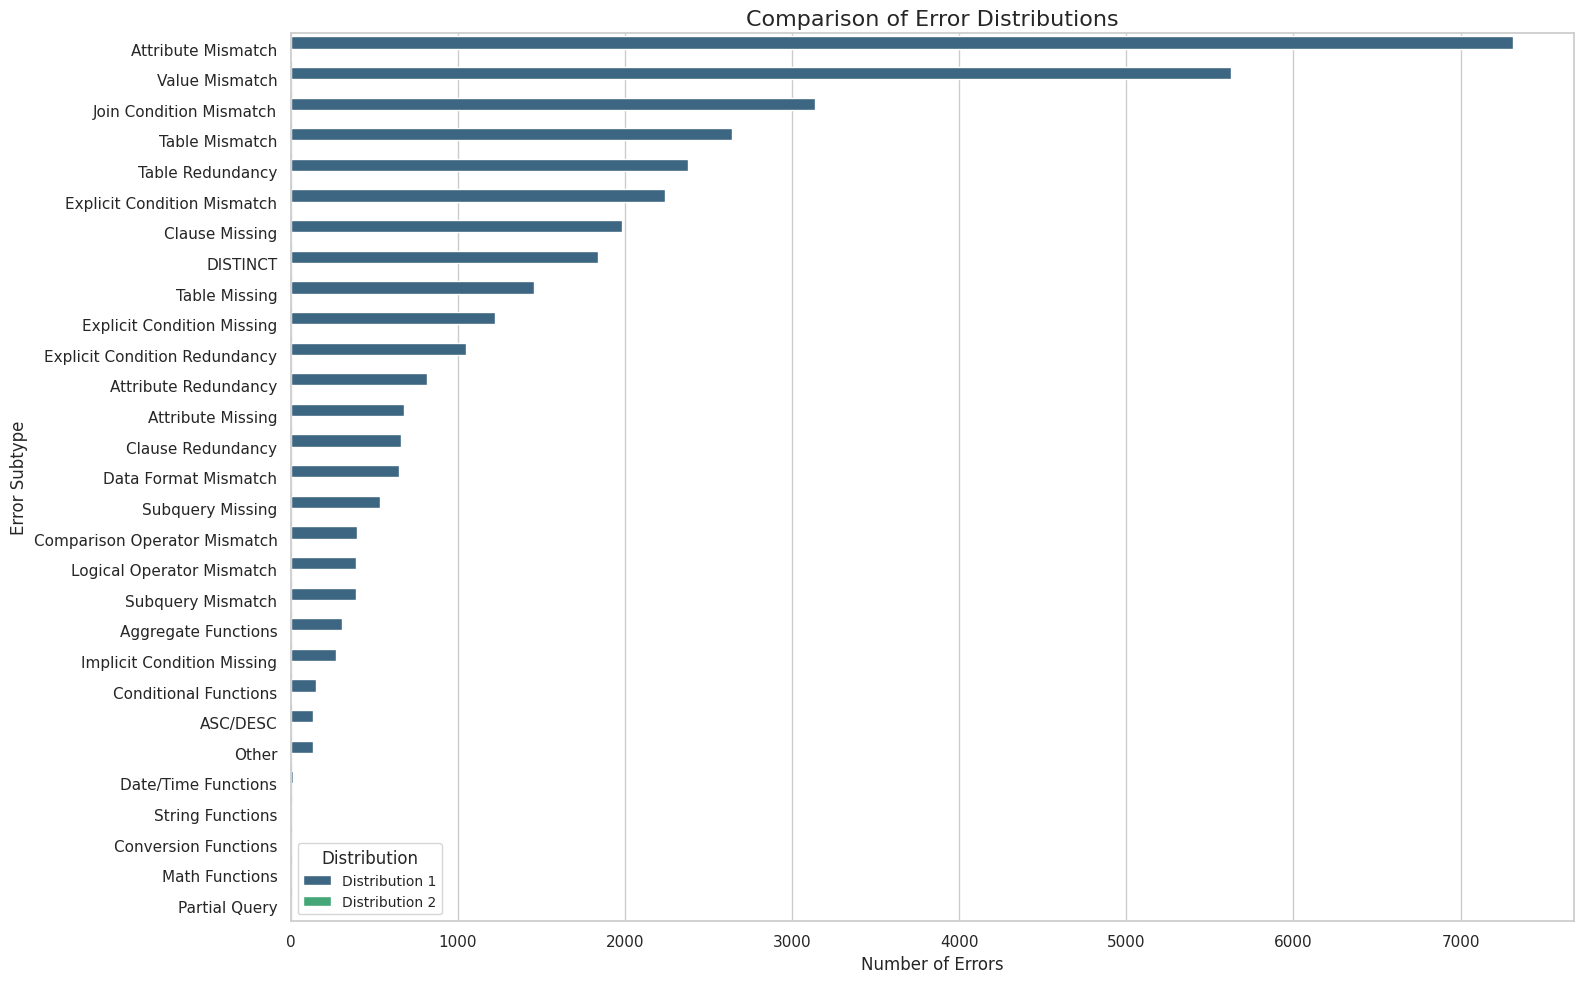

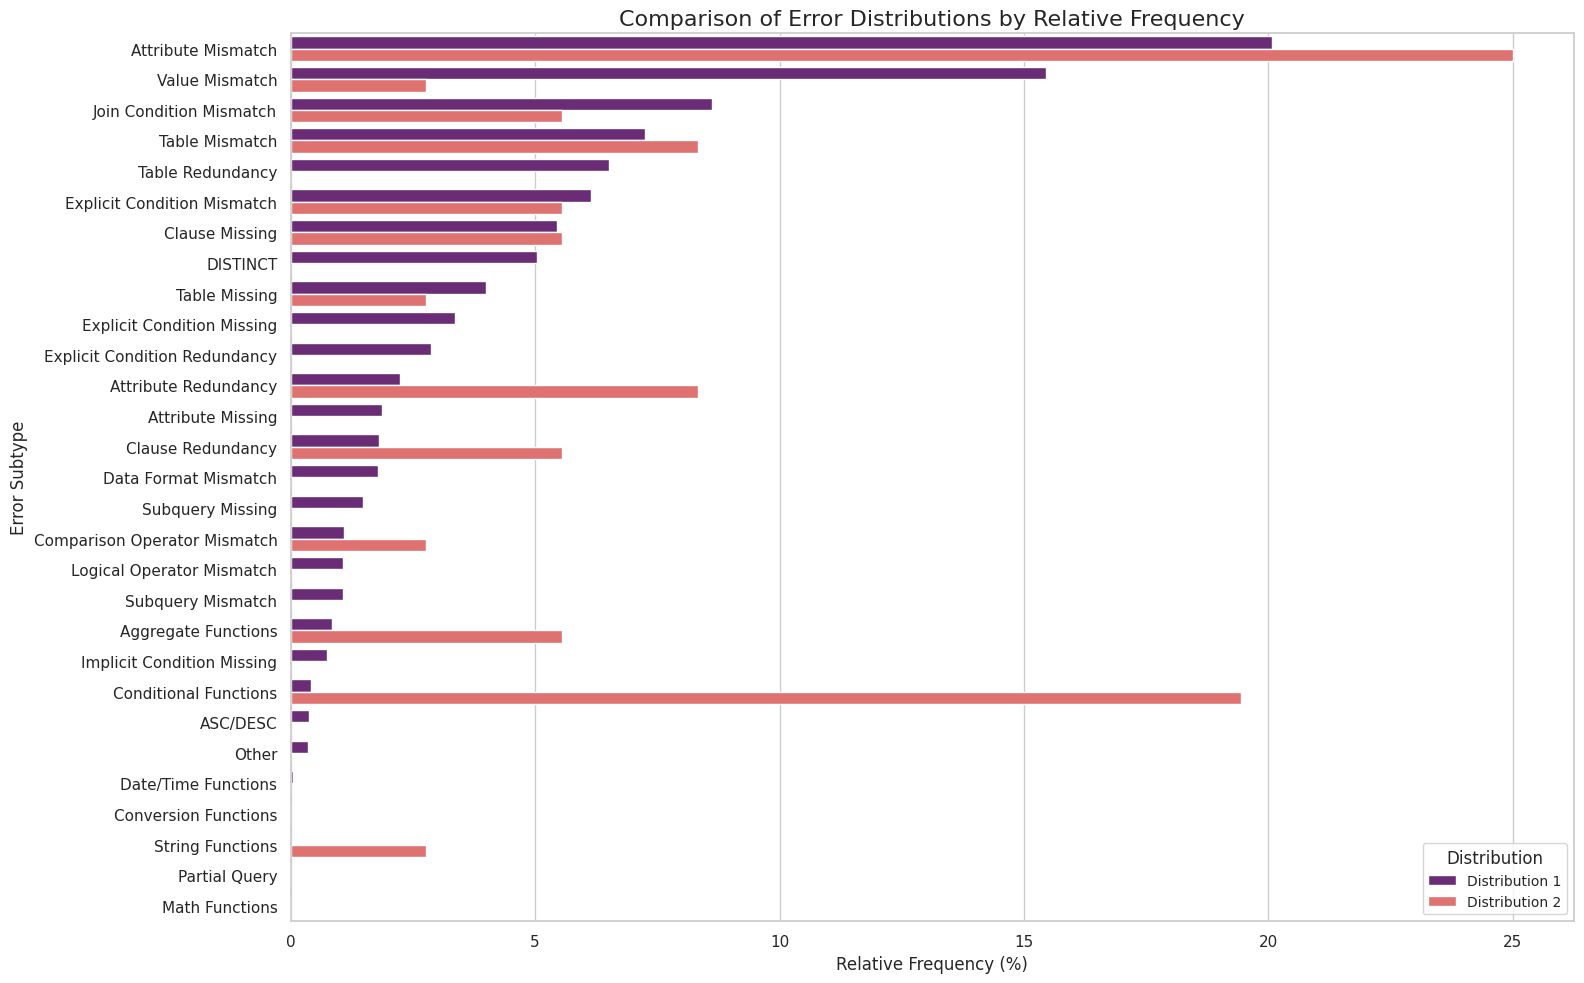

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 에러 딕셔너리 예시 (이 부분은 이미 가지고 있다고 가정)
# total_errortypes_count = {...}
# fp_errortypes_count = {...}

# ✅ 모든 고유 키 수집 및 누락된 키는 0으로 채우기
all_keys = sorted(set(total_errortypes_count.keys()).union(set(fp_errortypes_count.keys())))
full_dist1 = {key: total_errortypes_count.get(key, 0) for key in all_keys}
full_dist2 = {key: fp_errortypes_count.get(key, 0) for key in all_keys}

# ✅ 데이터프레임 생성
df1 = pd.DataFrame(list(full_dist1.items()), columns=['Error Type', 'Count'])
df1['Distribution'] = 'Distribution 1'

df2 = pd.DataFrame(list(full_dist2.items()), columns=['Error Type', 'Count'])
df2['Distribution'] = 'Distribution 2'

# ✅ Error Category, Error Subtype 컬럼 분리
df1[['Error Category', 'Error Subtype']] = pd.DataFrame(df1['Error Type'].tolist(), index=df1.index)
df2[['Error Category', 'Error Subtype']] = pd.DataFrame(df2['Error Type'].tolist(), index=df2.index)

# ✅ 병합
combined_df = pd.concat([df1, df2])

# ✅ 정렬 기준 설정
error_order = combined_df.groupby('Error Subtype')['Count'].sum().sort_values(ascending=False).index

# ✅ 절대 Count 기반 시각화
plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")
sns.barplot(
    x='Count',
    y='Error Subtype',
    hue='Distribution',
    data=combined_df,
    order=error_order,
    palette='viridis'
)
plt.title('Comparison of Error Distributions', fontsize=16)
plt.xlabel('Number of Errors', fontsize=12)
plt.ylabel('Error Subtype', fontsize=12)
plt.legend(title='Distribution', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

# ✅ 상대 비율 계산
df1['Relative Frequency (%)'] = (df1['Count'] / df1['Count'].sum()) * 100
df2['Relative Frequency (%)'] = (df2['Count'] / df2['Count'].sum()) * 100

df1[['Error Category', 'Error Subtype']] = pd.DataFrame(df1['Error Type'].tolist(), index=df1.index)
df2[['Error Category', 'Error Subtype']] = pd.DataFrame(df2['Error Type'].tolist(), index=df2.index)

combined_relative_df = pd.concat([df1, df2])

# ✅ 상대 비율 기준 정렬
relative_error_order = combined_relative_df[combined_relative_df['Distribution'] == 'Distribution 1'] \
    .sort_values(by='Relative Frequency (%)', ascending=False)['Error Subtype']

# ✅ 상대 빈도 기반 시각화
plt.figure(figsize=(16, 10))
sns.barplot(
    x='Relative Frequency (%)',
    y='Error Subtype',
    hue='Distribution',
    data=combined_relative_df,
    order=relative_error_order,
    palette='magma'
)
plt.title('Comparison of Error Distributions by Relative Frequency', fontsize=16)
plt.xlabel('Relative Frequency (%)', fontsize=12)
plt.ylabel('Error Subtype', fontsize=12)
plt.legend(title='Distribution', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()
